In [1]:
# New Transport Test

In [1]:
# %load C60_jupyter_imports.py
%load_ext autoreload
%autoreload 2

import xarray as xr
phys=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_month.zarr.zip')
phys=phys.rename({'xu_ocean':'lon_x','yu_ocean':'lat_x'})
phys=phys.rename({'xt_ocean':'lon','yt_ocean':'lat'})

phys['lon']=phys['lon']+360
import numpy as np
from dask.distributed import Client
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import xesmf as xe
from scipy.stats import linregress
import os
import requests
import os
import scipy.signal as sps
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from xgcm import Grid
# Lets import our functions. There are no tests here. Stored separately so as to not make a mess.
# Make sure in right dir first
#!pip install --user seawater==3.3.4
import seawater
import seaborn as sns
from pylab import cm

os.chdir('/g/data/xv83/np1383/src_CAFE60_eqpac_analysis_code/')
from C60_obs_functions import convert_trim_fratios
from xarray_trends import xarray_detrend,xarray_get_trend, deseasonaliser
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster

In [2]:
import matplotlib
import cartopy
print(matplotlib.__version__)
print(cartopy.__version__)

3.4.3
0.19.0.post1


In [3]:
atmos=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/atmos_isobaric_month.zarr.zip')
#atmos['lon']=atmos['lon']+360
eqpac_atmos=atmos.sel(lon=slice(120,290),lat=slice(-40,40))
eqpac_atmos['time']=eqpac_atmos.time.astype('datetime64[M]')
eqpac_atmos=eqpac_atmos.sel(ensemble=25)[['u_ref','v_ref']]
eqpac_atmos=eqpac_atmos.load()
eqpac_atmos

<xarray.Dataset>
Dimensions:   (time: 731, lat: 40, lon: 68)
Coordinates:
    ensemble  int32 25
  * lat       (lat) float64 -39.44 -37.42 -35.39 -33.37 ... 35.39 37.42 39.44
  * lon       (lon) float64 121.2 123.8 126.2 128.8 ... 281.2 283.8 286.2 288.8
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
Data variables:
    u_ref     (time, lat, lon) float32 4.322 4.034 3.937 ... 0.8249 1.42 2.179
    v_ref     (time, lat, lon) float32 -0.0221 -0.2344 ... 0.02577 0.4894
Attributes: (12/27)
    NCO:                        netCDF Operators version 4.7.8 (Homepage = ht...
    calendar:                    julian
    cm-enkf_source:             commit 0141830a243704acbf6d8c8c843b161a39ec39fa
    comment:                    pressure level interpolator, version 3.0, pre...
    contact_name:               Decadal Activity 1 - Data Assimilation
    control_name:               c5
    ...                         ...
    model_source:               commit 2abb29f4384e68777721fa657850587f28efd85a
    nominal_resoltuion:         Atmosphere delta lat = 2.02degrees ; Atmosphe...
    perturbation_name:          not applicable
    references:                 OKane, T.J., Sandery, P.A., Monselesan, D.P.,...
    run_variant_name:           data assimilation
    title:                      AccessOcean-AM2

In [4]:
eqws = np.sqrt(eqpac_atmos['u_ref']**2+eqpac_atmos['v_ref']**2)#.mean(dim='time')
#eqws.mean(dim='time').plot()

In [5]:
phys=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_month.zarr.zip')
phys=phys.rename({'xu_ocean':'lon_x','yu_ocean':'lat_x'})
phys=phys.rename({'xt_ocean':'lon','yt_ocean':'lat'})

In [6]:
#usemap_proj = ccrs.PlateCarree()#central_longitude=179)
#ax = plt.subplot(1,1,1,projection=usemap_proj)

In [7]:
# LOAD CAFE
bgc=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_bgc_month.zarr.zip')
bgc=bgc.rename({'xt_ocean':'lon','yt_ocean':'lat'})
bgc['lon']=bgc['lon']+360
eqpac=bgc.sel(lon=slice(120,290),lat=slice(-40,40))
eqpac['time']=eqpac.time.astype('datetime64[M]')
eqpac

<xarray.Dataset>
Dimensions:          (time: 731, ensemble: 96, st_ocean: 50, lat: 140, lon: 170, scalar_axis: 1)
Coordinates:
  * ensemble         (ensemble) int32 1 2 3 4 5 6 7 8 ... 90 91 92 93 94 95 96
  * scalar_axis      (scalar_axis) float64 0.0
  * st_ocean         (st_ocean) float64 5.0 15.0 25.0 ... 5.499e+03 5.831e+03
  * time             (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lon              (lon) float64 120.5 121.5 122.5 123.5 ... 287.5 288.5 289.5
  * lat              (lat) float64 -39.41 -38.44 -37.46 ... 37.42 38.38 39.34
Data variables: (12/33)
    adic             (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
    alk              (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
    caco3            (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
    caco3_sediment   (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 140, 170), meta=np.ndarray>
    det              (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
    det_sediment     (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 140, 170), meta=np.ndarray>
    ...               ...
    surface_o2       (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 140, 170), meta=np.ndarray>
    surface_phy      (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 140, 170), meta=np.ndarray>
    surface_zoo      (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 140, 170), meta=np.ndarray>
    total_aco2_flux  (time, ensemble, scalar_axis) float32 dask.array<chunksize=(1, 96, 1), meta=np.ndarray>
    total_co2_flux   (time, ensemble, scalar_axis) float32 dask.array<chunksize=(1, 96, 1), meta=np.ndarray>
    zoo              (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
Attributes: (12/24)
    calendar:                 julian
    cm-enkf_source:          commit 0141830a243704acbf6d8c8c843b161a39ec39fa
    contact_name:            Decadal Activity 1 - Data Assimilation
    control_name:            c5
    creation_date:           Thu Nov  5 17:19:53 2020
    data_assimilation_name:  d60
    ...                      ...
    model_source:            commit 2abb29f4384e68777721fa657850587f28efd85a
    nominal_resoltuion:      Atmosphere delta lat = 2.02degrees ; Atmosphere ...
    perturbation_name:       not applicable
    references:              OKane, T.J., Sandery, P.A., Monselesan, D.P., Sa...
    run_variant_name:        data assimilation
    title:                   AccessOcean-AM2

In [8]:
# Load Physics
phys=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_month.zarr.zip')
phys=phys.rename({'xu_ocean':'lon_x','yu_ocean':'lat_x'})
phys=phys.rename({'xt_ocean':'lon','yt_ocean':'lat'})

phys['lon']=phys['lon']+360
phys['lon_x']=phys['lon_x']+360

phys_eqpac=phys.sel(lon=slice(120,290),lat=slice(-40,40),lon_x=slice(120,290),lat_x=slice(-40,40),)

phys_eqpac['time']=phys_eqpac.time.astype('datetime64[M]')
phys_eqpac

<xarray.Dataset>
Dimensions:                 (time: 731, ensemble: 96, st_ocean: 50, lat: 140, lon: 170, sw_ocean: 50, lon_x: 171, lat_x: 141)
Coordinates:
  * ensemble                (ensemble) int32 1 2 3 4 5 6 7 ... 91 92 93 94 95 96
  * st_ocean                (st_ocean) float64 5.0 15.0 ... 5.499e+03 5.831e+03
  * sw_ocean                (sw_ocean) float64 10.0 20.0 ... 5.665e+03 6e+03
  * time                    (time) datetime64[ns] 1960-01-01 ... 2020-11-01
  * lon                     (lon) float64 120.5 121.5 122.5 ... 288.5 289.5
  * lon_x                   (lon_x) float64 120.0 121.0 122.0 ... 289.0 290.0
  * lat                     (lat) float64 -39.41 -38.44 -37.46 ... 38.38 39.34
  * lat_x                   (lat_x) float64 -39.9 -38.92 -37.95 ... 38.86 39.81
Data variables: (12/22)
    age_global              (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
    cfc_11                  (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
    cfc_12                  (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
    eta_t                   (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 140, 170), meta=np.ndarray>
    neutral_diffusion_salt  (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
    neutral_diffusion_temp  (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
    ...                      ...
    tx_trans_gm             (time, ensemble, st_ocean, lat, lon_x) float32 dask.array<chunksize=(1, 96, 3, 140, 171), meta=np.ndarray>
    ty_trans                (time, ensemble, st_ocean, lat_x, lon) float32 dask.array<chunksize=(1, 96, 3, 141, 170), meta=np.ndarray>
    ty_trans_gm             (time, ensemble, st_ocean, lat_x, lon) float32 dask.array<chunksize=(1, 96, 3, 141, 170), meta=np.ndarray>
    u                       (time, ensemble, st_ocean, lat_x, lon_x) float32 dask.array<chunksize=(1, 96, 3, 141, 171), meta=np.ndarray>
    v                       (time, ensemble, st_ocean, lat_x, lon_x) float32 dask.array<chunksize=(1, 96, 3, 141, 171), meta=np.ndarray>
    wt                      (time, ensemble, sw_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
Attributes: (12/24)
    calendar:                 julian
    cm-enkf_source:          commit 0141830a243704acbf6d8c8c843b161a39ec39fa
    contact_name:            Decadal Activity 1 - Data Assimilation
    control_name:            c5
    creation_date:           Thu Nov  5 17:19:53 2020
    data_assimilation_name:  d60
    ...                      ...
    model_source:            commit 2abb29f4384e68777721fa657850587f28efd85a
    nominal_resoltuion:      Atmosphere delta lat = 2.02degrees ; Atmosphere ...
    perturbation_name:       not applicable
    references:              OKane, T.J., Sandery, P.A., Monselesan, D.P., Sa...
    run_variant_name:        data assimilation
    title:                   AccessOcean-AM2

In [80]:
use_dask=True

if use_dask==True:
    # Set up the remote dask cluster. Can either use this version or a similar version above if building a LocalCluster.
    
    #cluster = SLURMCluster(cores=2,processes=1,memory="16GB")
    #cluster = SLURMCluster(cores=4,processes=2,memory="16GB")#47GB")
    cluster = SLURMCluster(cores=8,processes=2,memory="47GB")
    
    client = Client(cluster)
    cluster.scale(cores=64)
    #cluster.adapt(minimum=2, maximum=16)
    cluster
    #client

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36943 instead
  warnings.warn(


In [81]:
client#.close()

<Client: 'tcp://10.0.128.150:38153' processes=0 threads=0, memory=0 B>

In [82]:
#cluster.close()

In [12]:

cluster#.close()#phys_eqpac.chunk({"ensemble":1,"time":3}).

In [13]:
# Load Physics
#phys1=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_month.zarr.zip')
#phys_eqpac1=phys1.sel(xu_ocean=slice(120-360,290-360),yt_ocean=slice(-40,40))
#phys_eqpac1.tx_trans.mean(axis=1).sel(yt_ocean=5,method='nearest').mean(dim='time').plot()


In [14]:
temp_test=phys_eqpac[['temp','ty_trans','neutral_gm_temp','neutral_diffusion_temp']].sel(lat=[-5,5],lat_x=[-5,5],method='nearest').sel(ensemble=25).chunk('auto')

In [15]:
#temp_test=temp_test.load()

In [16]:
#temp_test=temp_test.load()#nbytes/1e9

In [17]:
temp_test

<xarray.Dataset>
Dimensions:                 (time: 731, st_ocean: 50, lat: 2, lon: 170, lat_x: 2)
Coordinates:
    ensemble                int32 25
  * st_ocean                (st_ocean) float64 5.0 15.0 ... 5.499e+03 5.831e+03
  * time                    (time) datetime64[ns] 1960-01-01 ... 2020-11-01
  * lon                     (lon) float64 120.5 121.5 122.5 ... 288.5 289.5
  * lat                     (lat) float64 -4.833 5.167
  * lat_x                   (lat_x) float64 -5.0 5.0
Data variables:
    temp                    (time, st_ocean, lat, lon) float32 dask.array<chunksize=(731, 50, 2, 170), meta=np.ndarray>
    ty_trans                (time, st_ocean, lat_x, lon) float32 dask.array<chunksize=(731, 50, 2, 170), meta=np.ndarray>
    neutral_gm_temp         (time, st_ocean, lat, lon) float32 dask.array<chunksize=(731, 50, 2, 170), meta=np.ndarray>
    neutral_diffusion_temp  (time, st_ocean, lat, lon) float32 dask.array<chunksize=(731, 50, 2, 170), meta=np.ndarray>
Attributes: (12/24)
    calendar:                 julian
    cm-enkf_source:          commit 0141830a243704acbf6d8c8c843b161a39ec39fa
    contact_name:            Decadal Activity 1 - Data Assimilation
    control_name:            c5
    creation_date:           Thu Nov  5 17:19:53 2020
    data_assimilation_name:  d60
    ...                      ...
    model_source:            commit 2abb29f4384e68777721fa657850587f28efd85a
    nominal_resoltuion:      Atmosphere delta lat = 2.02degrees ; Atmosphere ...
    perturbation_name:       not applicable
    references:              OKane, T.J., Sandery, P.A., Monselesan, D.P., Sa...
    run_variant_name:        data assimilation
    title:                   AccessOcean-AM2

In [18]:
# Area
area=xr.open_dataset('/g/data/xv83/rxm599/area.nc')
area['xt_ocean']=area['xt_ocean']+360
area['xu_ocean']=area['xu_ocean']+360
area_m2=area.sel(xt_ocean=slice(120,290),yt_ocean=slice(-40,40)).area_t.rename({'xt_ocean':'lon','yt_ocean':'lat'})


# Lon Grid size

gr=xr.open_dataset('/g/data/xv83/rxm599/grid_spec_dyn.nc')
gr=gr[['ds_00_02_T','ds_20_22_T','ds_02_22_T','ds_00_20_T']]
gr=gr.rename({'grid_x_T':'lon','grid_y_T':'lat'})
gr['lon']=gr['lon']+360
gr_slice=gr.sel(lon=slice(120,290),lat=slice(-40,40))#
lon_face_length_m=gr_slice.ds_00_02_T
#lon_face_length_m

In [19]:
cafe_y_tx=xr.open_dataset(f'../processed_data/physics_ds/ty_trans_physics_feb7.nc').ty_trans.chunk('auto')
cafe_x_tx=xr.open_dataset(f'../processed_data/physics_ds/tx_trans_physics_feb7.nc').tx_trans.chunk('auto')
anth_dic_cafe=xr.open_dataset('../processed_data/physics_ds/anth_DIC_pac_feb7.nc')
dic_cafe=xr.open_dataset('../processed_data/physics_ds/dic_pac_feb7.nc')


cafe_y_tx_fulldep=xr.open_dataset(f'../processed_data/physics_ds/ty_trans_fulldep_physics_feb7.nc').ty_trans.chunk('auto')
cafe_y_tx_fulldep_gm=xr.open_dataset(f'../processed_data/physics_ds/ty_trans_gm_fulldep_physics_feb7.nc').ty_trans_gm.chunk('auto')

cafe_x_tx_fulldep=xr.open_dataset(f'../processed_data/physics_ds/tx_trans_fulldep_physics_feb7.nc').tx_trans.chunk('auto')
cafe_x_tx_fulldep_gm=xr.open_dataset(f'../processed_data/physics_ds/tx_trans_gm_fulldep_physics_feb7.nc').tx_trans_gm.chunk('auto')



# GM HACK FIX
cafe_y_tx_gm=xr.open_dataset(f'../processed_data/physics_ds/ty_trans_gm_physics_feb7.nc').ty_trans_gm.chunk('auto').diff('st_ocean',n=1)
cafe_x_tx_gm=xr.open_dataset(f'../processed_data/physics_ds/tx_trans_gm_physics_feb7.nc').tx_trans_gm.chunk('auto').diff('st_ocean',n=1)


# Run tracer transport Calculation
# This will do the two sides of the box but not vertical (bottom / top)> Make new calc to get wt transport?
calculate_horizontal_tracers=False
if calculate_horizontal_tracers==True:
    names=['anth_dic_cafe']#,
    for i,tracer in enumerate([anth_dic_cafe,dic_cafe]):
        tracer_u=tracer.rename({'lon':'lon_x'}).chunk('auto')
        tracer_v=tracer.rename({'lat':'lat_x'}).chunk('auto')

        tracer_u_interp=tracer_u.interp(lon_x=cafe_x_tx.lon_x) # U is X (lon)
        tracer_v_interp=tracer_v.interp(lat_x=cafe_y_tx.lat_x) # V is Y (lat)

        # Do need to take mean of adjacent pixels still or not?
        adjacent_boxes=False
        if adjacent_boxes==True:
            tracer_u_tx=tracer_u_interp.rolling(lat=2).mean()*cafe_x_tx.rolling(lon_x=2).mean()
            tracer_v_tx=tracer_v_interp.rolling(lon=2).mean()*cafe_y_tx.rolling(lat_x=2).mean()
        elif adjacent_boxes==False:
            tracer_u_tx=tracer_u_interp*cafe_x_tx
            tracer_v_tx=tracer_v_interp*cafe_y_tx

        # Rename back to main grid so we can use the coords easily
        tracer_u_tx=tracer_u_tx.rename({'lon_x':'lon'})
        tracer_v_tx=tracer_v_tx.rename({'lat_x':'lat'})
        print('saving')
        tracer_u_tx.to_netcdf(f'/g/data/xv83/np1383/processed_data/physics_ds/{names[i]}_u_transport1.nc')
        print('u saved')
        tracer_v_tx.to_netcdf(f'/g/data/xv83/np1383/processed_data/physics_ds/{names[i]}_v_transport1.nc')
        print('v saved')
        
anth_dic_u_tx_gm=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_cafe_u_transport1_gm.nc').__xarray_dataarray_variable__.chunk('auto')*1e6 #to mmol/s
anth_dic_v_tx_gm=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_cafe_v_transport1_gm.nc').__xarray_dataarray_variable__.chunk('auto')*1e6 #to mmol/s
anth_dic_u_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_cafe_u_transport1.nc').__xarray_dataarray_variable__.chunk('auto')*1e6 #to mmol/s
anth_dic_v_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_cafe_v_transport1.nc').__xarray_dataarray_variable__.chunk('auto')*1e6 #to mmol/s
dic_u_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_cafe_u_transport.nc').__xarray_dataarray_variable__.chunk('auto')*1e6 #to mmol/s
dic_v_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_cafe_v_transport.nc').__xarray_dataarray_variable__.chunk('auto')*1e6 #to mmol/s
# Units of these should be mmolC/m3 to then SV(kg/s) = mmolC /s so MMol/s *10e6

# Test they look OK

#chunk({'time':-1}).sel(time=slice('2000-01-01','2020-01-01')).
plot=False
if plot==True:
    anth_dic_v_tx.mean(dim='time').sel(lat=-3,method='nearest').plot()#(vmin=-20,vmax=20,cmap='bwr')
    plt.show()
    anth_dic_u_tx.mean(dim='time').sel(lon=180,method='nearest').plot()#(vmin=-20,vmax=20,cmap='bwr')
    plt.show()
    anth_dic_u_tx.mean(dim='time').sel(lat=0,method='nearest').plot()#(vmin=-20,vmax=20,cmap='bwr')
    
    

In [20]:
#dic=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_pac_feb7.nc') #physics_ds
#cafe_x_tx=xr.open_dataset('/g/data4/xv83/np1383/processed_data/physics_ds/tx_trans_physics_feb7.nc').tx_trans.chunk('auto')
#cafe_y_tx=xr.open_dataset('/g/data4/xv83/np1383/processed_data/physics_ds/ty_trans_physics_feb7.nc').ty_trans.chunk('auto')
#cafe_x_tx_gm=xr.open_dataset('/g/data4/xv83/np1383/processed_data/physics_ds/tx_trans_gm_physics_feb7.nc').tx_trans_gm.chunk('auto') # Including eddies or subscale processes?
#cafe_y_tx_gm=xr.open_dataset('/g/data4/xv83/np1383/processed_data/physics_ds/ty_trans_gm_physics_feb7.nc').ty_trans_gm.chunk('auto')


# y is v and x is u directions?

#adic_cafe=dic['adic'].chunk('auto')
#dic_cafe=dic['dic'].chunk('auto')
#anth_dic_cafe=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_DIC_pac_feb7.nc').__xarray_dataarray_variable__.chunk('auto')

#anth_dic_u_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_cafe_u_transport.nc').__xarray_dataarray_variable__.chunk('auto')*1e6 #to mmol/s
#anth_dic_v_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_cafe_v_transport.nc').__xarray_dataarray_variable__.chunk('auto')*1e6 #to mmol/s
#dic_u_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_cafe_u_transport.nc').__xarray_dataarray_variable__.chunk('auto')*1e6 #to mmol/s
#dic_v_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_cafe_v_transport.nc').__xarray_dataarray_variable__.chunk('auto')*1e6 #to mmol/s

#These ones are a bit hack
#anth_dic_u_tx_gm=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_cafe_u_transport1_gm.nc').__xarray_dataarray_variable__.chunk('auto')*1e6 #to mmol/s
#anth_dic_v_tx_gm=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_cafe_v_transport1_gm.nc').__xarray_dataarray_variable__.chunk('auto')*1e6 #to mmol/s


#cafe_potential_density['st_ocean']=cafe_potential_density.st_ocean*-1



In [21]:

cafe_u=xr.open_dataset('/g/data4/xv83/np1383/processed_data/physics_ds/u_physics_feb7.nc').u.chunk('auto') # Including eddies or subscale processes?
cafe_v=xr.open_dataset('/g/data4/xv83/np1383/processed_data/physics_ds/v_physics_feb7.nc').v.chunk('auto')
# y is v and x is u directions?

cafe_density=xr.open_dataset('../processed_data/physics_ds/density_physics_feb7.nc').__xarray_dataarray_variable__
cafe_potential_density=xr.open_dataset('../processed_data/physics_ds/potential_density_physics_feb7.nc').__xarray_dataarray_variable__
cafe_potential_density_rev=cafe_potential_density.copy()
cafe_potential_density_rev['st_ocean']=cafe_potential_density_rev['st_ocean']*-1



dic=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_pac_feb7.nc') #physics_ds
adic_cafe=dic['adic'].chunk('auto')
dic_cafe=dic['dic'].chunk('auto')
anth_dic_cafe=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_DIC_pac_feb7.nc').__xarray_dataarray_variable__.chunk('auto')

adic_cafe=dic['adic']
dic_cafe=dic['dic']
anth_dic_cafe=xr.open_dataset('../processed_data/physics_ds/anth_DIC_pac_feb7.nc').__xarray_dataarray_variable__
cafe_wt=xr.open_dataset('../processed_data/physics_ds/wt_physics_feb7.nc').wt


cafe_co2=-xr.open_dataset('../processed_data/physics_ds/stf10_bgc_feb7.nc').stf10
cafe_co2_natural=-xr.open_dataset('../processed_data/physics_ds/stf07_bgc_feb7.nc').stf07
cafe_co2_anth=cafe_co2-cafe_co2_natural
# Since we are calculating the below in mmol/m3/s, compared to the cafe transport calcs from CAFE which are in sverdrups 1,000,000 m3/s

upwelling=(cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().rename({'sw_ocean':'st_ocean'}).interp({'st_ocean':dic_cafe.st_ocean})*dic_cafe.chunk('auto').rolling(st_ocean=2).mean()*area_m2)#/1e6 # To Sverdrups (From m3?)
anthupwelling=(cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().rename({'sw_ocean':'st_ocean'}).interp({'st_ocean':dic_cafe.st_ocean})*anth_dic_cafe.chunk('auto').rolling(st_ocean=2).mean()*area_m2)#/1e6 # To Sverdrups

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ... 

In [22]:
run_surface_mask=False
if run_surface_mask==True:
    # North WBC 120 to 135E
    # North Surface 50m, but 205 to 255 linear trend between 50 and 0m
    # North Subsurface below 50m and linear line, and above 1027kg m3 


    # South WBC is 145 to 160 to 1027kg
    # South Surface above 50
    # South subsurface below 50 above 1027
    # 105W is 180+75
    
    # Example of the linear line
    #x=np.arange(215,255,1)
    #y=np.arange(50,0,-1.25)
    #res=linregress(x,y)
    #diagonal=res.intercept + res.slope*x
    #diagonal
    depth_matrix=phys_eqpac[['st_ocean','lat','lon','time']]
    depth_matrix['vals']=(depth_matrix.st_ocean/1.25)+depth_matrix.lon # Conversion from len(50) to len(40)
    # Depth is 50 to 0
    # # 145 to 105W (
    #cafe_potential_density['lat']=cafe_potential_density.chunk('auto').interp({'lat':depth_matrix.lat})
   
    depth_matrix['st_ocean']=depth_matrix.st_ocean*-1 
    full_depth_matrix=depth_matrix.copy(deep=True).where(cafe_potential_density.chunk('auto')>0)
    
    depth_matrix=depth_matrix.where(cafe_potential_density.chunk('auto')<=1026.3) # Limit to 1027 kg m3-3 (1026.3*1.025)
    depth_matrix['st_ocean']=depth_matrix.st_ocean*-1
    full_depth_matrix['st_ocean']=full_depth_matrix.st_ocean*-1
    
    
    south_surface_mask=depth_matrix.where(depth_matrix.st_ocean<=50).sel(lon=slice(160,290))
    south_subsurface_mask=depth_matrix.where(depth_matrix.st_ocean>50).sel(lon=slice(160,290))
    south_wbc=full_depth_matrix.sel(lon=slice(145,160),st_ocean=slice(0,1000))
    shallow_south_wbc=depth_matrix.sel(lon=slice(145,160))

    surface_mask=depth_matrix.where(depth_matrix.st_ocean<=50).where((depth_matrix.vals)<255) # surface mask # Linear Fit between 215 and 255 degrees and 0 and 50m means val always < 255 (1.25 is conversion for 40 lats rather than 50
    north_surface_mask=surface_mask.sel(lon=slice(135,290)).where(depth_matrix.st_ocean<50)
    north_subsurface_mask=depth_matrix.where(np.isnan(surface_mask)).sel(lon=slice(135,290))
    north_wbc=full_depth_matrix.sel(lon=slice(120,135),st_ocean=slice(0,1000))
    shallow_north_wbc=depth_matrix.sel(lon=slice(120,135))

    masker=depth_matrix
    masker['south_subsurface']=~np.isnan(south_subsurface_mask.vals)
    masker['south_surface']=~np.isnan(south_surface_mask.vals)
    masker['south_wbc']=~np.isnan(south_wbc.vals)
    masker['shallow_south_wbc']=~np.isnan(shallow_south_wbc.vals)
    #masker['south_wbc_subsurface']=~np.isnan(depth_matrix.vals.where((~np.isnan(south_subsurface_mask.vals))|(~np.isnan(south_wbc.vals))))
    masker['above_isopycnal']=~np.isnan(depth_matrix.vals)#masker.where(((masker.south_subsurface==1)&(masker.south_surface==1)&(masker.south_wbc==1)))

    masker['north_subsurface']=~np.isnan(north_subsurface_mask.vals)
    masker['north_surface']=~np.isnan(north_surface_mask.vals)
    masker['north_wbc']=~np.isnan(north_wbc.vals)
    masker['shallow_north_wbc']=~np.isnan(shallow_north_wbc.vals)
    #masker['north_wbc_subsurface']=~np.isnan(depth_matrix.vals.where((~np.isnan(north_subsurface_mask.vals))|(~np.isnan(north_wbc.vals))))
    #masker['south_above_isopycnal']=depth_matrix#masker.where(((masker.north_subsurface==1)&(masker.north_surface==1)&(masker.north_wbc==1)))
    

    mask=masker.sel(lat=[-9,-5,-3,0,3,5,9],method='nearest').drop('vals').chunk('auto')#.nbytes/1e9
    mask['st_ocean']=mask.st_ocean*-1 

    print(mask.nbytes/1e9)
    mask.to_netcdf('new_calculations/region_mask_new.nc')
#mask.to_netcdf('new_calculations/region_mask_may12.nc')

region_mask=xr.open_dataset('new_calculations/region_mask_new.nc').sortby('lat') #region_mask_may12
region_mask#.close()#mask['st_ocean']=mask.st_ocean*-1 # mask will need a bit of fixing (where =1)

<xarray.Dataset>
Dimensions:            (lon: 170, st_ocean: 30, lat: 7, time: 731)
Coordinates:
  * lon                (lon) float64 120.5 121.5 122.5 ... 287.5 288.5 289.5
  * st_ocean           (st_ocean) float64 -5.0 -15.0 -25.0 ... -812.8 -969.1
  * lat                (lat) float64 -8.833 -4.833 -2.833 ... 3.167 5.167 9.167
  * time               (time) datetime64[ns] 1960-01-01 ... 2020-11-01
    ensemble           int32 ...
Data variables:
    south_subsurface   (st_ocean, lon, time, lat) float64 ...
    south_surface      (st_ocean, lon, time, lat) float64 ...
    south_wbc          (st_ocean, lon, time, lat) float64 ...
    shallow_south_wbc  (st_ocean, lon, time, lat) float64 ...
    above_isopycnal    (st_ocean, lon, time, lat) bool ...
    north_subsurface   (st_ocean, lon, time, lat) float64 ...
    north_surface      (st_ocean, lon, time, lat) float64 ...
    north_wbc          (st_ocean, lon, time, lat) float64 ...
    shallow_north_wbc  (st_ocean, lon, time, lat) float64 ...
Attributes: (12/24)
    calendar:                 julian
    cm-enkf_source:          commit 0141830a243704acbf6d8c8c843b161a39ec39fa
    contact_name:            Decadal Activity 1 - Data Assimilation
    control_name:            c5
    creation_date:           Thu Nov  5 17:19:53 2020
    data_assimilation_name:  d60
    ...                      ...
    model_source:            commit 2abb29f4384e68777721fa657850587f28efd85a
    nominal_resoltuion:      Atmosphere delta lat = 2.02degrees ; Atmosphere ...
    perturbation_name:       not applicable
    references:              OKane, T.J., Sandery, P.A., Monselesan, D.P., Sa...
    run_variant_name:        data assimilation
    title:                   AccessOcean-AM2

In [23]:
# LOAD ENSO

#Calculate ENSO

#Process EP, CP and Nino events.
elnino=pd.read_csv('../processed_data/indexes/el_nino_events_ch2.csv')
lanina=pd.read_csv('../processed_data/indexes/la_nina_events_ch2.csv')
ep_nino=pd.read_csv('../processed_data/indexes/ep_events_ch2.csv')
cp_nino=pd.read_csv('../processed_data/indexes/cp_events_ch2.csv')


nina=pd.DataFrame()
#nino=pd.DataFrame() @Wrapped in ep and cp... but maybe good to have own months?
ep=pd.DataFrame()
cp=pd.DataFrame()
all_dates=eqpac.sel(time=slice('1980','2020')).time#cafe_sst_mean.time

#Set to after 2000.
all_dates=all_dates.where(all_dates.time>=np.datetime64('2000-01-01')).dropna(dim='time')
all_dates=all_dates.where(all_dates.time<np.datetime64('2020-01-01')).dropna(dim='time')

def drop_df_values(df1,df2):
    df=df1[~df1.isin(df2)].dropna(how = 'all')
    return df

#for i in lanina.iterrows(): nina=nina.append(info[slice(i[1].start,i[1].end)])
for i in lanina.iterrows(): nina=nina.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))
for i in ep_nino.iterrows(): ep=ep.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))
for i in cp_nino.iterrows(): cp=cp.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))

#all_dates=chl.time
all_dates2=pd.DataFrame(all_dates.values)#[36:] #2000 - 2020
neutral=drop_df_values(drop_df_values(drop_df_values(all_dates2[0],cp[0]),ep[0]),nina[0])
#ep,cp,nino,neutral,info

cp_events=cp[0].values
ep_events=ep[0].values
nina_events=nina[0].values
neutral_events=neutral.values
#grid_multiplier_lat
#grid_multiplier_lon

In [24]:
#load dic/adic straight from the equapc source?
cluster

In [25]:
# Validation Budget to get total Anth C accumulation
anth_dic_cafe=xr.open_dataset('../processed_data/physics_ds/anth_DIC_pac_alldep.nc').chunk('auto').__xarray_dataarray_variable__
dic_cafe=xr.open_dataset('../processed_data/physics_ds/dic_pac_alldep.nc').chunk('auto').adic#.__xarray_dataarray_variable_
nat_dic_cafe=xr.open_dataset('../processed_data/physics_ds/dic_pac_alldep.nc').chunk('auto').dic#.__xarray_dataarray_variable_
dic_cafe['st_ocean']=dic_cafe['st_ocean']*-1 
nat_dic_cafe['st_ocean']=nat_dic_cafe['st_ocean']*-1 

st_ocean_holder=anth_dic_cafe.st_ocean
l=0
depth_diffs=[]
# Calcualate the m between depths so we can integrate
for i,x in enumerate(st_ocean_holder.st_ocean):
    d=x.values-l
    l=x.values
    #print(d)#x.values)
    depth_diffs.append(d)


area_m2=xr.open_dataset('/g/data/xv83/rxm599/area.nc')
area_m2['xt_ocean']=area_m2['xt_ocean']+360
#area_m2['xu_ocean']=area_m2['xu_ocean']+360
area_m2=area_m2.sel(xt_ocean=slice(120,290),yt_ocean=slice(-40,40)).area_t.rename({'xt_ocean':'lon','yt_ocean':'lat'})        
    
st_ocean_holder=st_ocean_holder.assign_coords(
    depth_diff=('st_ocean', depth_diffs))


tot_anth_dic_cafe=anth_dic_cafe*area_m2*st_ocean_holder.depth_diff#/1000 #mol anthC (m3 is now cancelled)
tot_anth_dic_cafe['st_ocean']=tot_anth_dic_cafe['st_ocean']*-1
tot_dic_cafe=dic_cafe*area_m2*st_ocean_holder.depth_diff#/1000 #mol anthC (m3 is now cancelled) #Cell weighted depth
tot_dic_cafe['st_ocean']=tot_dic_cafe['st_ocean']*-1    
tot_nat_dic_cafe=nat_dic_cafe*area_m2*st_ocean_holder.depth_diff#/1000 #mol anthC (m3 is now cancelled)
tot_nat_dic_cafe['st_ocean']=tot_nat_dic_cafe['st_ocean']*-1    

In [26]:
raw_carbon=eqpac[['dic','adic']].sel(ensemble=25,time=slice('2000-01-01','2020-01-01'),lat=slice(-5,5)).load() #CHECK LOAD
raw_carbon_area=raw_carbon*area_m2*st_ocean_holder.depth_diff

In [27]:
raw_carbon_area

<xarray.Dataset>
Dimensions:     (lat: 30, st_ocean: 50, time: 241, lon: 170)
Coordinates:
  * lat         (lat) float64 -4.833 -4.5 -4.166 -3.834 ... 4.166 4.5 4.833
    ensemble    int32 25
  * st_ocean    (st_ocean) float64 5.0 15.0 25.0 ... 5.499e+03 5.831e+03
  * time        (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2020-01-01
  * lon         (lon) float64 120.5 121.5 122.5 123.5 ... 287.5 288.5 289.5
    depth_diff  (st_ocean) float64 5.0 10.0 10.0 10.0 ... 323.6 333.1 332.0
Data variables:
    dic         (time, st_ocean, lat, lon) float64 3.589e+13 3.594e+13 ... nan
    adic        (time, st_ocean, lat, lon) float64 3.689e+13 3.693e+13 ... nan

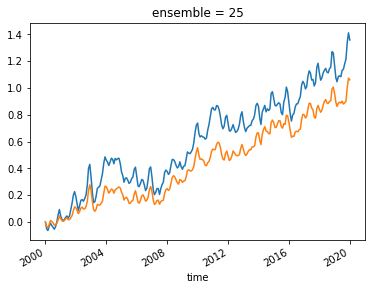

In [28]:
anth_c=raw_carbon_area.adic-raw_carbon_area.dic
(((anth_c-anth_c.values[0]).sum(['lat','lon','st_ocean'])*12)/1e18).plot()
(((anth_c-anth_c.values[0]).sel(st_ocean=slice(0,300)).sum(['lat','lon','st_ocean'])*12)/1e18).plot()

In [30]:
(((raw_carbon_area-raw_carbon_area.values[0]).sum(['lat','lon','st_ocean'])*12)/1e18).plot()

TypeError: 'method' object is not subscriptable

In [ ]:
st_ocean_holder.depth_diff

In [ ]:
((tot_anth_dic_cafe.sel(lat=slice(-40,40),lon=slice(160,280)).sum(['lon','st_ocean'])*12)/1e18).plot()

In [ ]:
((tot_dic_cafe.sel(lat=slice(-40,40),lon=slice(160,280)).sum(['lon','st_ocean'])*12)/1e18).plot()

In [ ]:
# Anth accumulation .....
((tot_dic_cafe.sel(lat=slice(-5,5),lon=slice(160,280)).sum(['lat']).mean(dim='time')*12)/1e18).plot()

In [ ]:
((tot_dic_cafe.sel(lat=slice(-5,5),lon=slice(160,280)).sum(['lon','lat','st_ocean'])*12)/1e18).plot()
((tot_nat_dic_cafe.sel(lat=slice(-5,5),lon=slice(160,280)).sum(['lon','lat','st_ocean'])*12)/1e18).plot()


In [ ]:
#(((tot_dic_cafe-tot_nat_dic_cafe).sel(lat=slice(-5,5),lon=slice(160,280)).sum(['lon','lat','st_ocean'])*12)/1e18).plot()
(((tot_dic_cafe-tot_nat_dic_cafe).sel(lat=slice(-5,5),lon=slice(160,280)).sum(['lon','lat','st_ocean'])*12)/1e18).plot()

In [ ]:
(((tot_anth_dic_cafe).sel(lat=slice(-5,5),lon=slice(160,280)).sum(['lon','lat','st_ocean'])*12)/1e18).plot()

#((.sel(lat=slice(-5,5),lon=slice(160,280)).sum(['lon','lat','st_ocean'])*12)/1e18).plot()
#dic=eqpac.sel(ensemble=25)[['dic','adic']].chunk('auto') #,st_ocean=slice(0,1000)
#    anth_dic=dic['adic']-dic['dic']

In [ ]:
vals=(((tot_anth_dic_cafe).sel(lat=slice(-5,5),lon=slice(160,280)).sum(['lon','lat','st_ocean'])*12)/1e18)#.plot()
vals=vals.sel(time=slice('2000-01-01','2020-01-01'))
(vals-vals.values[0]).plot()

In [ ]:
((tot_anth_dic_cafe.sel(lat=slice(-40,40),lon=slice(160,280)).sum(['lon','lat','st_ocean'])*12)/1e18).plot()

In [ ]:
tot_anth_dic_cafe.sel(lat=slice(-5,5)).mean(dim=['time']).sum('st_ocean').plot()

In [ ]:
((tot_anth_dic_cafe.sel(lat=slice(-5,5),lon=slice(160,300)).sum(['lat','lon','st_ocean'])*12)/1e18).plot()

In [ ]:
((tot_anth_dic_cafe.sel(lat=slice(-40,40),lon=slice(160,280)).sum(['lon','st_ocean'])*12)/1e18).plot()

In [ ]:
plt.figure(figsize=(10,6))
((tot_anth_dic_cafe.sel(lat=slice(-40,40),lon=slice(160,280)).sum(['lon','lat','st_ocean'])*12)/1e18).plot()
((tot_anth_dic_cafe.sel(lat=slice(-5,5),lon=slice(160,280)).sum(['lon','lat','st_ocean'])*12)/1e18).plot()
plt.grid()
plt.legend(['40NS','5NS'])

In [ ]:
cutout=((tot_anth_dic_cafe.sel(lat=slice(-5,5),lon=slice(160,280)).sel(time=slice('2000-01-01','2020-01-01')))).sum(['lat','lon','st_ocean'])
baseline=cutout.sel(time='2000-01-01',method='nearest')
(((cutout-baseline)*12)/1e18).plot()
plt.title('Anthropogenic Carbon accumulation since 2000 (PgC)')

In [ ]:
((tot_anth_dic_cafe.sel(lat=slice(-3,3),lon=slice(160,250)).sum(['lat','lon','st_ocean'])*12)/1e18).sel(time='2000-01-01',method='nearest').values

In [ ]:
((tot_anth_dic_cafe.sel(lat=slice(-3,3),lon=slice(160,250)).sum(['lat','lon','st_ocean'])*12)/1e18).sel(time='2020-01-01',method='nearest').values

In [ ]:
# Anth accumulation .....
((tot_anth_dic_cafe.sel(lat=slice(-5,5),lon=slice(160,280)).sum(['lat']).mean(dim='time')*12)/1e18).plot()

In [ ]:
# Quoick transport / ITF validation

In [ ]:
#cafe_x_tx_fulldep_physics_feb7.nc')

In [29]:
N_transport=cafe_y_tx_fulldep.sel(lat_x=5,method='nearest').sel(time=slice('2000-01-01','2020-01-01')).sel(lon=slice(120,290))
S_transport=cafe_y_tx_fulldep.sel(lat_x=-5,method='nearest').sel(time=slice('2000-01-01','2020-01-01')).sel(lon=slice(140,290))
N_S_tx=(-N_transport.sum(['st_ocean','lon'])+S_transport.sum(['st_ocean','lon']))
itf1=cafe_x_tx.sel(lat=-5,method='nearest').sel(lon_x=slice(120,140),time=slice('2000-01-01','2020-01-01'))
itf2=cafe_y_tx_fulldep.sel(lon=120,method='nearest').sel(lat_x=slice(-5,5),time=slice('2000-01-01','2020-01-01'))
itf=(itf1.sum(['st_ocean','lon_x'])+itf2.sum(['st_ocean','lat_x']))#.sum(['st_ocean','lat_x  #N_S_tx

In [31]:
print((-itf).mean().values)
print((-N_transport.sum(['st_ocean','lon'])).mean().values)
print((S_transport.sum(['st_ocean','lon'])).mean().values)



10.747212
-2.578629
13.826185


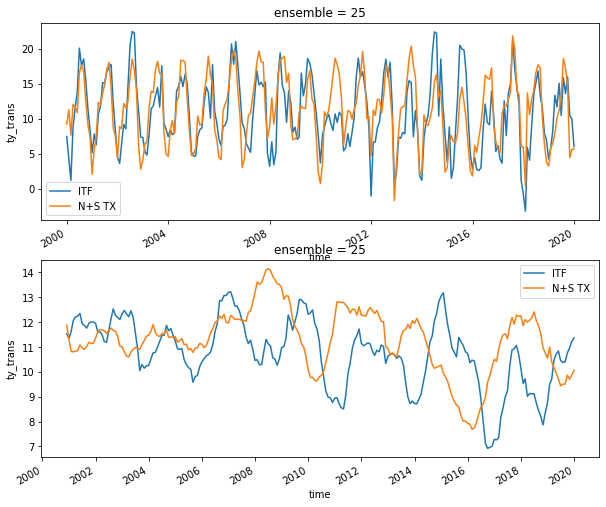

In [45]:
plt.figure(figsize=(10,8))
plt.subplot(211)
(-itf).plot()
N_S_tx.plot()
plt.legend(['ITF','N+S TX'])
plt.subplot(212)
(-itf).rolling(time=12).mean().plot()
N_S_tx.rolling(time=12).mean().plot()
plt.legend(['ITF','N+S TX'])

In [53]:
# OK. Possibly I made an error in the transports
# perhaps never multiplied mmolC m3 into grid area. This is calced in raw_carbon_area already. So maybe double check against the transports we calculated above, compared to the flawed transports below.



canth_area=raw_carbon_area['adic']-raw_carbon_area['dic']
canth_area['st_ocean']=canth_area['st_ocean']*-1
# raw_carbon_area
(cafe_y_tx_fulldep.sel(lat_x=5,method='nearest').sel(time=slice('2000-01-01','2020-01-01')).sel(lon=slice(120,290))*canth_area.sel(lat=5,method='nearest').sel(time=slice('2000-01-01','2020-01-01')).sel(lon=slice(120,290)))

In [123]:
N_transport_canth=canth_area.sel(lat=5,method='nearest').sel(time=slice('2000-01-01','2020-01-01')).sel(lon=slice(120,290))
S_transport_canth=canth_area.sel(lat=-5,method='nearest').sel(time=slice('2000-01-01','2020-01-01')).sel(lon=slice(140,290))
N_S_tx_canth=((((-N_transport*N_transport_canth).sum(['st_ocean','lon'])+(S_transport*S_transport_canth).sum(['st_ocean','lon']))*60*60*24*365*12)/1e18)
                                        
itf1_canth=canth_area.sel(lat=-5,method='nearest').sel(lon=slice(120,140),time=slice('2000-01-01','2020-01-01'))
itf2_canth=canth_area.sel(lon=120,method='nearest').sel(lat=slice(-5,5),time=slice('2000-01-01','2020-01-01'))
                                                                                                                                                                                                      
itf1_rename=itf1.rename({'lon_x':'lon'}).interp(lon=itf1_canth.lon)
itf2_rename=itf2.rename({'lat_x':'lat'}).interp(lat=itf2_canth.lat)                                                                         
                                                                                                         
itf_canth=((((itf1_rename*itf1_canth).sum(['st_ocean','lon'])+(itf2_rename*itf2_canth).sum(['st_ocean','lat']))*60*60*24*365*12)/1e18)#.sum(['st_ocean','lat_x  #N_S_tx

plt.figure(figsize=(10,8))
plt.subplot(211)
(-itf_canth/1e6).plot()
(N_S_tx_canth/1e6).plot()
plt.legend(['-ITF canth','N+S TX canth'])
plt.subplot(212)
(-itf_canth/1e6).rolling(time=12).mean().plot()
(N_S_tx_canth/1e6).rolling(time=12).mean().plot()
plt.legend(['-ITF canth','N+S TX canth'])

NameError: name 'canth_area' is not defined

(-1000.0, 0.0)

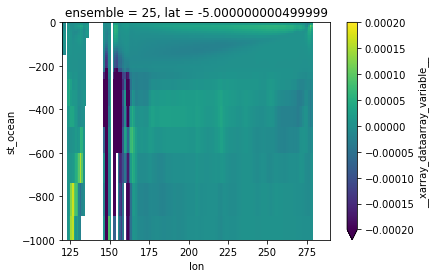

In [119]:
(((anth_dic_area_v_tx.sel(lat=-5,method='nearest').mean(dim='time')*60*60*24*365*12)/1e18)/1e6).plot(vmin=-0.0002,vmax=0.0002)
plt.ylim([-1000,0])

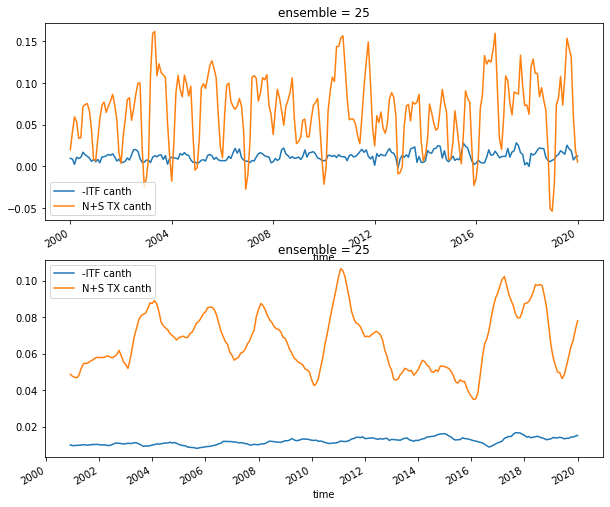

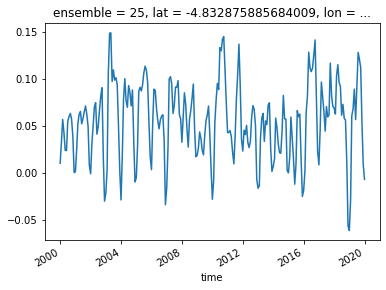

In [93]:
#((N_S_tx_canth+itf_canth)/1e6).plot()

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ... 

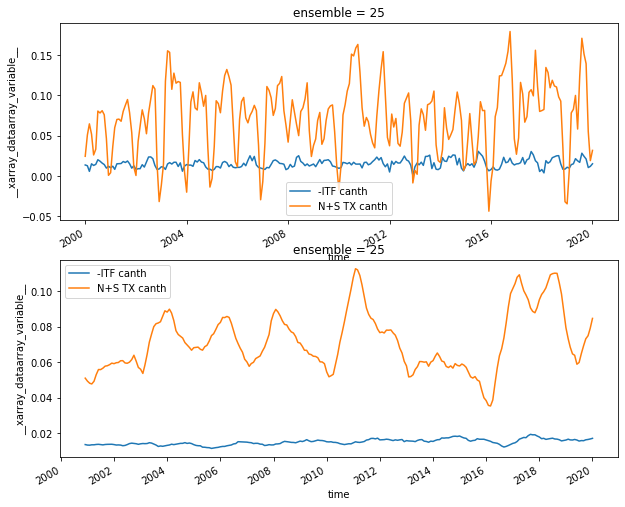

In [121]:
# Do Canth real quick??

raw_canth_area=xr.open_dataset(f'../processed_data/physics_ds/canth_raw_area_jul5.nc').__xarray_dataarray_variable__
anth_dic_area_u_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/raw_canth_area_u_transport.nc').__xarray_dataarray_variable__.chunk('auto')
anth_dic_area_v_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/raw_canth_area_v_transport.nc').__xarray_dataarray_variable__.chunk('auto')

anth_dic_area_u_tx_gm=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/raw_canth_area_u_transport_gm.nc').__xarray_dataarray_variable__.chunk('auto')
anth_dic_area_v_tx_gm=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/raw_canth_area_v_transport_gm.nc').__xarray_dataarray_variable__.chunk('auto')

#((x*60*60*24*365*12)/1e18)
canth_u=(((anth_dic_area_u_tx+anth_dic_area_u_tx_gm)*60*60*24*365*12)/1e18)/1e6
canth_v=(((anth_dic_area_v_tx+anth_dic_area_v_tx_gm)*60*60*24*365*12)/1e18)/1e6

#canth_u=(((anth_dic_u_tx_fulldep)*60*60*24*365*12)/1e18)
#canth_v=(((anth_dic_v_tx_fulldep)*60*60*24*365*12)/1e18)

N_transport_canth=-canth_v.sel(lat=5,method='nearest').sel(time=slice('2000-01-01','2020-01-01')).sel(lon=slice(120,290))
S_transport_canth=-canth_v.sel(lat=-5,method='nearest').sel(time=slice('2000-01-01','2020-01-01')).sel(lon=slice(140,290))
N_S_tx_canth=(-N_transport_canth.sum(['st_ocean','lon'])+S_transport_canth.sum(['st_ocean','lon']))
itf1_canth=canth_u.sel(lat=-5,method='nearest').sel(lon=slice(120,140),time=slice('2000-01-01','2020-01-01'))
itf2_canth=canth_v.sel(lon=120,method='nearest').sel(lat=slice(-5,5),time=slice('2000-01-01','2020-01-01'))
itf_canth=(itf1_canth.sum(['st_ocean','lon'])+itf2_canth.sum(['st_ocean','lat']))#.sum(['st_ocean','lat_x  #N_S_tx


plt.figure(figsize=(10,8))
plt.subplot(211)
(-itf_canth).plot()
N_S_tx_canth.plot()
plt.legend(['-ITF canth','N+S TX canth'])
plt.subplot(212)
(-itf_canth).rolling(time=12).mean().plot()
N_S_tx_canth.rolling(time=12).mean().plot()
plt.legend(['-ITF canth','N+S TX canth'])

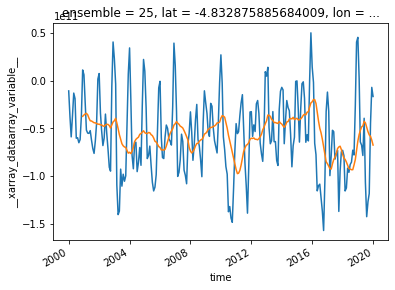

In [27]:
(itf_canth+N_S_tx_canth).plot()
(itf_canth+N_S_tx_canth).rolling(time=12).mean().plot()


In [28]:
n=-N_transport_canth.sum(['st_ocean','lon'])
s=S_transport_canth.sum(['st_ocean','lon'])
#itf_canth

In [29]:
print(n.mean().values)
print(s.mean().values)
print(itf_canth.mean().values)

-12086205688.609577
-59517610455.96899
15097527264.686314


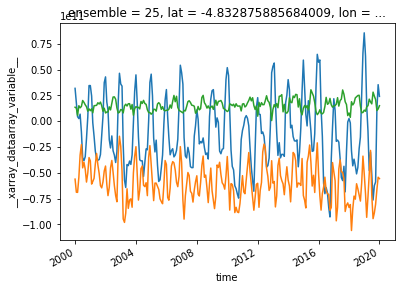

In [30]:
n.plot()
s.plot()
itf_canth.plot()

In [ ]:
(itf_canth+N_S_tx_canth).rolling(time=12).mean().plot()

In [37]:
(itf_canth+N_S_tx_canth).rolling(time=12).mean().mean().values

array(-0.05671168)

In [124]:
co1=(((-cafe_co2_anth*area_m2).sel(lat=slice(-5,5),time=slice('2000','2020')).sum(['lat','lon']))*12*60*60*24*365)/1e18

NameError: name 'raw_canth_area' is not defined

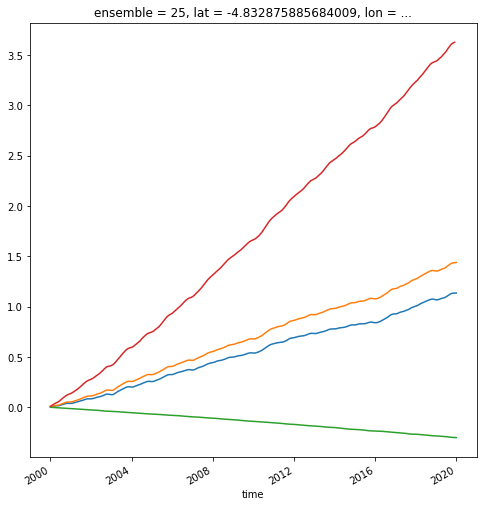

In [125]:
#(itf_canth+N_S_tx_canth).rolling(time=12).mean().plot()
plt.figure(figsize=(8,8))
((-itf_canth+N_S_tx_canth).cumsum()/12).plot()
#(-(itf_canth+N_S_tx_canth).rolling(time=12).mean().cumsum()/12).plot()
((N_S_tx_canth).cumsum()/12).plot()
((-itf_canth).cumsum()/12).plot()

(((itf_canth+N_S_tx_canth)+co1).cumsum()/12).plot()
#((-(itf_canth+N_S_tx_canth)+co1).rolling(time=12).mean().cumsum()/12).plot()
anth_c=-raw_canth_area.sel(time=slice('2000-01-01','2019-12-31'),lat=slice(-5,5))#.adic-raw_carbon_area.dic
(((anth_c-anth_c.values[0]).sum(['lat','lon','st_ocean'])*12)/1e18).plot(c='r')
plt.legend(['ITF+NS Canth cumsum','NS Canth cumsum','itf cumsum','itf+ns+co2 flux Canth','Canth accumulation DIC'])
plt.xlabel('Time')
plt.ylabel('PgCanth Accumulation')

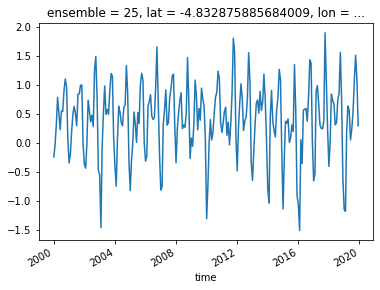

In [67]:
((-itf_canth+N_S_tx_canth+co1)).plot()

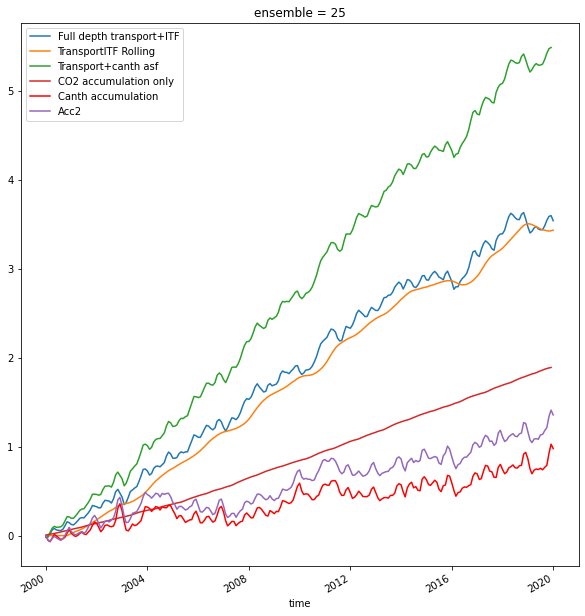

In [31]:
co1=(((-cafe_co2_anth*area_m2).sel(lat=slice(-5,5),time=slice('2000','2020')).sum(['lat','lon']))*12*60*60*24*365)/1e18
vals=(((tot_anth_dic_cafe).sel(lat=slice(-5,5),lon=slice(160,280)).sum(['lon','lat','st_ocean'])*12)/1e18)#.plot()
vals=vals.sel(time=slice('2000-01-01','2020-01-01'))

plt.figure(figsize=(10,10))
((itf_canth+N_S_tx_canth).cumsum()/12).plot()
((itf_canth+N_S_tx_canth).rolling(time=12).mean().cumsum()/12).plot()
#((itf_canth+N_S_tx_canth-co1).cumsum()/12).plot()
((itf_canth+N_S_tx_canth+co1).cumsum()/12).plot()
((co1).cumsum()/12).plot()
(vals-vals.values[0]).plot(c='r')

anth_c=raw_carbon_area.adic-raw_carbon_area.dic
(((anth_c-anth_c.values[0]).sum(['lat','lon','st_ocean'])*12)/1e18).plot()
#(((anth_c-anth_c.values[0]).sel(st_ocean=slice(0,300)).sum(['lat','lon','st_ocean'])*12)/1e18).plot()

plt.legend(['Full depth transport+ITF','TransportITF Rolling','Transport+canth asf','CO2 accumulation only','Canth accumulation','Acc2','Acc2 300m'])

#((itf_canth+N_S_tx_canth).rolling(time=12).mean().cumsum()/12).plot()

In [ ]:
# Region Mask

In [ ]:
cutout=((tot_anth_dic_cafe.sel(lat=slice(-5,5),lon=slice(160,280)).sel(time=slice('2000-01-01','2020-01-01')))).sum(['lat','lon'])#,'st_ocean'])
baseline=cutout.sel(time='2000-01-01',method='nearest')
(((cutout-baseline).sel(st_ocean=slice(0,-50)).mean(dim='st_ocean')*12)/1e18).rolling(time=12).mean().plot()
(((cutout-baseline).sel(st_ocean=slice(-50,-300)).mean(dim='st_ocean')*12)/1e18).rolling(time=12).mean().plot()
plt.legend(['Surface AnthC','Subsurface AnthC'])
plt.title('Anthropogenic Carbon accumulation since 2000 (PgC)')

In [ ]:
cutout=((tot_anth_dic_cafe.sel(lat=slice(-5,5),lon=slice(160,280)).sel(time=slice('2000-01-01','2020-01-01')))).sum(['lat','lon'])#,'st_ocean'])
baseline=cutout.sel(time='2000-01-01',method='nearest')
(((cutout-baseline).sel(st_ocean=slice(0,-50)).sum(dim='st_ocean')*12)/1e18).rolling(time=12).mean().plot()
(((cutout-baseline).sel(st_ocean=slice(-50,-300)).sum(dim='st_ocean')*12)/1e18).rolling(time=12).mean().plot()
plt.legend(['Surface AnthC','Subsurface AnthC'])
plt.title('Anthropogenic Carbon accumulation since 2000 (PgC)')

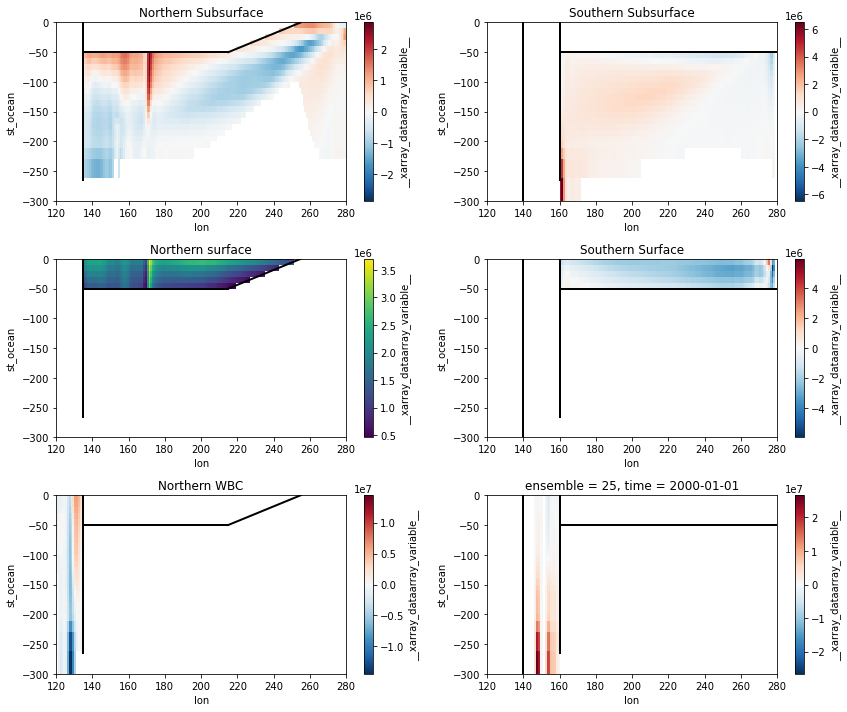

In [29]:
## Check Mask
plt.figure(figsize=(12,10))
plt.subplot(321)
anth_dic_v_tx.sel(lat=5,method='nearest').mean(dim='time').where(mask.north_subsurface.sel(lat=5,method='nearest')==1).sel(time='2000-01-01').plot()
plt.xlim([120,280])
plt.ylim([-300,0])
plt.title('Northern Subsurface')
plt.plot([135,215],[-50,-50],c='k',linewidth=2)
plt.plot([215,255],[-50,-0],c='k',linewidth=2)
plt.plot([115,115],[-400,0],c='k',linewidth=2)
plt.plot([135,135],[-265,0],c='k',linewidth=2)


plt.subplot(323)
anth_dic_v_tx.sel(lat=5,method='nearest').mean(dim='time').where(mask.north_surface.sel(lat=5,method='nearest')==1).sel(time='2000-01-01').plot()
plt.xlim([120,280])
plt.title('Northern surface')
plt.ylim([-300,0])
plt.plot([135,215],[-50,-50],c='k',linewidth=2)
plt.plot([215,255],[-50,-0],c='k',linewidth=2)
plt.plot([115,115],[-400,0],c='k',linewidth=2)
plt.plot([135,135],[-265,0],c='k',linewidth=2)


plt.subplot(325)
anth_dic_v_tx.sel(lat=5,method='nearest').mean(dim='time').where(mask.north_wbc.sel(lat=5,method='nearest')==1).sel(time='2000-01-01').plot()
plt.xlim([120,280])
plt.ylim([-300,0])
plt.plot([135,215],[-50,-50],c='k',linewidth=2)
plt.plot([215,255],[-50,-0],c='k',linewidth=2)
plt.plot([115,115],[-400,0],c='k',linewidth=2)
plt.plot([135,135],[-265,0],c='k',linewidth=2)

plt.title('Northern WBC')


## Check Mask
#plt.figure(figsize=(12,8))
plt.subplot(322)
anth_dic_v_tx.sel(lat=-5,method='nearest').mean(dim='time').where(mask.south_subsurface.sel(lat=-5,method='nearest')==1).sel(time='2000-01-01').plot()
plt.xlim([120,280])
plt.ylim([-300,0])
plt.plot([160,280],[-50,-50],c='k',linewidth=2)
plt.plot([140,140],[-400,0],c='k',linewidth=2)
plt.plot([160,160],[-265,0],c='k',linewidth=2)
plt.title('Southern Subsurface')

plt.subplot(324)
anth_dic_v_tx.sel(lat=-5,method='nearest').mean(dim='time').where(mask.south_surface.sel(lat=-5,method='nearest')==1).sel(time='2000-01-01').plot()
plt.xlim([120,280])
plt.title('Southern Surface')
plt.ylim([-300,0])
plt.plot([160,280],[-50,-50],c='k',linewidth=2)
plt.plot([140,140],[-400,0],c='k',linewidth=2)
plt.plot([160,160],[-265,0],c='k',linewidth=2)

plt.subplot(326)
anth_dic_v_tx.sel(lat=-5,method='nearest').mean(dim='time').where(mask.south_wbc.sel(lat=-5,method='nearest')==1).sel(time='2000-01-01').plot()
plt.xlim([120,280])
plt.ylim([-300,0])
plt.plot([160,280],[-50,-50],c='k',linewidth=2)
plt.plot([140,140],[-400,0],c='k',linewidth=2)
plt.plot([160,160],[-265,0],c='k',linewidth=2)


plt.tight_layout()
plt.show()

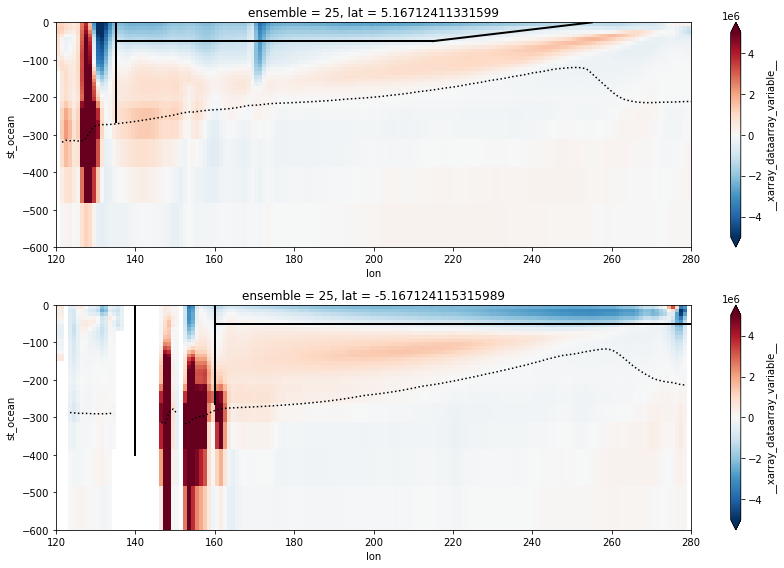

In [59]:
plt.figure(figsize=(12,8))
plt.subplot(221)

(-anth_dic_v_tx).sel(lat=5,method='nearest').mean(dim='time').plot(vmin=-0.5e7,vmax=0.5e7,cmap='RdBu_r')#sel(time='2000-01-01').plot()
plt.xlim([120,280])
plt.ylim([-600,0])
plt.plot([135,215],[-50,-50],c='k',linewidth=2)
plt.plot([215,255],[-50,-0],c='k',linewidth=2)
plt.plot([115,115],[-400,0],c='k',linewidth=2)
plt.plot([135,135],[-265,0],c='k',linewidth=2)
plt.title('Meridional aDIC transport 5N')
cafe_potential_density.chunk('auto').sel(lat=5,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')

                
plt.subplot(222)

anth_dic_v_tx.sel(lat=-5,method='nearest').mean(dim='time').plot(vmin=-0.5e7,vmax=0.5e7,cmap='RdBu_r')#sel(time='2000-01-01').plot()
plt.xlim([120,280])
plt.ylim([-600,0])
plt.plot([160,280],[-50,-50],c='k',linewidth=2)
plt.plot([140,140],[-400,0],c='k',linewidth=2)
plt.plot([160,160],[-265,0],c='k',linewidth=2)
plt.title('Meridional aDIC transport 5S')
cafe_potential_density.chunk('auto').sel(lat=-5.1,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')
                    
plt.tight_layout()



# Calculate Zeller Table; Surfaces.

In [38]:
anth_dic_v_tx

<xarray.DataArray '__xarray_dataarray_variable__' (time: 731, st_ocean: 30, lat: 141, lon: 170)>
dask.array<mul, shape=(731, 30, 141, 170), dtype=float32, chunksize=(103, 30, 103, 85), chunktype=numpy.ndarray>
Coordinates:
    ensemble  int32 25
  * st_ocean  (st_ocean) float64 -5.0 -15.0 -25.0 -35.0 ... -665.4 -812.8 -969.1
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -39.9 -38.92 -37.95 -36.96 ... 37.9 38.86 39.81

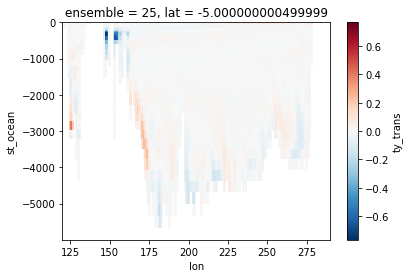

In [87]:
# PANDAS ADVANCED NOTES
# Multi Indexing
# Melt and Pvivot
# SQL
data_type.mean(dim='time').sel(lat=-5,method='nearest').plot()

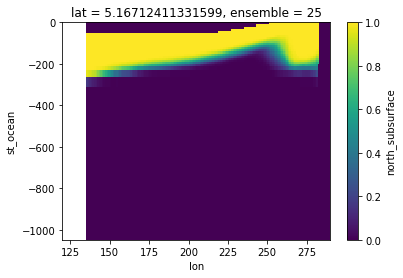

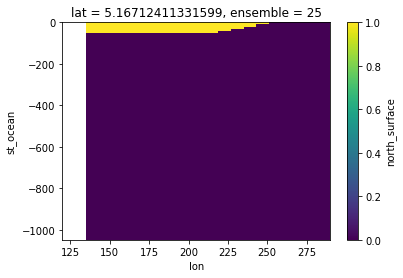

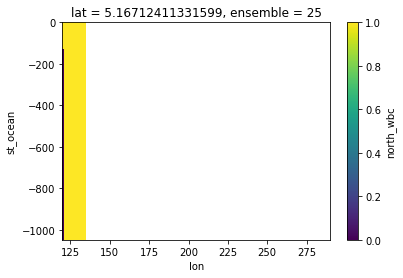

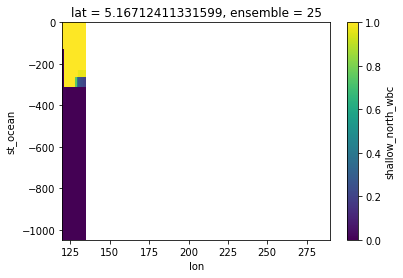

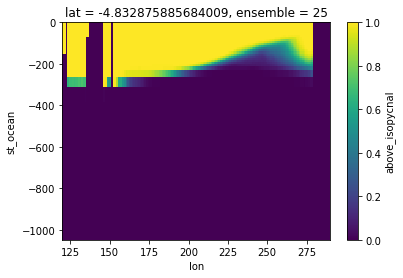

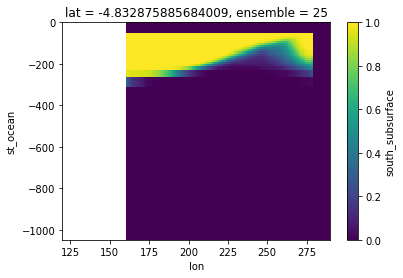

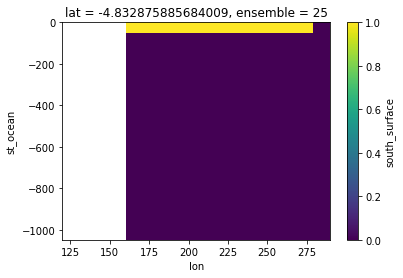

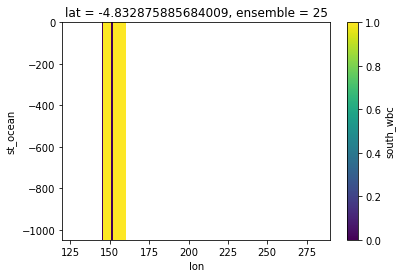

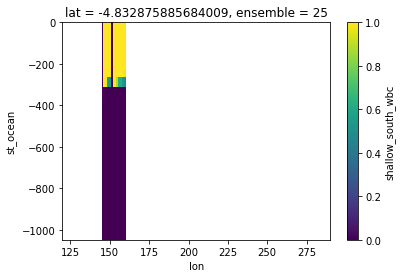

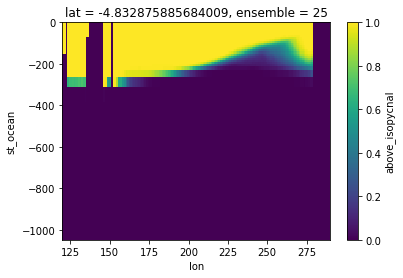

In [61]:
masksZ=[region_mask.north_subsurface,region_mask.north_surface,region_mask.north_wbc,region_mask.shallow_north_wbc,region_mask.above_isopycnal,region_mask.south_subsurface,region_mask.south_surface,region_mask.south_wbc,region_mask.shallow_south_wbc,region_mask.above_isopycnal]

for i,mask in enumerate(masksZ):
    if i>=4:
        mask.mean(dim='time').sel(lat=-5,method='nearest').plot()
    else:
        mask.mean(dim='time').sel(lat=5,method='nearest').plot()
    plt.show()

In [19]:
#cafe_y_tx_fulldep.sel(lat_x=-5,method='nearest').sel(lon=slice(140,300)).mean(dim='time').sum().values

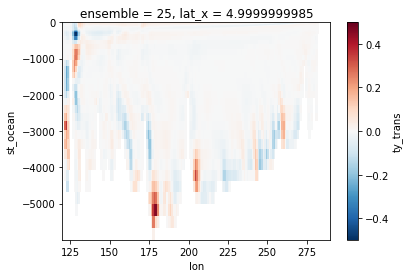

In [106]:
cafe_y_tx_fulldep.sel(lat_x=5,method='nearest').mean(dim='time').plot().sum().values

In [101]:
cafe_y_tx_fulldep.sel(lat_x=5,method='nearest').sel(st_ocean=slice(0,-1000)).mean(dim='time').sum().values

array(7.2466326, dtype=float32)

In [102]:
cafe_y_tx_fulldep.sel(lat_x=-5,method='nearest').sel(st_ocean=slice(0,-1000)).mean(dim='time').sum().values

array(11.446735, dtype=float32)

In [28]:
anth_dic_area_u_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/raw_canth_area_u_transport.nc').__xarray_dataarray_variable__.chunk('auto')
anth_dic_area_v_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/raw_canth_area_v_transport.nc').__xarray_dataarray_variable__.chunk('auto')

anth_dic_area_u_tx_gm=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/raw_canth_area_u_transport_gm.nc').__xarray_dataarray_variable__.chunk('auto')
anth_dic_area_v_tx_gm=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/raw_canth_area_v_transport_gm.nc').__xarray_dataarray_variable__.chunk('auto')

#((x*60*60*24*365*12)/1e18)
canth_u=(((anth_dic_area_u_tx)*60*60*24*365*12)/1e18)/1e6
canth_v=(((anth_dic_area_v_tx)*60*60*24*365*12)/1e18)/1e6
canth_u_andgm=(((anth_dic_area_u_tx+anth_dic_area_u_tx_gm)*60*60*24*365*12)/1e18)/1e6
canth_v_andgm=(((anth_dic_area_v_tx+anth_dic_area_v_tx_gm)*60*60*24*365*12)/1e18)/1e6


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ... 

In [32]:
# Could do Mean , or SUM
# Apply modifications to varz ? (to petagrams for the dic ones?) 

ev=[None,neutral_events,ep_events,cp_events,nina_events]
evName=['Alltime','Neutral','EP','CP','La Nina']
region_mask=region_mask.load()
#masksN=[region_mask.north_subsurface,region_mask.north_surface,region_mask.north_wbc,region_mask.above_isopycnal,None]#,None,None]
#masksS=[region_mask.south_subsurface,region_mask.south_surface,region_mask.south_wbc,region_mask.above_isopycnal,None]#,None,None]
masksN=[region_mask.north_subsurface,region_mask.north_surface,region_mask.north_wbc,region_mask.shallow_north_wbc,region_mask.above_isopycnal,None]#,None,None]
masksS=[region_mask.south_subsurface,region_mask.south_surface,region_mask.south_wbc,region_mask.shallow_south_wbc,region_mask.above_isopycnal,None]#,None,None]
direction=[5,-5]
dir_names=['5N','5S']
#variables to calcuulate
mask_names=['Subsurface','Surface','WBC','ShallowWBC','Above Isotherm','fulldep']


#(1e9*60*60*24*365*12)/1e18
# Transport n

varz_total=[(cafe_y_tx.rename({'lat_x':'lat'})),
            (cafe_y_tx.rename({'lat_x':'lat'})+(cafe_y_tx_gm.rename({'lat_x':'lat'}))),
            canth_u,
            canth_u_andgm]
            #(anth_dic_v_tx*60*60*24*365*12)/1e18,
      #(dic_v_tx*60*60*24*365*12)/1e18,
      #((anth_dic_v_tx+anth_dic_v_tx_gm)*60*60*24*365*12)/1e18,
      #(cafe_y_tx_fulldep.rename({'lat_x':'lat'}))]


table_y_tx=(cafe_y_tx.rename({'lat_x':'lat'}))
table_y_tx_gm=(cafe_y_tx.rename({'lat_x':'lat'})+(cafe_y_tx_gm.rename({'lat_x':'lat'})))
table_y_tx_fulldep=(cafe_y_tx_fulldep.rename({'lat_x':'lat'}))
table_adic_tx=(anth_dic_v_tx*60*60*24*365*12)/1e18
table_adic_tx_gm=((anth_dic_v_tx+anth_dic_v_tx_gm)*60*60*24*365*12)/1e18
table_dic_tx=(dic_v_tx*60*60*24*365*12)/1e18
table_adic=anth_dic_cafe #mmolC/m3
table_adic_accumulation=tot_anth_dic_cafe


print('loading data')
table_y_tx=table_y_tx.sel(lat=[-5,5],method='nearest').load()
table_y_tx_gm=table_y_tx_gm.sel(lat=[-5,5],method='nearest').load()
table_y_tx_fulldep=table_y_tx_fulldep.sel(lat=[-5,5],method='nearest').load()
table_adic_tx=table_adic_tx.sel(lat=[-5,5],method='nearest').load()
table_adic_tx_gm=table_adic_tx_gm.sel(lat=[-5,5],method='nearest').load()
table_dic_tx=table_dic_tx.sel(lat=[-5,5],method='nearest').load()
table_adic=table_adic.sel(lat=[-5,5],method='nearest').load()
table_adic_accumulation=table_adic_accumulation.sel(lat=[-5,5],method='nearest').load()
canth_u_load=canth_u.sel(lat=[-5,5],method='nearest').load()
canth_u_andgm_load=canth_u_andgm.sel(lat=[-5,5],method='nearest').load()
print('loaded data')
#depth_reg.load()

varz_mean=[table_y_tx,
          table_y_tx_gm,
          table_y_tx_fulldep,
          canth_u_load.interp(lon=table_y_tx.lon),
          canth_u_andgm_load.interp(lon=table_y_tx.lon)] 
          #table_adic_tx,
          #table_adic_tx_gm,
          #table_dic_tx]
varz=varz_mean
method='mean' #'total #Syn #std
var_names=['Meridional Transport','Meridional+GM transport','full depth transport','AnthC transport','AnthC+GM transport']#,'C transport','adic','adic_accumulation']

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ... 

loading data
loaded data


In [56]:
#table_y_tx=(cafe_y_tx.rename({'lat_x':'lat'})).sel(lat=5,method='nearest').where(region_mask.above_isopycnal.sel(lat=5,method='nearest')==1)#.mean(dim='time').plot()

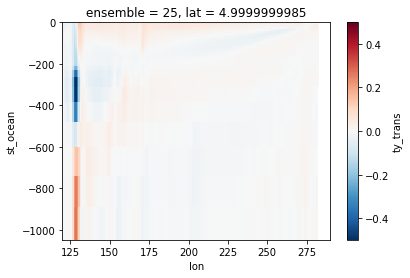

In [75]:
table_y_tx.mean(dim='time').sel(lat=5,method='nearest').plot()#,sel(lat=5

In [87]:
table_y_tx.sel(lat=5,method='nearest').where(region_mask.north_wbc_subsurface.sel(lat=5,method='nearest')==1). sum(['st_ocean','lon']).sel(time=slice('2000','2020')).mean(dim='time')

<xarray.DataArray 'ty_trans' ()>
array(-14.916776, dtype=float32)
Coordinates:
    ensemble  int32 25

In [84]:
table_y_tx.sel(lat=5,method='nearest').where(region_mask.north_wbc.sel(lat=5,method='nearest')==1).mean(dim='time').sum()

<xarray.DataArray 'ty_trans' ()>
array(-7.819889, dtype=float32)
Coordinates:
    ensemble  int32 25

In [85]:
table_y_tx.sel(lat=5,method='nearest').where(region_mask.north_subsurface.sel(lat=5,method='nearest')==1).mean(dim='time').sum()

<xarray.DataArray 'ty_trans' ()>
array(-16.09974, dtype=float32)
Coordinates:
    ensemble  int32 25

In [41]:

varz_mean=[table_y_tx,
          table_y_tx_gm,
          table_y_tx_fulldep,
          canth_u_load.interp(lon=table_y_tx.lon),
          canth_u_andgm_load.interp(lon=table_y_tx.lon)] 
          #table_adic_tx,
          #table_adic_tx_gm,
          #table_dic_tx]
varz=varz_mean
method='mean' #'total #Syn #std
var_names=['Meridional Transport','Meridional+GM transport','full depth transport','AnthC transport','AnthC+GM transport']#,'C transport','adic','adic_accumulation']

In [40]:
#canth_u_load.interp(lon=table_y_tx.lon)#canth_u_load#_andgm

<xarray.DataArray '__xarray_dataarray_variable__' (time: 481, st_ocean: 50, lat: 2, lon: 170)>
array([[[[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan, -3.77994038e-06, -6.27212618e-06, ...,
                      nan,             nan,             nan]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan, -8.99227971e-06, -1.36501235e-05, ...,
                      nan,             nan,             nan]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan, -1.04397608e-05, -1.50564970e-05, ...,
                      nan,             nan,             nan]],

        ...,

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
...
                      nan,             nan,             nan],
         [            nan,  2.68871482e-05,  3.58335128e-05, ...,
                      nan,             nan,             nan]],

        ...,

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]]]])
Coordinates:
  * time        (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2020-01-01
    ensemble    int32 25
  * st_ocean    (st_ocean) float64 -5.0 -15.0 -25.0 ... -5.499e+03 -5.831e+03
  * lat         (lat) float64 -4.833 5.167
    depth_diff  (st_ocean) float64 -5.0 -10.0 -10.0 ... -323.6 -333.1 -332.0
  * lon         (lon) float64 120.5 121.5 122.5 123.5 ... 287.5 288.5 289.5

In [58]:
#table_y_tx.sel(lat=5,method='nearest'where(region_mask.shallow_south_wbc
                                           
#depth_reg=region_mask.shallow_north_wbc.sel(lat=5,method='nearest')
#table_y_tx.sel(lat=5,method='nearest').where(depth_reg==1).sum(dim=['st_ocean','lon']).mean(dim='time').values

In [42]:
#method='std' # or mean
region_mask['south_wbc_subsurface']=xr.concat([region_mask.south_wbc,region_mask.south_subsurface],dim='regions').max(dim='regions')#.sel(lat=-5,method='nearest').mean(dim='time').plot()
region_mask['north_wbc_subsurface']=xr.concat([region_mask.north_wbc,region_mask.north_subsurface],dim='regions').max(dim='regions')#.sel(lat=-5,method='nearest').mean(dim='time').plot()
region_mask['south_shallowwbc_subsurface']=xr.concat([region_mask.shallow_south_wbc,region_mask.south_subsurface],dim='regions').max(dim='regions')#.sel(lat=-5,method='nearest').mean(dim='time').plot()
region_mask['north_shallowwbc_subsurface']=xr.concat([region_mask.shallow_north_wbc,region_mask.north_subsurface],dim='regions').max(dim='regions')#.sel(lat=-5,method='nearest').mean(dim='time').plot()

masksN=[region_mask.north_subsurface,region_mask.north_surface,region_mask.north_wbc,region_mask.shallow_north_wbc,region_mask.north_wbc_subsurface,region_mask.north_shallowwbc_subsurface,region_mask.above_isopycnal,None]#,None,None]
masksS=[region_mask.south_subsurface,region_mask.south_surface,region_mask.south_wbc,region_mask.shallow_south_wbc,region_mask.south_wbc_subsurface,region_mask.south_shallowwbc_subsurface,region_mask.above_isopycnal,None]#,None,None]
direction=[5,-5]
dir_names=['5N','5S']
mask_names=['Subsurface','Surface','WBC','ShallowWBC','WBC+Interior','ShallowWBC+Interior','Above Isotherm','fulldep']#'positive','negative']

In [69]:
for method in ['std','mean']:
    df_holder=[]
    for iENSO,enso_dates in enumerate(ev):
        enso_name=evName[iENSO]
        for var_i,data_type in enumerate(varz):

            data_type=data_type.sel(time=slice('2000','2020'))
            if enso_dates is not None:
                data_type=data_type.sel(time=enso_dates)
                
                
            df_row_holder=[]
            for i,NS in enumerate(direction):
                if i==0: # North
                    mask_holder=masksN
                    #data_type=data_type*-1
                elif i==1: # South
                    mask_holder=masksS
                    data_type=data_type.sel(lon=slice(140,300)) # REMOVE ITF FROM S FACE
                    
                    
                for depth_i,depth_region in enumerate(mask_holder):
                    var_name=var_names[var_i]
                    depth_name=mask_names[depth_i]
                    direction_name = dir_names[i]


                    d=None
                    if depth_name=='fulldep':
                        if method=='mean':
                            d=data_type.sel(lat=NS,method='nearest').sum(dim=['st_ocean','lon']).mean(dim='time').values
                        elif method=='std':
                            d=data_type.sel(lat=NS,method='nearest').sum(dim=['st_ocean','lon']).std(dim='time').values
                        elif method=='sum':
                            d=data_type.sel(lat=NS,method='nearest').sum(dim='time').sum().values
                    elif depth_name=='positive': 
                        d=data_type.sel(lat=NS,method='nearest')
                        if method=='mean':
                            d=d.where(d>=0).sum(dim=['st_ocean','lon']).mean(dim='time').values
                        elif method=='std':
                            d=d.where(d>=0).sum(dim=['st_ocean','lon']).std(dim='time').values
                        elif method=='sum':
                            d=d.where(d>=0).sum(dim='time').sum().values

                    elif depth_name=='negative':
                        d=data_type.sel(lat=NS,method='nearest')
                        if method=='mean':  
                            d=d.where(d<0).sum(dim=['st_ocean','lon']).mean(dim='time').values  
                        elif method=='std':  
                            d=d.where(d<0).sum(dim=['st_ocean','lon']).std(dim='time').values  
                        elif method=='sum':  
                            d=d.where(d<0).sum(dim='time').sum().values  

                    if mask_holder[depth_i] is not None:
                        depth_reg=mask_holder[depth_i].sel(lat=NS,method='nearest')                           
                        
                        if method=='mean': 
                            d=data_type.sel(lat=NS,method='nearest').where(depth_reg==1).sum(dim=['st_ocean','lon']).mean(dim='time').values
                            
                            #if depth_name=='WBC+Interior':
                            #    brekkkknow
                        elif method=='std': 
                            d=data_type.sel(lat=NS,method='nearest').where(depth_reg==1).sum(dim=['st_ocean','lon']).std(dim='time').values
                        elif method=='sum': 
                            d=data_type.sel(lat=NS,method='nearest').where(depth_reg==1).sum(dim='time').sum().values

                    if i==0: #North
                        d*=-1
                    #print(f'{var_name}{direction_name} {depth_name} {enso_name} {method} {d}')

                    df_row_holder.append(pd.DataFrame(data={var_name:d},index=pd.MultiIndex.from_tuples([(depth_name,direction_name,enso_name)])))

                    #pd.DataFrame({title:name={depth_name} 

                df_holder.append(pd.concat(df_row_holder))


    table1=pd.concat(df_holder,axis=0,join='outer')#.dropna(thresh=10,axis=1)
    table1=table1.groupby(level=[0,1,2]).mean()
    table1.to_csv(f'transport_numbers_{method}_may31.csv')
table1

#comparison_table=pd.concat(df_holder,axis=1).dropna(thresh=10,axis=1)
#comparison_table.to_csv(f'transport_numbers_{method}.csv')
#comparison_table

Meridional Transport  Meridional+GM transport  \
Above Isotherm 5N Alltime             -7.256654                 0.128679   
                  CP                 -12.604925                -5.372183   
                  EP                 -13.189171                -6.265187   
                  La Nina             -5.916248                 1.866442   
                  Neutral             -5.987095                 1.245671   
...                                         ...                      ...   
fulldep        5S Alltime             14.499454                20.821978   
                  CP                  15.728070                21.464766   
                  EP                  10.948726                16.297552   
                  La Nina             16.273724                23.133429   
                  Neutral             13.573627                19.808661   

                           full depth transport  AnthC transport  \
Above Isotherm 5N Alltime             -7.256654         0.032644   
                  CP                 -12.604925         0.012085   
                  EP                 -13.189171         0.056634   
                  La Nina             -5.916248         0.027459   
                  Neutral             -5.987095         0.036099   
...                                         ...              ...   
fulldep        5S Alltime             13.795323         0.096215   
                  CP                  13.403457         0.151985   
                  EP                  12.350732         0.117165   
                  La Nina             14.444661         0.080159   
                  Neutral             13.744720         0.091037   

                           AnthC+GM transport  
Above Isotherm 5N Alltime            0.033272  
                  CP                 0.013426  
                  EP                 0.056320  
                  La Nina            0.028343  
                  Neutral            0.036563  
...                                       ...  
fulldep        5S Alltime            0.092131  
                  CP                 0.145255  
                  EP                 0.109436  
                  La Nina            0.076572  
                  Neutral            0.087650  

[80 rows x 5 columns]

In [70]:
# First and last columns are Mean Sverdrup. DIC (Three middle columns) is all in mean PgC/yr
# Numbers are RELATIVE to box

In [71]:
# Load the Table

indexes=pd.MultiIndex.from_tuples((
            ('SubsurfaceWBC', '5N', 'Alltime'),
            (      'SubsurfaceWBC', '5N',      'CP'),
            (      'SubsurfaceWBC', '5N',      'EP'),
            (      'SubsurfaceWBC', '5N', 'La Nina'),
            (      'SubsurfaceWBC', '5N', 'Neutral'),
            (      'SubsurfaceWBC', '5S', 'Alltime'),
            (      'SubsurfaceWBC', '5S',      'CP'),
            (      'SubsurfaceWBC', '5S',      'EP'),
            (      'SubsurfaceWBC', '5S', 'La Nina'),
            (      'SubsurfaceWBC', '5S', 'Neutral')))

table=pd.read_csv('transport_numbers_mean_may31.csv',index_col=[0,1,2])
subsurface=(table.loc['Subsurface']+table.loc['ShallowWBC']).set_index(indexes)

table=table.append(subsurface)
#table


tablestd=pd.read_csv('transport_numbers_std_may31.csv',index_col=[0,1,2])
subsurfacestd=(tablestd.loc['Subsurface']+tablestd.loc['ShallowWBC']).set_index(indexes)
#subsurfacestd=(tablestd.loc['Subsurface']+tablestd.loc['WBC']).set_index(indexes)

tablestd=tablestd.append(subsurfacestd)
tablestd

Meridional Transport  Meridional+GM transport  \
Above Isotherm 5N Alltime            -30.138243               -26.618692   
                  CP                 -34.122185               -30.404903   
                  EP                 -39.007416               -34.771706   
                  La Nina            -25.197197               -21.610481   
                  Neutral            -30.387510               -26.990042   
...                                         ...                      ...   
SubsurfaceWBC  5S Alltime             17.612264                17.496715   
                  CP                  17.139744                17.016387   
                  EP                  17.530137                17.275003   
                  La Nina             17.844243                17.682525   
                  Neutral             16.843623                16.853114   

                           full depth transport  AnthC transport  \
Above Isotherm 5N Alltime            -30.138243        -0.066543   
                  CP                 -34.122185        -0.068087   
                  EP                 -39.007416        -0.078225   
                  La Nina            -25.197197        -0.069026   
                  Neutral            -30.387510        -0.060250   
...                                         ...              ...   
SubsurfaceWBC  5S Alltime             17.612265         0.030304   
                  CP                  17.139745         0.028811   
                  EP                  17.530136         0.030073   
                  La Nina             17.844242         0.030310   
                  Neutral             16.843623         0.028347   

                           AnthC+GM transport  
Above Isotherm 5N Alltime           -0.063972  
                  CP                -0.065439  
                  EP                -0.074377  
                  La Nina           -0.066614  
                  Neutral           -0.057881  
...                                       ...  
SubsurfaceWBC  5S Alltime            0.030300  
                  CP                 0.028778  
                  EP                 0.030031  
                  La Nina            0.030345  
                  Neutral            0.028371  

[90 rows x 5 columns]

In [72]:
#tablestd.reset_index().query("level_0=='Above Isotherm' & level_2=='Alltime'").sum()#.groupby('level_0').sum()

table.reset_index().query("level_2=='Alltime'")#Meridional Transport5N WBC Alltime -11.22204113

level_0 level_1  level_2  Meridional Transport  \
0        Above Isotherm      5N  Alltime             -7.256654   
5        Above Isotherm      5S  Alltime              4.034557   
10           ShallowWBC      5N  Alltime              7.679049   
15           ShallowWBC      5S  Alltime             12.574190   
20  ShallowWBC+Interior      5N  Alltime             14.032353   
25  ShallowWBC+Interior      5S  Alltime             28.927626   
30           Subsurface      5N  Alltime              6.353304   
35           Subsurface      5S  Alltime             16.353436   
40              Surface      5N  Alltime            -21.289007   
45              Surface      5S  Alltime            -24.893068   
50                  WBC      5N  Alltime              8.812309   
55                  WBC      5S  Alltime             23.375227   
60         WBC+Interior      5N  Alltime             15.165614   
65         WBC+Interior      5S  Alltime             39.728664   
70              fulldep      5N  Alltime             -7.412943   
75              fulldep      5S  Alltime             14.499455   
80        SubsurfaceWBC      5N  Alltime             14.032353   
85        SubsurfaceWBC      5S  Alltime             28.927626   

    Meridional+GM transport  full depth transport  AnthC transport  \
0                  0.128679             -7.256654         0.032644   
5                 10.801477              4.034557         0.115960   
10                 7.996141              7.679049        -0.000723   
15                12.911989             12.574190         0.004554   
20                14.097589             14.032353         0.028438   
25                28.915852             28.927626         0.078691   
30                 6.101448              6.353304         0.029161   
35                16.003864             16.353436         0.074136   
40               -13.968909            -21.289007         0.004206   
45               -18.114374            -24.893068         0.037270   
50                 9.144621              8.812309        -0.003356   
55                23.690804             23.375227        -0.001823   
60                15.246068             15.165614         0.025804   
65                39.694664             39.728664         0.072314   
70                 0.107540             -2.527329        -0.011355   
75                20.821978             13.795323         0.096215   
80                14.097588             14.032353         0.028438   
85                28.915853             28.927626         0.078691   

    AnthC+GM transport  
0             0.033272  
5             0.110467  
10           -0.000720  
15            0.004374  
20            0.028410  
25            0.078789  
30            0.029129  
35            0.074415  
40            0.004863  
45            0.031678  
50           -0.003383  
55           -0.001981  
60            0.025747  
65            0.072434  
70           -0.007240  
75            0.092131  
80            0.028410  
85            0.078789

In [73]:
tablestd.reset_index().query("level_2=='Alltime'")

level_0 level_1  level_2  Meridional Transport  \
0        Above Isotherm      5N  Alltime            -30.138243   
5        Above Isotherm      5S  Alltime             20.413464   
10           ShallowWBC      5N  Alltime             -7.262650   
15           ShallowWBC      5S  Alltime              4.667093   
20  ShallowWBC+Interior      5N  Alltime            -20.381674   
25  ShallowWBC+Interior      5S  Alltime             14.881548   
30           Subsurface      5N  Alltime            -18.764359   
35           Subsurface      5S  Alltime             12.945171   
40              Surface      5N  Alltime            -12.196519   
45              Surface      5S  Alltime              8.790626   
50                  WBC      5N  Alltime            -11.222041   
55                  WBC      5S  Alltime              4.436150   
60         WBC+Interior      5N  Alltime            -21.662004   
65         WBC+Interior      5S  Alltime             13.497491   
70              fulldep      5N  Alltime            -31.275549   
75              fulldep      5S  Alltime             15.623730   
80        SubsurfaceWBC      5N  Alltime            -26.027009   
85        SubsurfaceWBC      5S  Alltime             17.612264   

    Meridional+GM transport  full depth transport  AnthC transport  \
0                -26.618692            -30.138243        -0.066543   
5                 21.201529             20.413464         0.042721   
10                -6.833540             -7.262650        -0.005686   
15                 4.344898              4.667093         0.003128   
20               -18.355225            -20.381674        -0.048130   
25                14.935225             14.881547         0.026708   
30               -16.795248            -18.764359        -0.044391   
35                13.151817             12.945171         0.027176   
40               -10.310166            -12.196519        -0.019581   
45                 8.699827              8.790626         0.017889   
50               -11.015221            -11.222041        -0.009973   
55                 4.183875              4.436150         0.005240   
60               -20.026825            -21.662004        -0.049430   
65                13.524527             13.497489         0.026385   
70               -28.140688             -2.914008        -0.152134   
75                16.288879              2.781505         0.091789   
80               -23.628788            -26.027009        -0.050077   
85                17.496715             17.612265         0.030304   

    AnthC+GM transport  
0            -0.063972  
5             0.040779  
10           -0.005398  
15            0.003049  
20           -0.047828  
25            0.026766  
30           -0.044314  
35            0.027251  
40           -0.017264  
45            0.015704  
50           -0.009745  
55            0.005172  
60           -0.049074  
65            0.026438  
70           -0.148155  
75            0.090932  
80           -0.049712  
85            0.030300

In [74]:
table.reset_index().query("level_2=='Alltime'").groupby('level_0').sum()

Meridional Transport  Meridional+GM transport  \
level_0                                                              
Above Isotherm                  -3.222097                10.930156   
ShallowWBC                      20.253239                20.908130   
ShallowWBC+Interior             42.959979                43.013441   
Subsurface                      22.706740                22.105312   
SubsurfaceWBC                   42.959979                43.013441   
Surface                        -46.182075               -32.083283   
WBC                             32.187536                32.835425   
WBC+Interior                    54.894278                54.940732   
fulldep                          7.086512                20.929518   

                     full depth transport  AnthC transport  AnthC+GM transport  
level_0                                                                         
Above Isotherm                  -3.222097         0.148604            0.143739  
ShallowWBC                      20.253239         0.003831            0.003654  
ShallowWBC+Interior             42.959979         0.107128            0.107199  
Subsurface                      22.706740         0.103297            0.103545  
SubsurfaceWBC                   42.959979         0.107128            0.107199  
Surface                        -46.182075         0.041476            0.036541  
WBC                             32.187536        -0.005179           -0.005364  
WBC+Interior                    54.894278         0.098118            0.098181  
fulldep                         11.267994         0.084860            0.084892

In [75]:
abs(tablestd).reset_index().query("level_2=='Alltime'").groupby('level_0').sum()

Meridional Transport  Meridional+GM transport  \
level_0                                                              
Above Isotherm                  50.551706                47.820221   
ShallowWBC                      11.929743                11.178438   
ShallowWBC+Interior             35.263222                33.290450   
Subsurface                      31.709530                29.947065   
SubsurfaceWBC                   43.639273                41.125503   
Surface                         20.987144                19.009994   
WBC                             15.658191                15.199096   
WBC+Interior                    35.159495                33.551352   
fulldep                         46.899279                44.429567   

                     full depth transport  AnthC transport  AnthC+GM transport  
level_0                                                                         
Above Isotherm                  50.551706         0.109264            0.104751  
ShallowWBC                      11.929744         0.008815            0.008446  
ShallowWBC+Interior             35.263221         0.074837            0.074594  
Subsurface                      31.709530         0.071567            0.071565  
SubsurfaceWBC                   43.639274         0.080381            0.080011  
Surface                         20.987144         0.037470            0.032968  
WBC                             15.658191         0.015212            0.014916  
WBC+Interior                    35.159493         0.075815            0.075512  
fulldep                          5.695514         0.243923            0.239087

In [76]:
# Need to add ITF and Accumulation / year rates

In [76]:
cafe_co2_anth.sel(mean(dim='time').plot()

SyntaxError: unexpected EOF while parsing (4018316717.py, line 1)

In [55]:
(((cafe_co2*area_m2).sel(lat=slice(-5,5),time=slice('2000','2020')).sum(['lat','lon']).mean(dim='time'))*12*60*60*24*365)/1e18

<xarray.DataArray ()>
array(0.28807135)
Coordinates:
    ensemble  int32 25
    st_ocean  float64 5.0

In [56]:
(((cafe_co2*area_m2).sel(lat=slice(-5,5),time=slice('2000','2020')).sum(['lat','lon']).std(dim='time'))*12*60*60*24*365)/1e18

<xarray.DataArray ()>
array(0.06838215)
Coordinates:
    ensemble  int32 25
    st_ocean  float64 5.0

In [57]:
(((cafe_co2_anth*area_m2).sel(lat=slice(-5,5),time=slice('2000','2020')).sum(['lat','lon']).mean(dim='time'))*12*60*60*24*365)/1e18

<xarray.DataArray ()>
array(-0.09453438)
Coordinates:
    ensemble  int32 25
    st_ocean  float64 5.0

In [59]:
(((cafe_co2_anth*area_m2).sel(lat=slice(-5,5),time=slice('2000','2020')).sum(['lat','lon']).std(dim='time'))*12*60*60*24*365)/1e18

<xarray.DataArray ()>
array(0.0245252)
Coordinates:
    ensemble  int32 25
    st_ocean  float64 5.0

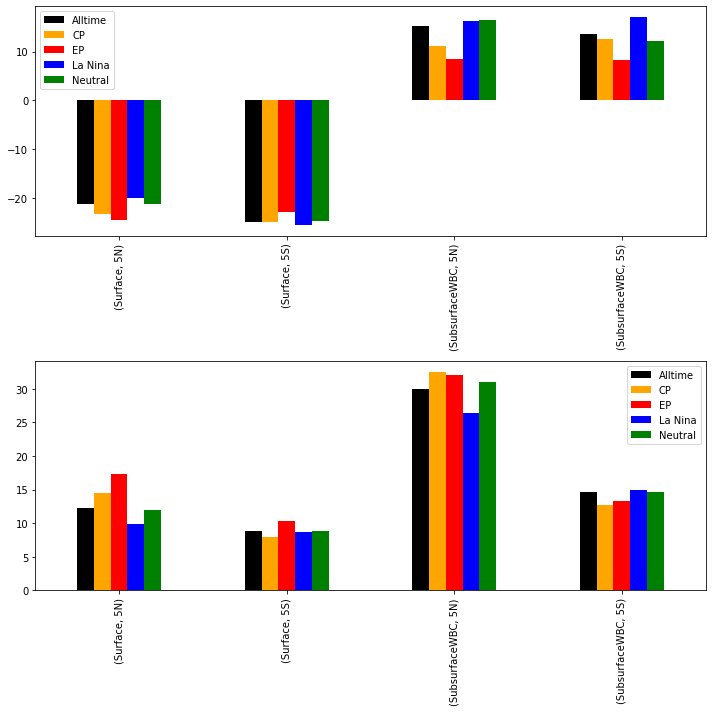

In [117]:
plt.figure(figsize=(10,10))
ax=plt.subplot(211)
table['Meridional Transport'].T[['Surface','SubsurfaceWBC']].unstack().plot.bar(color=['k','orange','red','blue','green'],ax=ax)

ax=plt.subplot(212)
abs(tablestd)['Meridional Transport'].T[['Surface','SubsurfaceWBC']].unstack().plot.bar(ax=ax,color=['k','orange','red','blue','green'])
plt.tight_layout()

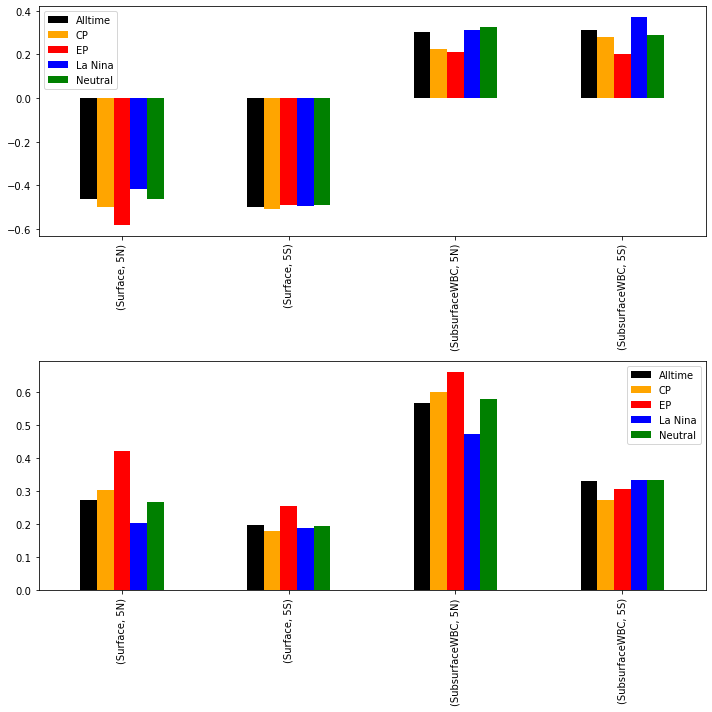

In [118]:
plt.figure(figsize=(10,10))
ax=plt.subplot(211)
table['AnthC transport'].T[['Surface','SubsurfaceWBC']].unstack().plot.bar(color=['k','orange','red','blue','green'],ax=ax)

ax=plt.subplot(212)
abs(tablestd)['AnthC transport'].T[['Surface','SubsurfaceWBC']].unstack().plot.bar(ax=ax,color=['k','orange','red','blue','green'])
plt.tight_layout()

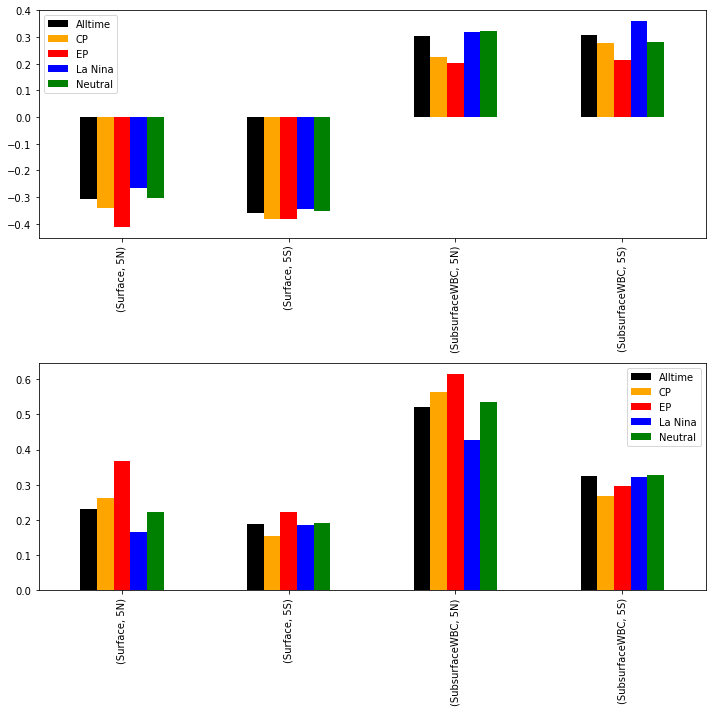

In [119]:
plt.figure(figsize=(10,10))
ax=plt.subplot(211)
table['AnthC+GM transport'].T[['Surface','SubsurfaceWBC']].unstack().plot.bar(color=['k','orange','red','blue','green'],ax=ax)

ax=plt.subplot(212)
abs(tablestd)['AnthC+GM transport'].T[['Surface','SubsurfaceWBC']].unstack().plot.bar(ax=ax,color=['k','orange','red','blue','green'])
plt.tight_layout()

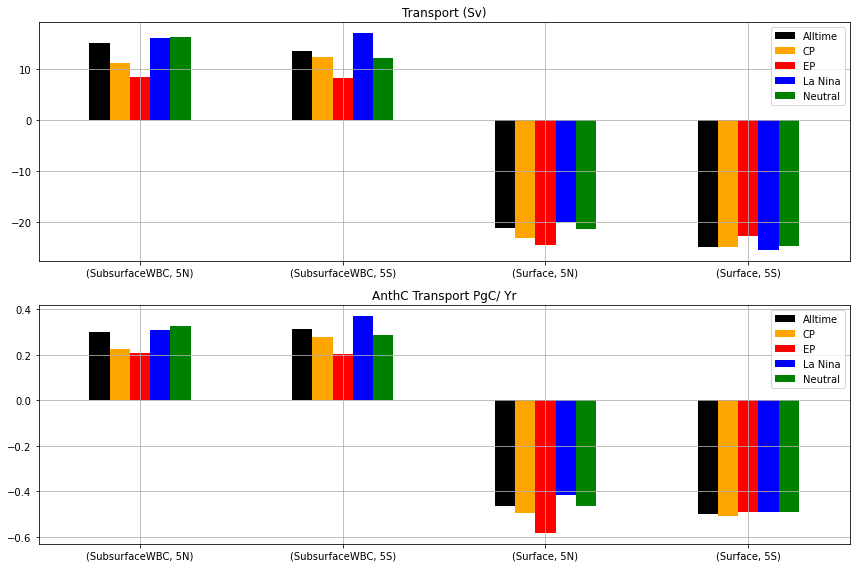

In [120]:
plt.figure(figsize=(12,8))
ax=plt.subplot(211)
table.loc[['SubsurfaceWBC','Surface']]['Meridional Transport'].unstack().plot.bar(color=['k','orange','red','blue','green'],ax=ax)
plt.title('Transport (Sv)')
plt.xticks(rotation=360)
plt.grid()
ax=plt.subplot(212)
table.loc[['SubsurfaceWBC','Surface']]['AnthC transport'].unstack().plot.bar(color=['k','orange','red','blue','green'],ax=ax)
plt.grid()
plt.title('AnthC Transport PgC/ Yr')
plt.xticks(rotation=360)
plt.tight_layout()

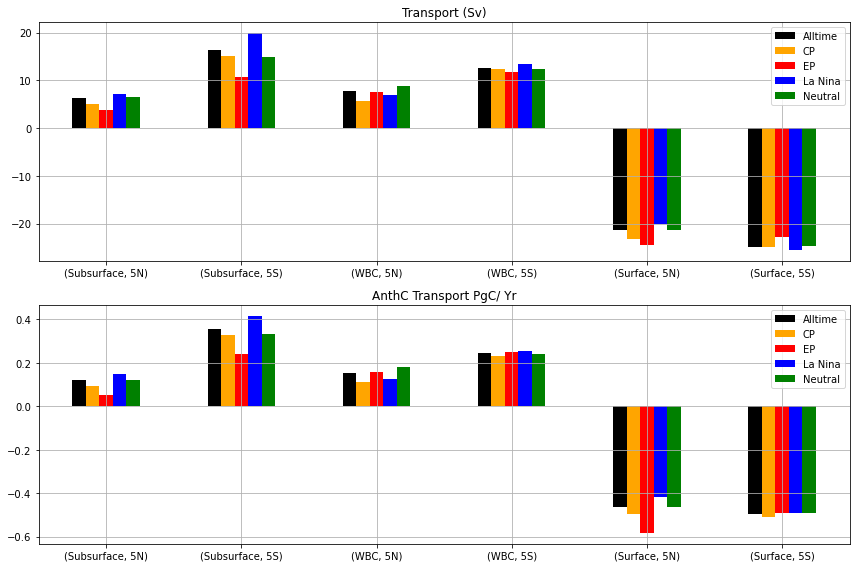

In [196]:
plt.figure(figsize=(12,8))
ax=plt.subplot(211)
table.loc[['Subsurface','WBC','Surface']]['Meridional Transport'].unstack().plot.bar(color=['k','orange','red','blue','green'],ax=ax)
plt.title('Transport (Sv)')
plt.xticks(rotation=360)
plt.grid()
ax=plt.subplot(212)
table.loc[['Subsurface','WBC','Surface']]['AnthC transport'].unstack().plot.bar(color=['k','orange','red','blue','green'],ax=ax)
plt.grid()
plt.title('AnthC Transport PgC/ Yr')
plt.xticks(rotation=360)

plt.tight_layout()

<AxesSubplot:xlabel='level_0'>

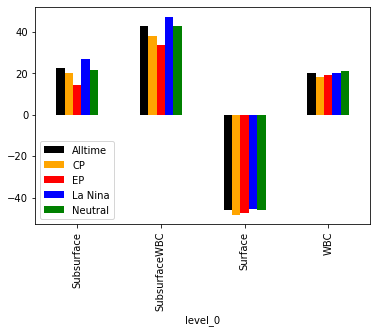

In [194]:
table.loc[['SubsurfaceWBC','WBC','Subsurface','Surface']]['Meridional Transport'].unstack().reset_index().groupby('level_0').sum().plot.bar(color=['k','orange','red','blue','green'])

<AxesSubplot:>

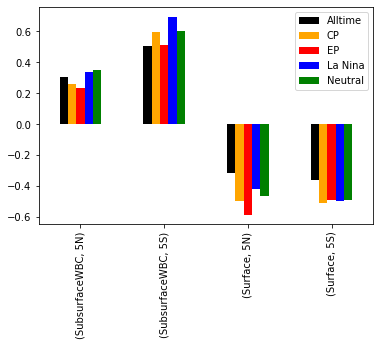

In [109]:
table.loc[['SubsurfaceWBC','Surface']]['AnthC transport'].unstack().plot.bar(color=['k','orange','red','blue','green'])

In [37]:
subsurf=table['AnthC transport'].reset_index().query("level_0 == 'SubsurfaceWBC'").query("level_1 == '5N'").set_index(['level_2'])#.plot.bar()#.groupby(['level_1','level_2'])

In [44]:
surf=table['AnthC transport'].reset_index().query("level_0 == 'Surface'").query("level_1 == '5N'").set_index(['level_2'])#.plot.bar()#.groupby(['level_1','level_2'])

In [55]:
subsurf.T#['AnthC transport']

level_2                Alltime             CP             EP        La Nina  \
level_0          SubsurfaceWBC  SubsurfaceWBC  SubsurfaceWBC  SubsurfaceWBC   
level_1                     5N             5N             5N             5N   
AnthC transport       0.308442       0.260726       0.235754       0.337456   

level_2                Neutral  
level_0          SubsurfaceWBC  
level_1                     5N  
AnthC transport        0.35052

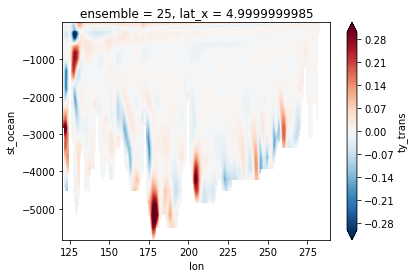

In [21]:
####Double Check N Face
cafe_y_tx_fulldep.sel(lat_x=5,method='nearest').mean(dim='time').plot.contourf(levels=np.arange(-0.3,0.31,0.01))#.sum().values
#cafe_y_tx_fulldep_gm

(6000.0, 0.0)

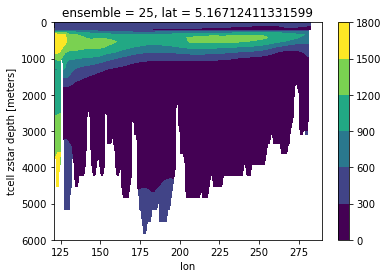

In [24]:
####Double Check N Face
anth_dic_cafe.sel(lat=5,method='nearest').mean(dim='time').plot.contourf()#levels=np.arange(-0.3,0.31,0.01))#.sum().values
plt.ylim([6000,0])
#cafe_y_tx_fulldep_gm

In [40]:
cafe_y_tx_gm.diff(dim='st_ocean',n=1)

In [75]:
#check ath mass change through box
checksum=(cafe_x_tx.sel(time=slice('2000-01-01','2020-01-01')).sel(st_ocean=slice(0,-600)))#*60*60*24*(365/12)*12)/1e18
v1=checksum.sel(lat=-5,method='nearest').sum().values#*60*60*24*(365/12)*12)/1e18
v2=(-checksum).sel(lat=5,method='nearest').sum().values#*60*60*24*(365/12)*12)/1e18
print(v1)
print(v2)
print(v1+v2)

-30995.236
-8193.043
-39188.28


In [77]:
#check ath mass change through box
checksum=(cafe_y_tx.sel(time=slice('2000-01-01','2020-01-01')).sel(st_ocean=slice(0,-600))).mean(dim='time')#*60*60*24*(365/12)*12)/1e18
v1=checksum.sel(lat_x=-5,method='nearest').sum().values#*60*60*24*(365/12)*12)/1e18
v2=(checksum*-1).sel(lat_x=5,method='nearest').sum().values#*60*60*24*(365/12)*12)/1e18
print(v1)
print(v2)
print(v1+v2)

8.915297
-7.1625013
1.7527952


In [89]:
#check ath mass change through box
checksum=(anth_dic_v_tx.sel(time=slice('2000-01-01','2020-01-01')).sel(st_ocean=slice(0,-600))*60*60*24*(365/12)*12)/1e18
v1=checksum.sel(lat=-5,method='nearest').sum().values#*60*60*24*(365/12)*12)/1e18
v2=(checksum).sel(lat=5,method='nearest').sum().values*-1#*60*60*24*(365/12)*12)/1e18
print(v1)
print(v2)
print(v1+v2)

3.0567026
-3.582047939300537
-0.5253453254699707


In [54]:
#check ath mass change through box
checksum=anth_dic_v_tx.sel(time=slice('2000-01-01','2020-01-01')).sel(st_ocean=slice(0,-600))
v1=(checksum.sel(lat=-3,method='nearest').sum().values*60*60*24*(365/12)*12)/1e18
v2=(-checksum.sel(lat=3,method='nearest').sum().values*60*60*24*(365/12)*12)/1e18
print(v1+v2)

-0.4591991008788483


In [52]:
#check ath mass change through box
checksum=anth_dic_v_tx.sel(time=slice('2000-01-01','2020-01-01')).sel(st_ocean=slice(0,-700))
(checksum.sel(lat=-5,method='nearest').sum().values*60*60*24*(365/12)*12)/1e18

3.18544689954816

In [44]:
(checksum.sel(lat=5,method='nearest').sum().values*60*60*24*(365/12)*12)/1e18

3.594727432912896

In [45]:
3.59-3.185

0.4049999999999998

In [39]:
#ax.set_title

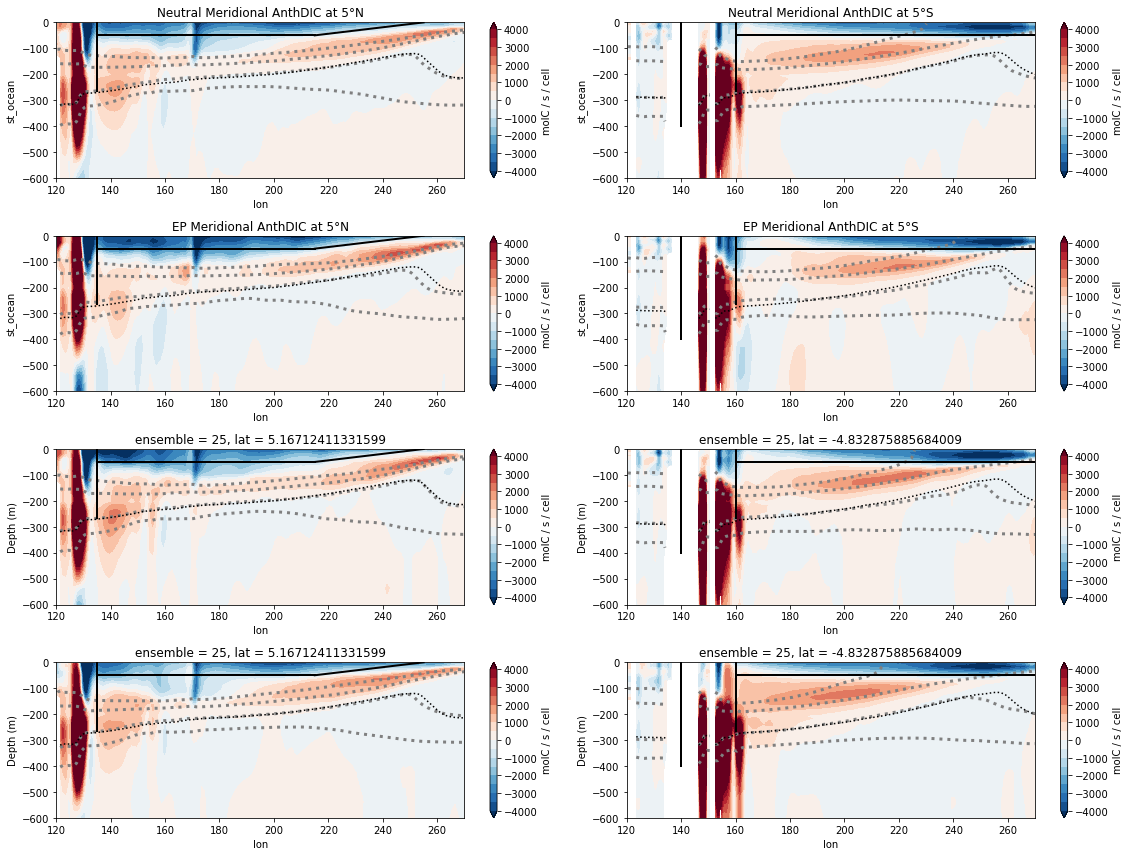

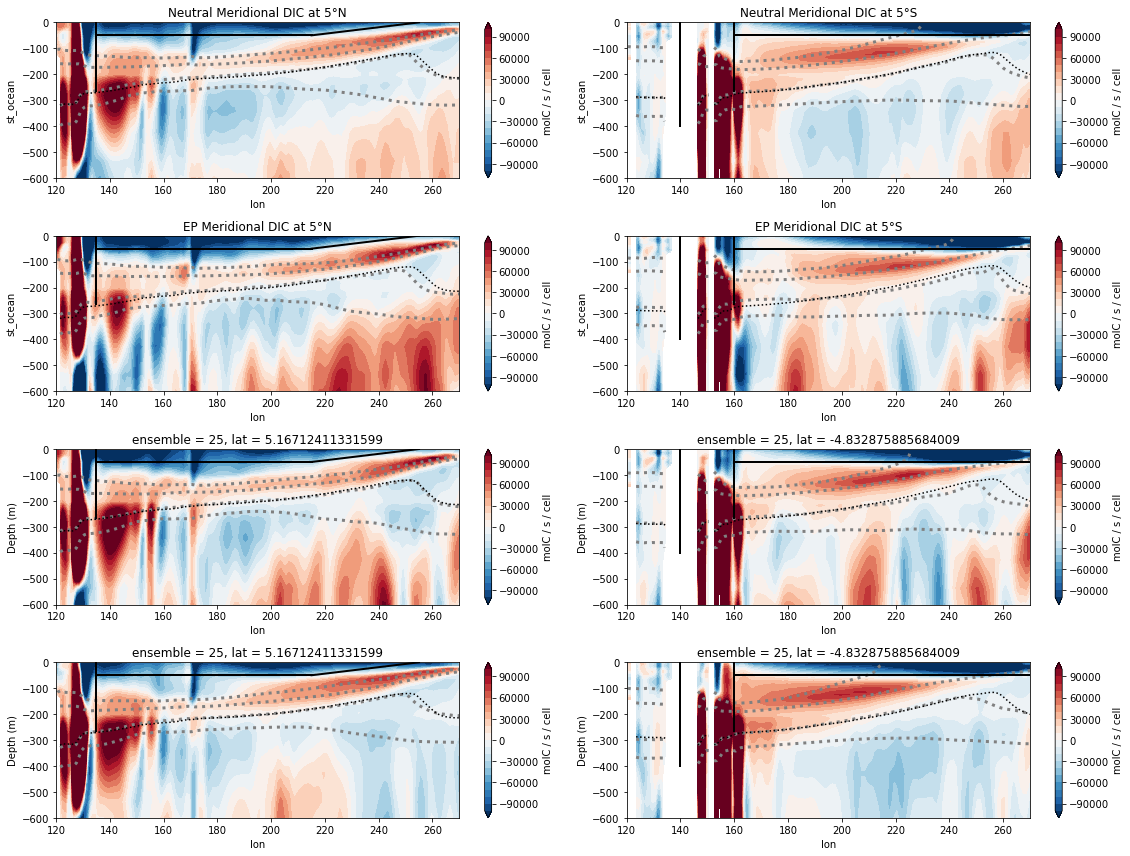

In [40]:
#%%time
def add_north_lines():
    plt.plot([135,215],[-50,-50],c='k',linewidth=2)
    plt.plot([215,255],[-50,-0],c='k',linewidth=2)
    plt.plot([115,115],[-400,0],c='k',linewidth=2)
    plt.plot([135,135],[-265,0],c='k',linewidth=2)
    cafe_potential_density.chunk('auto').sel(lat=5,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')

def add_south_lines():
    plt.plot([160,280],[-50,-50],c='k',linewidth=2)
    plt.plot([140,140],[-400,0],c='k',linewidth=2)
    plt.plot([160,160],[-265,0],c='k',linewidth=2)
    cafe_potential_density.chunk('auto').sel(lat=-5,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')
    

longitude_labels=['','160°E','180°','160°W','140°W','120°W','100°W']
densitylevs=[1023,1024.5,1026.3,1026.6]#,1026.7]#,1027.0]#,1026.7,1027,1027.5]
ylim=-600

plot=True
if plot==True:
    N_S_data_holder=[anth_dic_v_tx.sel(time=slice('2000-01-01','2020-01-01')).sel(st_ocean=slice(0,-700)),
                     dic_v_tx.sel(time=slice('2000-01-01','2020-01-01')).sel(st_ocean=slice(0,-700))]
                     #((grid_multiplier_lon*(anth_dic_tx_v_OLD.chunk('auto').sel(st_ocean=slice(0,-500)))/1000000).T)]

    N_S_names=['Meridional AnthDIC','Meridional DIC']#,'Old Attempt']


    for i, N_S_data in enumerate(N_S_data_holder):
        plt.figure(figsize=(16,12))

        for xi,lat in enumerate([5,-5]):
            #Client.restart()
            #time.sleep(10)
            adic_tx_n=N_S_data.sel(lat=lat,method='nearest')/1000 #to mol #(grid_multiplier_lon*(anth_dic_tx_v.sel(lat=lat,method='nearest').sel(st_ocean=slice(0,-500)))).T
            if lat==5: 
                direct='5°N'
                add_lines=add_north_lines
                adic_tx_n=adic_tx_n*-1  # Calculate Transport OUT of the box
            if lat==-5: 
                direct='5°S'
                add_lines=add_south_lines
    
            
            
            if ((i==0)|(i==2)): 
                levs=np.arange(-4e3,4.5e3,5e2)
            elif i==1: 
                levs=np.arange(-1e5,1.1e5,1e4)
            #else: levs=np.arange(-10,10,1)
            contour=[0]#60,-60]
            
         

            subpl=plt.subplot(4,2,1+(xi))        
            adic_tx_n.sel(time=neutral_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'molC / s / cell'})
            #adic_tx_n.sel(time=neutral_events).mean(dim='time').plot.contour(levels=contour,colors='k')
            #asum_neutral=xarray_posneg_calc(adic_tx_n*1000,enso_months=neutral_events,lat=lat)
            (cafe_potential_density).sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)
            #asum_neutral.index=[f'Neutral {N_S_names[i]} at {direct}']
            #print(asum)
            subpl.set_title(f'Neutral {N_S_names[i]} at {direct}')
            subpl.set_xlim([120,270])
            subpl.set_ylim([ylim,0])
            #subpl.set_xticklabels(longitude_labels)
            subpl.set_ylabel('Depth (m)')
            add_lines()
            subpl.set_title(f'Neutral {N_S_names[i]} at {direct}')
            #cbar=plt.colorbar(ax)
            #cbar.set_label()#, rotation=270)

            subpl=plt.subplot(4,2,3+xi)
            adic_tx_n.sel(time=ep_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'molC / s / cell'})
            #adic_tx_n.sel(time=ep_events).mean(dim='time').plot.contour(levels=contour,colors='k')
            #asum_ep=xarray_posneg_calc(adic_tx_n*1000,enso_months=ep_events,lat=lat)
            (cafe_potential_density).sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)
            #asum_ep.index=[f'EP {N_S_names[i]} at {direct}']
            #print(asum)
            subpl.set_title(f'EP {N_S_names[i]} at {direct}')
            plt.xlim([120,270])
            plt.ylim([ylim,0])
            plt.ylabel('Depth (m)')
            add_lines()
            plt.title(f'EP {N_S_names[i]} at {direct}')
            #subpl.set_xticklabels(longitude_labels)

            subpl=plt.subplot(4,2,5+xi)
            adic_tx_n.sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'molC / s / cell'})
            #adic_tx_n.sel(time=cp_events).mean(dim='time').plot.contour(levels=contour,colors='k')
            #asum_cp=xarray_posneg_calc(adic_tx_n*1000,enso_months=cp_events,lat=lat)
            (cafe_potential_density).sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)
            #asum_cp.index=[f'CP {N_S_names[i]} at {direct}']
            subpl.set_title(f'CP {N_S_names[i]} at {direct}')
            #subpl.set_xticklabels(longitude_labels)
            plt.xlim([120,270])
            plt.ylim([ylim,0])
            add_lines()
            plt.ylabel('Depth (m)')
            
            subpl=plt.subplot(4,2,7+xi)
            adic_tx_n.sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'molC / s / cell'})
            #adic_tx_n.sel(time=nina_events).mean(dim='time').plot.contour(levels=contour,colors='k')
            #asum_nina=xarray_posneg_calc(adic_tx_n*1000,enso_months=nina_events,lat=lat)
            (cafe_potential_density).sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)
            #asum_nina.index=[f'Nina {N_S_names[i]} at {direct}']
            subpl.set_title(f'La Nina {N_S_names[i]} at {direct}')
            plt.xlim([120,270])
            #subpl.set_xticklabels(longitude_labels)
            plt.ylim([ylim,0])
            add_lines()
            plt.ylabel('Depth (m)')
            
            
            #asum_alltime=xarray_posneg_calc(adic_tx_n*1000,enso_months=all_dates,lat=lat)
            #asum_alltime.index=[f'Alltime {N_S_names[i]} at {direct}']
            
            #temp_holder=pd.concat([asum_neutral,asum_ep,asum_cp,asum_nina,asum_alltime])#,index=[f'{N_S_names[i]} in {direct}',f'{N_S_names[i]} out {direct}'])
            #dic_transport_through_box=dic_transport_through_box.append(temp_holder)
        plt.tight_layout()
        plt.show()
        
#dic_transport_through_box                                     

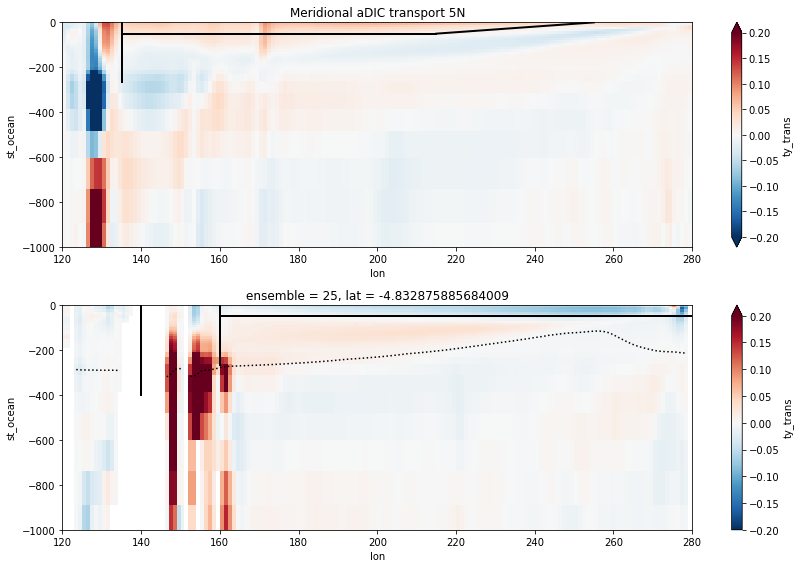

In [25]:
plt.figure(figsize=(12,8))
plt.subplot(211)

#anth_dic_v_tx_gm
cafe_y_tx.sel(lat_x=5,method='nearest').mean(dim='time').plot(cmap='RdBu_r',vmin=-0.2,vmax=0.2)#sel(time='2000-01-01').plot()
plt.xlim([120,280])
plt.ylim([-1000,0])
plt.plot([135,215],[-50,-50],c='k',linewidth=2)
plt.plot([215,255],[-50,-0],c='k',linewidth=2)
plt.plot([115,115],[-400,0],c='k',linewidth=2)
plt.plot([135,135],[-265,0],c='k',linewidth=2)
plt.title('Meridional aDIC transport 5N')


plt.subplot(212)

cafe_y_tx.sel(lat_x=-5,method='nearest').mean(dim='time').plot(cmap='RdBu_r',vmin=-0.2,vmax=0.2)#sel(time='2000-01-01').plot()
plt.xlim([120,280])
plt.ylim([-1000,0])
plt.plot([160,280],[-50,-50],c='k',linewidth=2)
#plt.plot([215,255],[-50,-0],c='k',linewidth=2)
plt.plot([140,140],[-400,0],c='k',linewidth=2)
plt.plot([160,160],[-265,0],c='k',linewidth=2)
plt.title('Meridional aDIC transport 5S')
cafe_potential_density.chunk('auto').sel(lat=-5,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')
                    
plt.tight_layout()

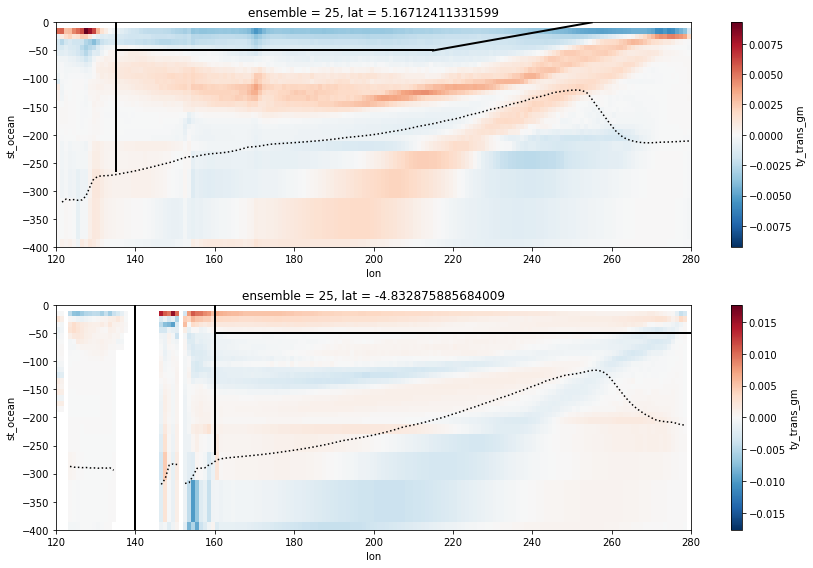

In [44]:
plt.figure(figsize=(12,8))
plt.subplot(211)

#anth_dic_v_tx_gm
cafe_y_tx_gm.diff(dim='st_ocean',n=1).sel(lat_x=5,method='nearest').mean(dim='time').plot(cmap='RdBu_r')#sel(time='2000-01-01').plot()
plt.xlim([120,280])
plt.ylim([-400,0])
plt.plot([135,215],[-50,-50],c='k',linewidth=2)
plt.plot([215,255],[-50,-0],c='k',linewidth=2)
plt.plot([115,115],[-400,0],c='k',linewidth=2)
plt.plot([135,135],[-265,0],c='k',linewidth=2)
plt.title('Meridional aDIC transport 5N')
cafe_potential_density.chunk('auto').sel(lat=5,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')


plt.subplot(212)

cafe_y_tx_gm.diff(dim='st_ocean',n=1).sel(lat_x=-5,method='nearest').mean(dim='time').plot(cmap='RdBu_r')#sel(time='2000-01-01').plot()
plt.xlim([120,280])
plt.ylim([-400,0])
plt.plot([160,280],[-50,-50],c='k',linewidth=2)
#plt.plot([215,255],[-50,-0],c='k',linewidth=2)
plt.plot([140,140],[-400,0],c='k',linewidth=2)
plt.plot([160,160],[-265,0],c='k',linewidth=2)
plt.title('Meridional aDIC transport 5S')
cafe_potential_density.chunk('auto').sel(lat=-5,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')
                    
plt.tight_layout()

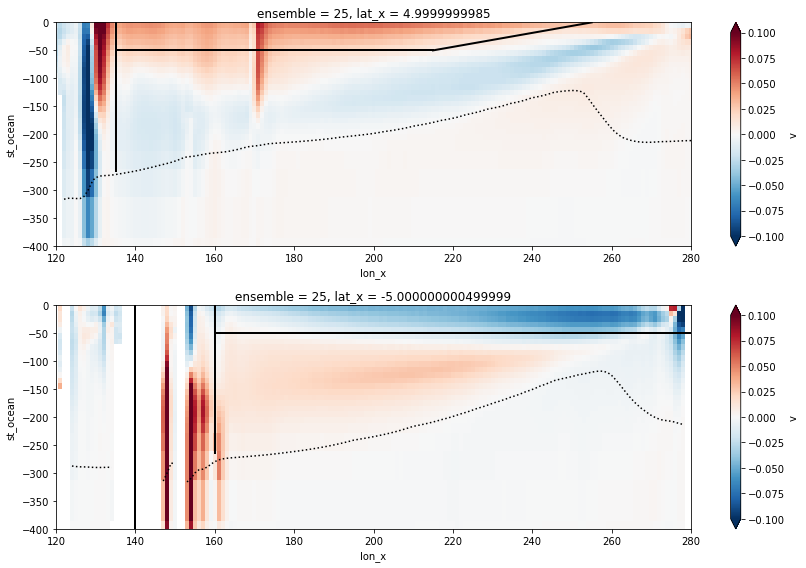

In [219]:
plt.figure(figsize=(12,8))
plt.subplot(211)

cafe_v.sel(lat_x=5,method='nearest').mean(dim='time').plot(vmin=-0.1,vmax=0.1,cmap='RdBu_r')#sel(time='2000-01-01').plot()
plt.xlim([120,280])
plt.ylim([-400,0])
plt.plot([135,215],[-50,-50],c='k',linewidth=2)
plt.plot([215,255],[-50,-0],c='k',linewidth=2)
plt.plot([115,115],[-400,0],c='k',linewidth=2)
plt.plot([135,135],[-265,0],c='k',linewidth=2)
plt.title('Mean U velocity 5N')
cafe_potential_density.chunk('auto').rename({'lat':'lat_x','lon':'lon_x'}).interp({'lat_x':cafe_v.lat_x,'lon_x':cafe_v.lon_x}).sel(lat_x=5,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')
                
plt.subplot(212)

cafe_v.sel(lat_x=-5,method='nearest').mean(dim='time').plot(vmin=-0.1,vmax=0.1,cmap='RdBu_r')#sel(time='2000-01-01').plot()
plt.xlim([120,280])
plt.ylim([-400,0])
plt.plot([160,280],[-50,-50],c='k',linewidth=2)
#plt.plot([215,255],[-50,-0],c='k',linewidth=2)
plt.plot([140,140],[-400,0],c='k',linewidth=2)
plt.plot([160,160],[-265,0],c='k',linewidth=2)
plt.title('Mean U velocity 5S')
cafe_potential_density.chunk('auto').rename({'lat':'lat_x','lon':'lon_x'}).interp({'lat_x':cafe_v.lat_x,'lon_x':cafe_v.lon_x}).sel(lat_x=-5,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')
                    
plt.tight_layout()

# Zeller Comparisons

In [27]:
def plot_cartopy_row(dat,
                     axn,
                     sb1=2,
                     sb2=2,
                     levs=None,
                     lon='lon',lat='lat',title=None,cmap='RdBu_r',extend=None,units=''):
                     
    usemap_proj = ccrs.PlateCarree(central_longitude=180)
    usemap_proj._threshold /= 20.  # to make greatcircle smooth

    fr=0.03
    fs=12
    ms=10
    
    
    ax = plt.subplot(sb1,sb2,axn,projection=usemap_proj)
    
    ax.set_extent([120, 290, -40, 40], crs=ccrs.PlateCarree()) # set appropriate extents: (lon_min, lon_max, lat_min, lat_max)
    geodetic = ccrs.Geodetic()
    plate_carree = ccrs.PlateCarree(central_longitude=180)

    f=ax.contourf(dat[lon].values,dat[lat].values,dat,transform=ccrs.PlateCarree(),cmap=cmap,levels=levs,extend=extend) 
        #Quick anti-aliasing fix as per: https://stackoverflow.com/questions/15822159/aliasing-when-saving-matplotlib-filled-contour-plot-to-pdf-or-eps
    for c in f.collections:
        c.set_edgecolor("face")
    
    ax.add_feature(cfeature.LAND, color='lightgray')
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.axhline(5,c='k')
    ax.axhline(-5,c='k')
    ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), color='gray', linewidth=0.3)
    ax.set_title(title)
    #Colorbar
    cb=plt.colorbar(f,ax=ax,fraction=fr)
    cb.set_label(units,fontsize=fs)
    cb.ax.tick_params(labelsize=fs-1)

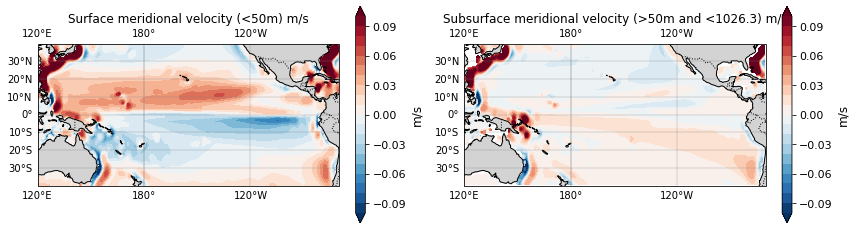

In [18]:
# subsurface TX (sv/cell)
plt.figure(figsize=(12,6))

# Surface TX (sv/cell)
dat=cafe_v.where(cafe_v.st_ocean>-50).mean(dim='st_ocean').mean(dim='time')#.plot(vmin=-0.1,vmax=0.1,cmap='RdBu_r')
plot_cartopy_row(dat,axn=1,sb2=2,sb1=1,title='Surface meridional velocity (<50m) m/s',lon='lon_x',lat='lat_x',units='m/s',levs=np.arange(-0.1,0.11,0.01),extend='both')

# Subsurface
dat=cafe_v.where(cafe_v.st_ocean<-50).where(cafe_potential_density.chunk('auto').rename({'lat':'lat_x','lon':'lon_x'}).interp({'lat_x':cafe_v.lat_x,'lon_x':cafe_v.lon_x})<=1026.3).mean(dim='st_ocean').mean(dim='time')
plot_cartopy_row(dat,axn=2,sb2=2,sb1=1,title='Subsurface meridional velocity (>50m and <1026.3) m/s',lon='lon_x',lat='lat_x',units='m/s',levs=np.arange(-0.1,0.11,0.01),extend='both')

plt.tight_layout()
plt.show()


# Figure 1 or 2 or 3?

In [24]:
adic_plot=anth_dic_cafe.sel(st_ocean=slice(0,1200))
adic_plot['st_ocean']=adic_plot['st_ocean']*-1
#adic_plot=adic_plot*adic_plot.depth_diff
adic_plot=adic_plot.sel(time=slice('2000','2020')).load()

st_ocean_holder1=st_ocean_holder.copy(deep=True)
st_ocean_holder1['st_ocean']=st_ocean_holder1['st_ocean']*-1

In [25]:
#adic_plot

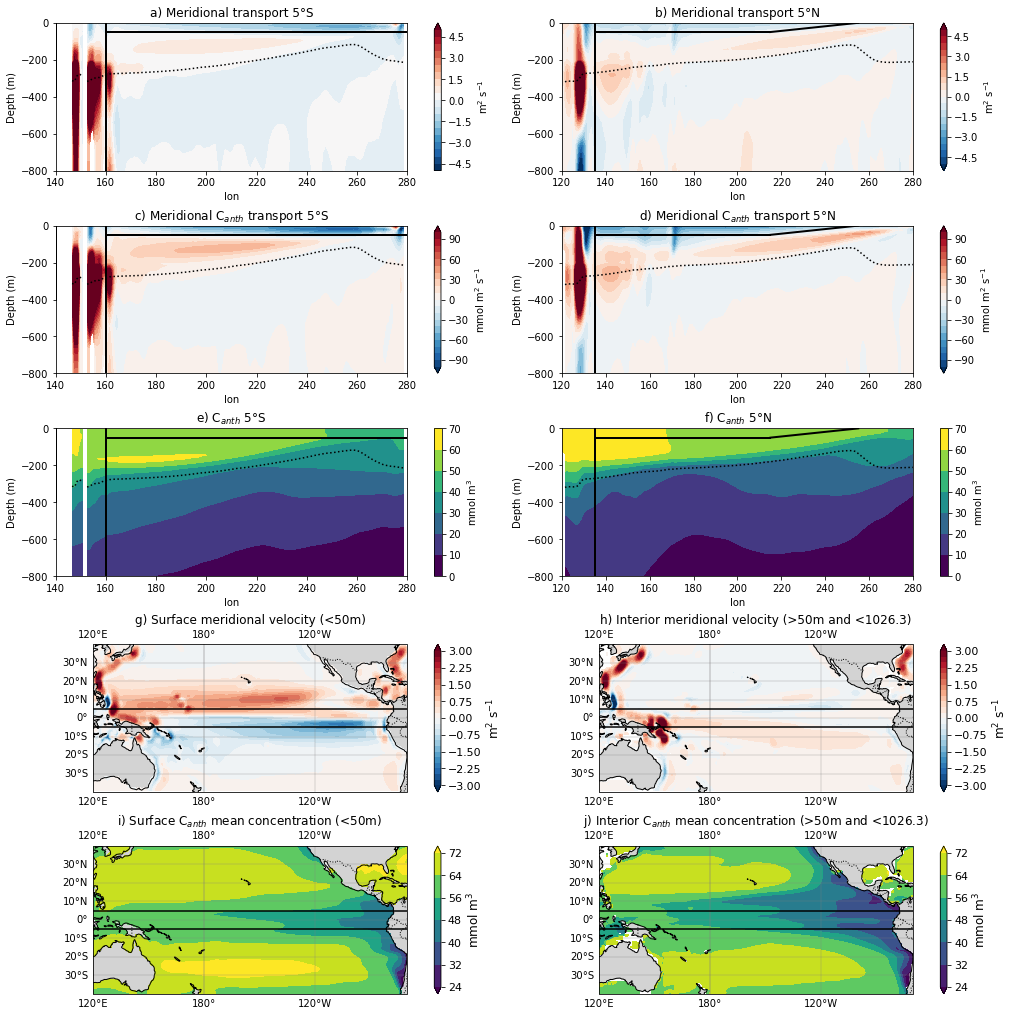

In [29]:
plt.figure(figsize=(14,14),constrained_layout=True)
  
# Sometimes need to run this tice?
plt.subplot(5,2,1)
cplot=(cafe_y_tx*1e6/lon_face_length_m.rename({'lat':'lat_x'}).interp({'lat_x':cafe_y_tx.lat_x})).sel(lat_x=-5,method='nearest').mean(dim='time').plot.contourf(levels=np.arange(-5,5.5,0.5),cmap='RdBu_r',cbar_kwargs={'label': 'm$^{2}$ s$^{-1}$'})#sel(time='2000-01-01').plot()


plt.plot([160,280],[-50,-50],c='k',linewidth=2)
plt.plot([140,140],[-400,0],c='k',linewidth=2)
plt.plot([160,160],[-1000,0],c='k',linewidth=2)
cafe_potential_density.chunk('auto').sel(lat=-5.1,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')
plt.title('a) Meridional transport 5°S')
plt.xlim([140,280])
plt.ylim([-800,0])
#plt.ylim([-500,0])
plt.ylabel('Depth (m)')


plt.subplot(5,2,2)
cplot=((-cafe_y_tx*1e6/lon_face_length_m.rename({'lat':'lat_x'}).interp({'lat_x':cafe_y_tx.lat_x}))).sel(lat_x=5,method='nearest').mean(dim='time').plot.contourf(levels=np.arange(-5,5.5,0.5),cmap='RdBu_r', cbar_kwargs={'label': 'm$^{2}$ s$^{-1}$'})#sel(time='2000-01-01').plot()


plt.plot([135,215],[-50,-50],c='k',linewidth=2)
plt.plot([215,255],[-50,-0],c='k',linewidth=2)
plt.plot([115,115],[-400,0],c='k',linewidth=2)
plt.plot([135,135],[-1000,0],c='k',linewidth=2)
cafe_potential_density.chunk('auto').sel(lat=5,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')
plt.xlim([120,280])
plt.ylabel('Depth (m)')
#plt.ylim([-500,0])
plt.ylim([-800,0])
plt.title('b) Meridional transport 5°N')

                
plt.subplot(5,2,3)

(anth_dic_v_tx/lon_face_length_m.interp({'lat':anth_dic_v_tx.lat})).sel(lat=-5,method='nearest').mean(dim='time').plot.contourf(levels=np.arange(-100,110,10),cmap='RdBu_r',cbar_kwargs={'label': 'mmol m$^{2}$ s$^{-1}$'})#sel(time='2000-01-01').plot()

plt.plot([160,280],[-50,-50],c='k',linewidth=2)
plt.plot([140,140],[-400,0],c='k',linewidth=2)
plt.plot([160,160],[-1000,0],c='k',linewidth=2)
cafe_potential_density.chunk('auto').sel(lat=-5.1,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')
plt.title('c) Meridional C$_{anth}$ transport 5°S')
plt.xlim([140,280])
#plt.ylim([-500,0])
plt.ylim([-800,0])
plt.ylabel('Depth (m)')

plt.subplot(5,2,4)

(-anth_dic_v_tx/lon_face_length_m.interp({'lat':anth_dic_v_tx.lat})).sel(lat=5,method='nearest').mean(dim='time').plot.contourf(levels=np.arange(-100,110,10),cmap='RdBu_r',cbar_kwargs={'label': 'mmol m$^{2}$ s$^{-1}$'})#sel(time='2000-01-01').plot()

plt.plot([135,215],[-50,-50],c='k',linewidth=2)
plt.plot([215,255],[-50,-0],c='k',linewidth=2)
plt.plot([115,115],[-400,0],c='k',linewidth=2)
plt.plot([135,135],[-1000,0],c='k',linewidth=2)
cafe_potential_density.chunk('auto').sel(lat=5,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')
plt.title('d) Meridional C$_{anth}$ transport 5°N')
plt.xlim([120,280])
#plt.ylim([-500,0])
plt.ylim([-800,0])
plt.ylabel('Depth (m)')


plt.subplot(5,2,5)
(adic_plot.sel(lat=-5,method='nearest').mean(dim='time').plot.contourf(cmap='viridis',cbar_kwargs={'label': 'mmol m$^{3}$'},levels=np.arange(0,80,10)))#10000,1000)))


plt.plot([160,280],[-50,-50],c='k',linewidth=2)
plt.plot([140,140],[-400,0],c='k',linewidth=2)
plt.plot([160,160],[-1000,0],c='k',linewidth=2)
cafe_potential_density.chunk('auto').sel(lat=-5.1,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')
plt.title('e) C$_{anth}$ 5°S')
plt.xlim([140,280])
plt.ylim([-800,0])
plt.ylabel('Depth (m)')


plt.subplot(5,2,6)
(adic_plot.sel(lat=5,method='nearest').mean(dim='time').plot.contourf(cmap='viridis', cbar_kwargs={'label': 'mmol m$^{3}$'},levels=np.arange(0,80,10)))##,levels=np.arange(0,10000,1000)))#np.arange(0,2200,200)))


plt.plot([135,215],[-50,-50],c='k',linewidth=2)
plt.plot([215,255],[-50,-0],c='k',linewidth=2)
plt.plot([115,115],[-400,0],c='k',linewidth=2)
plt.plot([135,135],[-1000,0],c='k',linewidth=2)
cafe_potential_density.chunk('auto').sel(lat=5,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')
plt.xlim([120,280])
plt.ylabel('Depth (m)')
plt.ylim([-800,0])
plt.title('f) C$_{anth}$ 5°N')





dat1=((cafe_y_tx*1e6)/lon_face_length_m.rename({'lat':'lat_x'}).interp({'lat_x':cafe_y_tx.lat_x})).where(cafe_y_tx.st_ocean>-50).mean(dim='st_ocean').mean(dim='time')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
plot_cartopy_row(dat1,axn=7,sb1=5,sb2=2,title='g) Surface meridional velocity (<50m)',lon='lon',lat='lat_x',units='m$^{2}$ s$^{-1}$',levs=np.arange(-3,3.25,0.25),extend='both')

# Subsurface
dat2=((cafe_y_tx*1e6)/lon_face_length_m.rename({'lat':'lat_x'}).interp({'lat_x':cafe_y_tx.lat_x})).where(cafe_y_tx.st_ocean<-50).where(cafe_potential_density.chunk('auto').rename({'lat':'lat_x'}).interp({'lat_x':cafe_y_tx.lat_x})<=1026.3).mean(dim='st_ocean').mean(dim='time')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
plot_cartopy_row(dat2,axn=8,sb1=5,sb2=2,title='h) Interior meridional velocity (>50m and <1026.3)',lon='lon',lat='lat_x',units='m$^{2}$ s$^{-1}$',levs=np.arange(-3,3.25,0.25),extend='both')



#dat1=(adic_plot*st_ocean_holder1.depth_diff/1000).sel(st_ocean=slice(0,-50)).sum(dim='st_ocean').mean(dim='time')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
#plot_cartopy_row(dat1.where(dat1!=0),axn=9,sb1=5,sb2=2,title='i) Surface C$_{anth}$ inventory (<50m)',lon='lon',lat='lat',units='mol m$^{2}$',extend='both',cmap='viridis',levs=np.arange(0,4.1,0.1))#np.arange(0,2000,100))#np.arange(0,10000,1000))

# Subsurface
#dat2=(adic_plot*st_ocean_holder1.depth_diff/1000).sel(st_ocean=slice(-50,-450)).where(cafe_potential_density.chunk('auto').interp({'lat':adic_plot.lat})<=1026.3).sum(dim='st_ocean').mean(dim='time')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
#plot_cartopy_row(dat2.where(dat2!=0),axn=10,sb1=5,sb2=2,title='j) Subsurface C$_{anth}$ inventory (>50m and <1026.3)',lon='lon',lat='lat',units='mol m$^{2}$',extend='both',cmap='viridis',levs=np.arange(0,21,1))#,levs=np.arange(0,80,10))#np.arange(0,2000,100))#) #np.arange(-30,33,3)

dat1=(adic_plot).sel(st_ocean=slice(0,-50)).mean(dim='st_ocean').mean(dim='time')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
plot_cartopy_row(dat1.where(dat1!=0),axn=9,sb1=5,sb2=2,title='i) Surface C$_{anth}$ mean concentration (<50m)',lon='lon',lat='lat',units='mmol m$^{3}$',extend='both',cmap='viridis')#,levs=np.arange(0,4.1,0.1))#np.arange(0,2000,100))#np.arange(0,10000,1000))


dat2=(adic_plot).sel(st_ocean=slice(-50,-450)).where(cafe_potential_density.chunk('auto').interp({'lat':adic_plot.lat})<=1026.3).mean(dim='st_ocean').mean(dim='time')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
plot_cartopy_row(dat2.where(dat2!=0),axn=10,sb1=5,sb2=2,title='j) Interior C$_{anth}$ mean concentration (>50m and <1026.3)',lon='lon',lat='lat',units='mmol m$^{3}$',extend='both',cmap='viridis')#,levs=np.arange(0,21,1))#,levs=np.arange(0,80,10))#np.arange(0,2000,100))#) #np.arange(-30,33,3)



#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

#plt.tight_layout()
plt.show()

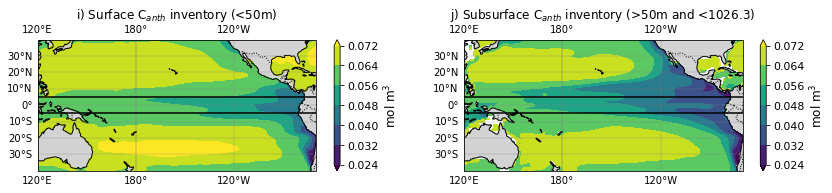

In [28]:
plt.figure(figsize=(14,14))
# Subsurface


dat1=(adic_plot/1000).sel(st_ocean=slice(0,-50)).mean(dim='st_ocean').mean(dim='time')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
plot_cartopy_row(dat1.where(dat1!=0),axn=9,sb1=5,sb2=2,title='i) Surface C$_{anth}$ inventory (<50m)',lon='lon',lat='lat',units='mol m$^{3}$',extend='both',cmap='viridis')#,levs=np.arange(0,4.1,0.1))#np.arange(0,2000,100))#np.arange(0,10000,1000))


dat2=(adic_plot/1000).sel(st_ocean=slice(-50,-450)).where(cafe_potential_density.chunk('auto').interp({'lat':adic_plot.lat})<=1026.3).mean(dim='st_ocean').mean(dim='time')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
plot_cartopy_row(dat2.where(dat2!=0),axn=10,sb1=5,sb2=2,title='j) Subsurface C$_{anth}$ inventory (>50m and <1026.3)',lon='lon',lat='lat',units='mol m$^{3}$',extend='both',cmap='viridis')#,levs=np.arange(0,21,1))#,levs=np.arange(0,80,10))#np.arange(0,2000,100))#) #np.arange(-30,33,3)



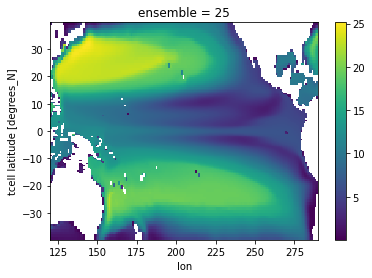

In [41]:
#dat2.replace(0,np.nan)#.plot()
ds_masked = dat2.where(dat2 != 0)
ds_masked.plot()

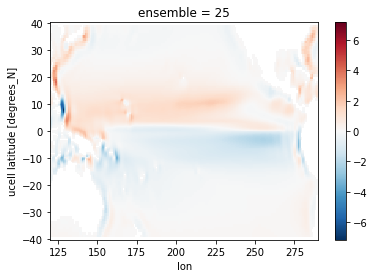

In [31]:
dat1=((cafe_y_tx*1e6)/lon_face_length_m.rename({'lat':'lat_x'}).interp({'lat_x':cafe_y_tx.lat_x})).where(cafe_y_tx.st_ocean>-50).mean(dim='st_ocean').mean(dim='time')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
dat1.plot()

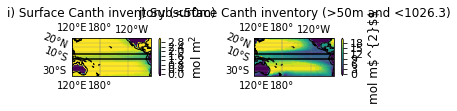

In [42]:
dat1=(adic_plot*st_ocean_holder1.depth_diff/1000).sel(st_ocean=slice(0,-50)).sum(dim='st_ocean').mean(dim='time')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
plot_cartopy_row(dat1,axn=9,sb1=5,sb2=2,title='i) Surface Canth inventory (<50m)',lon='lon',lat='lat',units='mol m$^{2}$',extend='both',cmap='viridis',levs=np.arange(0,3.1,0.1))#np.arange(0,2000,100))#np.arange(0,10000,1000))

# Subsurface
dat2=(adic_plot*st_ocean_holder1.depth_diff/1000).sel(st_ocean=slice(-50,-450)).where(cafe_potential_density.chunk('auto').interp({'lat':adic_plot.lat})<=1026.3).sum(dim='st_ocean').mean(dim='time')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
plot_cartopy_row(dat2,axn=10,sb1=5,sb2=2,title='j) Subsurface Canth inventory (>50m and <1026.3)',lon='lon',lat='lat',units='mol m$^{2}$$',extend='both',cmap='viridis',levs=np.arange(0,21,1))#,levs=np.arange(0,80,10))#np.arange(0,2000,100))#) #np.arange(-30,33,3)

In [ ]:
dat1=(adic_plot*st_ocean_holder1.depth_diff).sel(st_ocean=slice(0,-50)).sum(dim='st_ocean').mean(dim='time')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
plot_cartopy_row(dat1,axn=9,sb1=5,sb2=2,title='i) Surface Canth inventory (<50m)',lon='lon',lat='lat',units='mmol m$^{2}$',extend='both',cmap='viridis',levs=np.arange(0,3250,250))#np.arange(0,2000,100))#np.arange(0,10000,1000))

# Subsurface
dat2=(adic_plot*st_ocean_holder1.depth_diff).sel(st_ocean=slice(-50,-450)).where(cafe_potential_density.chunk('auto').interp({'lat':adic_plot.lat})<=1026.3).sum(dim='st_ocean').mean(dim='time')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
plot_cartopy_row(dat2,axn=10,sb1=5,sb2=2,title='j) Subsurface Canth inventory (>50m and <1026.3)',lon='lon',lat='lat',units='mmol m$^{2}$$',extend='both',cmap='viridis',levs=np.arange(0,3250,250))#,levs=np.arange(0,80,10))#np.arange(0,2000,100))#) #np.arange(-30,33,3)

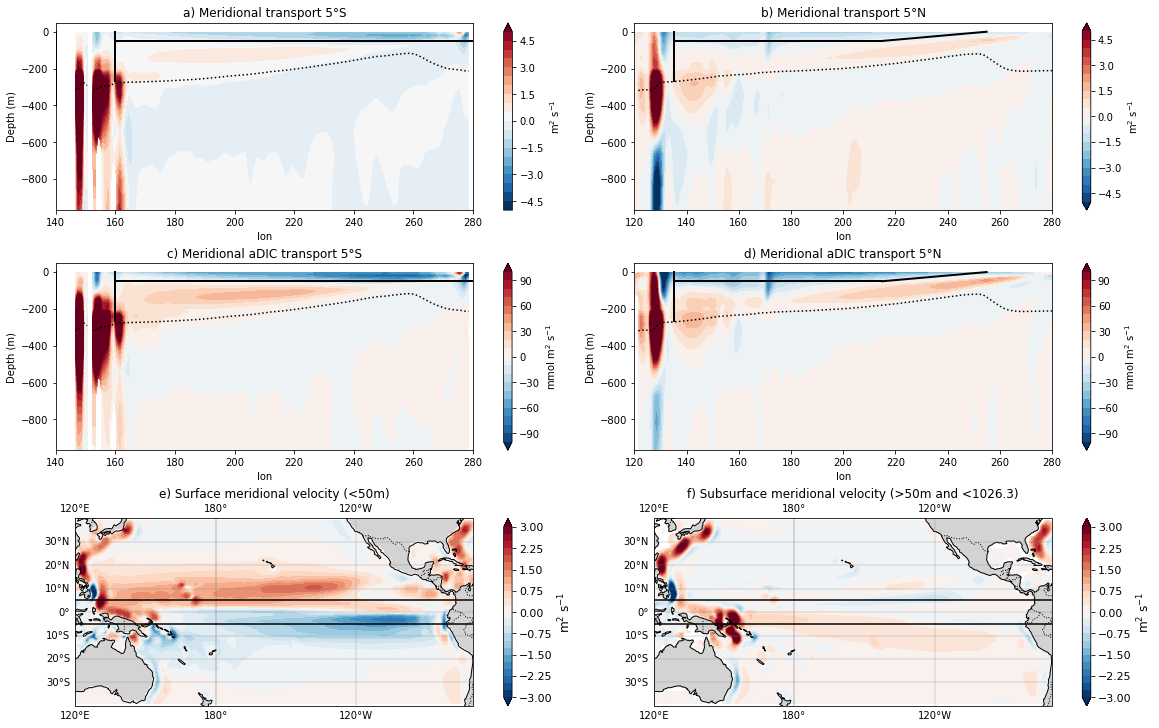

In [23]:
plt.figure(figsize=(16,10),constrained_layout=True)
  
# Sometimes need to run this tice?
plt.subplot(3,2,1)
cplot=(cafe_y_tx*1e6/lon_face_length_m.rename({'lat':'lat_x'}).interp({'lat_x':cafe_y_tx.lat_x})).sel(lat_x=-5,method='nearest').mean(dim='time').plot.contourf(levels=np.arange(-5,5.5,0.5),cmap='RdBu_r',cbar_kwargs={'label': 'm$^{2}$ s$^{-1}$'})#sel(time='2000-01-01').plot()


plt.plot([160,280],[-50,-50],c='k',linewidth=2)
plt.plot([140,140],[-400,0],c='k',linewidth=2)
plt.plot([160,160],[-265,0],c='k',linewidth=2)
cafe_potential_density.chunk('auto').sel(lat=-5.1,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')
plt.title('a) Meridional transport 5°S')
plt.xlim([140,280])
#plt.ylim([-500,0])
plt.ylabel('Depth (m)')


plt.subplot(3,2,2)
cplot=((-cafe_y_tx*1e6/lon_face_length_m.rename({'lat':'lat_x'}).interp({'lat_x':cafe_y_tx.lat_x}))).sel(lat_x=5,method='nearest').mean(dim='time').plot.contourf(levels=np.arange(-5,5.5,0.5),cmap='RdBu_r', cbar_kwargs={'label': 'm$^{2}$ s$^{-1}$'})#sel(time='2000-01-01').plot()


plt.plot([135,215],[-50,-50],c='k',linewidth=2)
plt.plot([215,255],[-50,-0],c='k',linewidth=2)
plt.plot([115,115],[-400,0],c='k',linewidth=2)
plt.plot([135,135],[-265,0],c='k',linewidth=2)
cafe_potential_density.chunk('auto').sel(lat=5,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')
plt.xlim([120,280])
plt.ylabel('Depth (m)')
#plt.ylim([-500,0])
plt.title('b) Meridional transport 5°N')

                
plt.subplot(3,2,3)

(anth_dic_v_tx/lon_face_length_m.interp({'lat':anth_dic_v_tx.lat})).sel(lat=-5,method='nearest').mean(dim='time').plot.contourf(levels=np.arange(-100,110,10),cmap='RdBu_r',cbar_kwargs={'label': 'mmol m$^{2}$ s$^{-1}$'})#sel(time='2000-01-01').plot()

plt.plot([160,280],[-50,-50],c='k',linewidth=2)
plt.plot([140,140],[-400,0],c='k',linewidth=2)
plt.plot([160,160],[-265,0],c='k',linewidth=2)
cafe_potential_density.chunk('auto').sel(lat=-5.1,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')
plt.title('c) Meridional aDIC transport 5°S')
plt.xlim([140,280])
#plt.ylim([-500,0])
plt.ylabel('Depth (m)')

plt.subplot(3,2,4)

(-anth_dic_v_tx/lon_face_length_m.interp({'lat':anth_dic_v_tx.lat})).sel(lat=5,method='nearest').mean(dim='time').plot.contourf(levels=np.arange(-100,110,10),cmap='RdBu_r',cbar_kwargs={'label': 'mmol m$^{2}$ s$^{-1}$'})#sel(time='2000-01-01').plot()

plt.plot([135,215],[-50,-50],c='k',linewidth=2)
plt.plot([215,255],[-50,-0],c='k',linewidth=2)
plt.plot([115,115],[-400,0],c='k',linewidth=2)
plt.plot([135,135],[-265,0],c='k',linewidth=2)
cafe_potential_density.chunk('auto').sel(lat=5,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')
plt.title('d) Meridional aDIC transport 5°N')
plt.xlim([120,280])
#plt.ylim([-500,0])
plt.ylabel('Depth (m)')


dat1=((cafe_y_tx*1e6)/lon_face_length_m.rename({'lat':'lat_x'}).interp({'lat_x':cafe_y_tx.lat_x})).where(cafe_y_tx.st_ocean>-50).mean(dim='st_ocean').mean(dim='time')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
plot_cartopy_row(dat1,axn=5,sb1=3,sb2=2,title='e) Surface meridional velocity (<50m)',lon='lon',lat='lat_x',units='m$^{2}$ s$^{-1}$',levs=np.arange(-3,3.25,0.25),extend='both')

# Subsurface
dat2=((cafe_y_tx*1e6)/lon_face_length_m.rename({'lat':'lat_x'}).interp({'lat_x':cafe_y_tx.lat_x})).where(cafe_y_tx.st_ocean<-50).where(cafe_potential_density.chunk('auto').rename({'lat':'lat_x'}).interp({'lat_x':cafe_y_tx.lat_x})<=1026.3).mean(dim='st_ocean').mean(dim='time')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
plot_cartopy_row(dat2,axn=6,sb1=3,sb2=2,title='f) Subsurface meridional velocity (>50m and <1026.3)',lon='lon',lat='lat_x',units='m$^{2}$ s$^{-1}$',levs=np.arange(-3,3.25,0.25),extend='both')


#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

#plt.tight_layout()
plt.show()

In [39]:
plt.figure(figsize=(16,10),constrained_layout=True)
  
# Sometimes need to run this tice?
plt.subplot(3,2,1)
cplot=(cafe_y_tx*1e6/lon_face_length_m.rename({'lat':'lat_x'}).interp({'lat_x':cafe_y_tx.lat_x})).sel(lat_x=-5,method='nearest').mean(dim='time').plot.contourf(levels=np.arange(-5,5.5,0.5),cmap='RdBu_r',cbar_kwargs={'label': 'm$^{2}$ s$^{-1}$'})#sel(time='2000-01-01').plot()


plt.plot([160,280],[-50,-50],c='k',linewidth=2)
plt.plot([140,140],[-400,0],c='k',linewidth=2)
plt.plot([160,160],[-265,0],c='k',linewidth=2)
cafe_potential_density.chunk('auto').sel(lat=-5.1,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')
plt.title('a) Meridional transport 5°S')
plt.xlim([140,280])
plt.ylim([-500,0])
plt.ylabel('Depth (m)')


plt.subplot(3,2,2)
cplot=((-cafe_y_tx*1e6/lon_face_length_m.rename({'lat':'lat_x'}).interp({'lat_x':cafe_y_tx.lat_x}))).sel(lat_x=5,method='nearest').mean(dim='time').plot.contourf(levels=np.arange(-5,5.5,0.5),cmap='RdBu_r', cbar_kwargs={'label': 'm$^{2}$ s$^{-1}$'})#sel(time='2000-01-01').plot()


plt.plot([135,215],[-50,-50],c='k',linewidth=2)
plt.plot([215,255],[-50,-0],c='k',linewidth=2)
plt.plot([115,115],[-400,0],c='k',linewidth=2)
plt.plot([135,135],[-265,0],c='k',linewidth=2)
cafe_potential_density.chunk('auto').sel(lat=5,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')
plt.xlim([120,280])
plt.ylabel('Depth (m)')
plt.ylim([-500,0])
plt.title('b) Meridional transport 5°N')

                
plt.subplot(3,2,3)

(anth_dic_v_tx/lon_face_length_m.interp({'lat':anth_dic_v_tx.lat})).sel(lat=-5,method='nearest').mean(dim='time').plot.contourf(levels=np.arange(-100,110,10),cmap='RdBu_r',cbar_kwargs={'label': 'mmol m$^{2}$ s$^{-1}$'})#sel(time='2000-01-01').plot()

plt.plot([160,280],[-50,-50],c='k',linewidth=2)
plt.plot([140,140],[-400,0],c='k',linewidth=2)
plt.plot([160,160],[-265,0],c='k',linewidth=2)
cafe_potential_density.chunk('auto').sel(lat=-5.1,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')
plt.title('c) Meridional aDIC transport 5°S')
plt.xlim([140,280])
plt.ylim([-500,0])
plt.ylabel('Depth (m)')

plt.subplot(3,2,4)

(-anth_dic_v_tx/lon_face_length_m.interp({'lat':anth_dic_v_tx.lat})).sel(lat=5,method='nearest').mean(dim='time').plot.contourf(levels=np.arange(-100,110,10),cmap='RdBu_r',cbar_kwargs={'label': 'mmol m$^{2}$ s$^{-1}$'})#sel(time='2000-01-01').plot()

plt.plot([135,215],[-50,-50],c='k',linewidth=2)
plt.plot([215,255],[-50,-0],c='k',linewidth=2)
plt.plot([115,115],[-400,0],c='k',linewidth=2)
plt.plot([135,135],[-265,0],c='k',linewidth=2)
cafe_potential_density.chunk('auto').sel(lat=5,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')
plt.title('d) Meridional aDIC transport 5°N')
plt.xlim([120,280])
plt.ylim([-500,0])
plt.ylabel('Depth (m)')


dat1=((cafe_y_tx*1e6)/lon_face_length_m.rename({'lat':'lat_x'}).interp({'lat_x':cafe_y_tx.lat_x})).where(cafe_y_tx.st_ocean>-50).mean(dim='st_ocean').mean(dim='time')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
plot_cartopy_row(dat1,axn=5,sb1=3,sb2=2,title='e) Surface meridional velocity (<50m)',lon='lon',lat='lat_x',units='m$^{2}$ s$^{-1}$',levs=np.arange(-3,3.25,0.25),extend='both')

# Subsurface
dat2=((cafe_y_tx*1e6)/lon_face_length_m.rename({'lat':'lat_x'}).interp({'lat_x':cafe_y_tx.lat_x})).where(cafe_y_tx.st_ocean<-50).where(cafe_potential_density.chunk('auto').rename({'lat':'lat_x'}).interp({'lat_x':cafe_y_tx.lat_x})<=1026.3).mean(dim='st_ocean').mean(dim='time')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
plot_cartopy_row(dat2,axn=6,sb1=3,sb2=2,title='f) Subsurface meridional velocity (>50m and <1026.3)',lon='lon',lat='lat_x',units='m$^{2}$ s$^{-1}$',levs=np.arange(-3,3.25,0.25),extend='both')


#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

#plt.tight_layout()
plt.show()

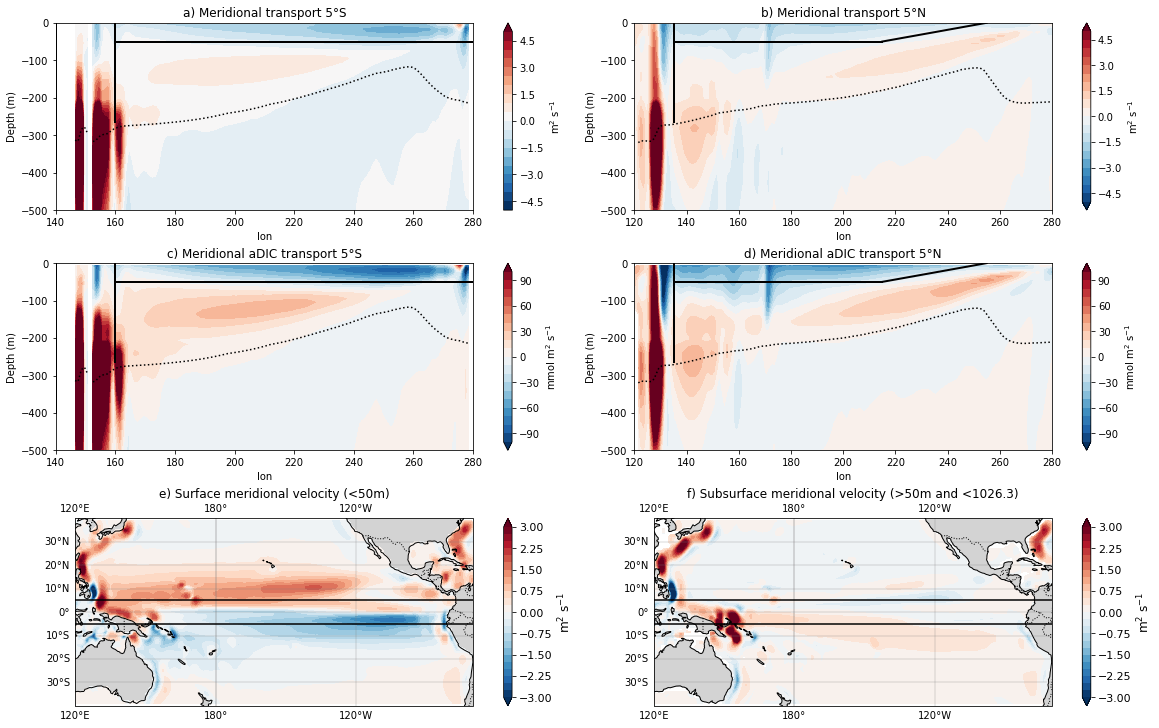

In [39]:
plt.figure(figsize=(16,10),constrained_layout=True)
  
# Sometimes need to run this tice?
plt.subplot(3,2,1)
cplot=(cafe_y_tx*1e6/lon_face_length_m.rename({'lat':'lat_x'}).interp({'lat_x':cafe_y_tx.lat_x})).sel(lat_x=-5,method='nearest').mean(dim='time').plot.contourf(levels=np.arange(-5,5.5,0.5),cmap='RdBu_r',cbar_kwargs={'label': 'm$^{2}$ s$^{-1}$'})#sel(time='2000-01-01').plot()


plt.plot([160,280],[-50,-50],c='k',linewidth=2)
plt.plot([140,140],[-400,0],c='k',linewidth=2)
plt.plot([160,160],[-265,0],c='k',linewidth=2)
cafe_potential_density.chunk('auto').sel(lat=-5.1,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')
plt.title('a) Meridional transport 5°S')
plt.xlim([140,280])
plt.ylim([-500,0])
plt.ylabel('Depth (m)')


plt.subplot(3,2,2)
cplot=((-cafe_y_tx*1e6/lon_face_length_m.rename({'lat':'lat_x'}).interp({'lat_x':cafe_y_tx.lat_x}))).sel(lat_x=5,method='nearest').mean(dim='time').plot.contourf(levels=np.arange(-5,5.5,0.5),cmap='RdBu_r', cbar_kwargs={'label': 'm$^{2}$ s$^{-1}$'})#sel(time='2000-01-01').plot()


plt.plot([135,215],[-50,-50],c='k',linewidth=2)
plt.plot([215,255],[-50,-0],c='k',linewidth=2)
plt.plot([115,115],[-400,0],c='k',linewidth=2)
plt.plot([135,135],[-265,0],c='k',linewidth=2)
cafe_potential_density.chunk('auto').sel(lat=5,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')
plt.xlim([120,280])
plt.ylabel('Depth (m)')
plt.ylim([-500,0])
plt.title('b) Meridional transport 5°N')

                
plt.subplot(3,2,3)

(anth_dic_v_tx/lon_face_length_m.interp({'lat':anth_dic_v_tx.lat})).sel(lat=-5,method='nearest').mean(dim='time').plot.contourf(levels=np.arange(-100,110,10),cmap='RdBu_r',cbar_kwargs={'label': 'mmol m$^{2}$ s$^{-1}$'})#sel(time='2000-01-01').plot()

plt.plot([160,280],[-50,-50],c='k',linewidth=2)
plt.plot([140,140],[-400,0],c='k',linewidth=2)
plt.plot([160,160],[-265,0],c='k',linewidth=2)
cafe_potential_density.chunk('auto').sel(lat=-5.1,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')
plt.title('c) Meridional aDIC transport 5°S')
plt.xlim([140,280])
plt.ylim([-500,0])
plt.ylabel('Depth (m)')

plt.subplot(3,2,4)

(-anth_dic_v_tx/lon_face_length_m.interp({'lat':anth_dic_v_tx.lat})).sel(lat=5,method='nearest').mean(dim='time').plot.contourf(levels=np.arange(-100,110,10),cmap='RdBu_r',cbar_kwargs={'label': 'mmol m$^{2}$ s$^{-1}$'})#sel(time='2000-01-01').plot()

plt.plot([135,215],[-50,-50],c='k',linewidth=2)
plt.plot([215,255],[-50,-0],c='k',linewidth=2)
plt.plot([115,115],[-400,0],c='k',linewidth=2)
plt.plot([135,135],[-265,0],c='k',linewidth=2)
cafe_potential_density.chunk('auto').sel(lat=5,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')
plt.title('d) Meridional aDIC transport 5°N')
plt.xlim([120,280])
plt.ylim([-500,0])
plt.ylabel('Depth (m)')


dat1=((cafe_y_tx*1e6)/lon_face_length_m.rename({'lat':'lat_x'}).interp({'lat_x':cafe_y_tx.lat_x})).where(cafe_y_tx.st_ocean>-50).mean(dim='st_ocean').mean(dim='time')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
plot_cartopy_row(dat1,axn=5,sb1=3,sb2=2,title='e) Surface meridional velocity (<50m)',lon='lon',lat='lat_x',units='m$^{2}$ s$^{-1}$',levs=np.arange(-3,3.25,0.25),extend='both')

# Subsurface
dat2=((cafe_y_tx*1e6)/lon_face_length_m.rename({'lat':'lat_x'}).interp({'lat_x':cafe_y_tx.lat_x})).where(cafe_y_tx.st_ocean<-50).where(cafe_potential_density.chunk('auto').rename({'lat':'lat_x'}).interp({'lat_x':cafe_y_tx.lat_x})<=1026.3).mean(dim='st_ocean').mean(dim='time')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
plot_cartopy_row(dat2,axn=6,sb1=3,sb2=2,title='f) Subsurface meridional velocity (>50m and <1026.3)',lon='lon',lat='lat_x',units='m$^{2}$ s$^{-1}$',levs=np.arange(-3,3.25,0.25),extend='both')


#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

#plt.tight_layout()
plt.show()

/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/xarray_trends.py:68: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  stat = xr.apply_ufunc(lin_xarray_linregress, x,y,


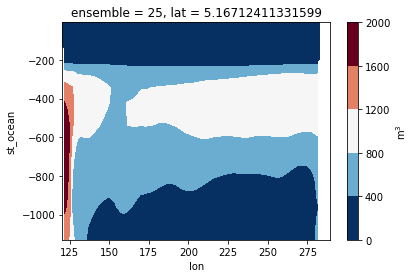

In [67]:
xarray_get_trend(adic_plot.sel(lat=5,method='nearest').chunk(dict(time=-1))).sel(parameter=1).plot.contourf(cmap='RdBu_r', cbar_kwargs={'label': 'm$^{3}$'})

In [25]:
adic_plot2=anth_dic_cafe#.sel(st_ocean=slice(0,1200))
adic_plot2['st_ocean']=adic_plot2['st_ocean']*-1
#adic_plot2=adic_plot2/adic_plot2.depth_diff
adic_plot2=adic_plot2.sel(time=slice('2000','2020')).load()

Text(0.5, 1.0, 'b) Anth DIC 5°N')

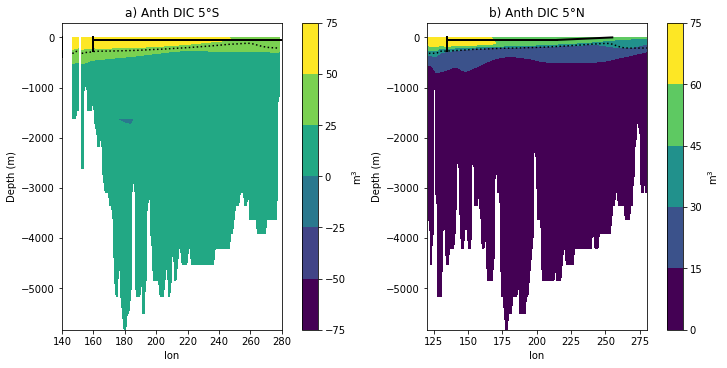

In [26]:
plt.figure(figsize=(10,5),constrained_layout=True)
  
plt.subplot(1,2,1)#levels=np.arange(-5,5.5,0.5)
(adic_plot2.sel(lat=-5,method='nearest').mean(dim='time').plot.contourf(cmap='viridis',cbar_kwargs={'label': 'm$^{3}$'}))


plt.plot([160,280],[-50,-50],c='k',linewidth=2)
plt.plot([140,140],[-400,0],c='k',linewidth=2)
plt.plot([160,160],[-265,0],c='k',linewidth=2)
cafe_potential_density.chunk('auto').sel(lat=-5.1,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')
plt.title('a) Anth DIC 5°S')
plt.xlim([140,280])
#plt.ylim([-1000,0])
plt.ylabel('Depth (m)')


plt.subplot(1,2,2)
(adic_plot2.sel(lat=5,method='nearest').mean(dim='time').plot.contourf(cmap='viridis', cbar_kwargs={'label': 'm$^{3}$'}))


plt.plot([135,215],[-50,-50],c='k',linewidth=2)
plt.plot([215,255],[-50,-0],c='k',linewidth=2)
plt.plot([115,115],[-400,0],c='k',linewidth=2)
plt.plot([135,135],[-265,0],c='k',linewidth=2)
cafe_potential_density.chunk('auto').sel(lat=5,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')
plt.xlim([120,280])
plt.ylabel('Depth (m)')
#plt.ylim([-1000,0])
plt.title('b) Anth DIC 5°N')

In [87]:
vals=xarray_get_trend(adic_plot.where(adic_plot.st_ocean>-50).mean(dim='st_ocean').chunk(dict(time=-1)))
vals

/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/xarray_trends.py:68: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  stat = xr.apply_ufunc(lin_xarray_linregress, x,y,


<xarray.DataArray (lat: 140, lon: 170, parameter: 5)>
dask.array<transpose, shape=(140, 170, 5), dtype=float64, chunksize=(140, 170, 5), chunktype=numpy.ndarray>
Coordinates:
    ensemble  int32 25
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
Dimensions without coordinates: parameter

<xarray.DataArray (lat: 140, lon: 170)>
dask.array<getitem, shape=(140, 170), dtype=float64, chunksize=(140, 170), chunktype=numpy.ndarray>
Coordinates:
    ensemble  int32 25
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34

In [35]:
adic_plot=anth_dic_cafe.sel(st_ocean=slice(0,-1200))
#adic_plot['st_ocean']=adic_plot['st_ocean']*-1
#adic_plot=adic_plot*adic_plot.depth_diff
adic_plot=adic_plot.sel(time=slice('2000','2020')).load()

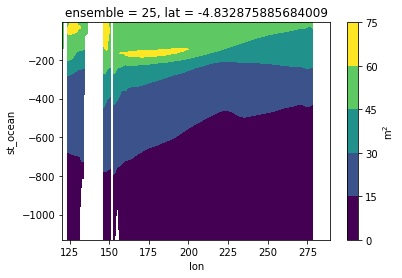

In [36]:
(adic_plot.sel(lat=-5,method='nearest').mean(dim='time').plot.contourf(cmap='viridis',cbar_kwargs={'label': 'm$^{2}$'}))

/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/xarray_trends.py:68: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  stat = xr.apply_ufunc(lin_xarray_linregress, x,y,
/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/xarray_trends.py:68: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  stat = xr.apply_ufunc(lin_xarray_linregress, x,y,
/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/xarray_trends.py:68: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  stat = xr.apply_ufunc(lin_xarray_linregress, x,y,
/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/xarray_trends.py:68: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be remov

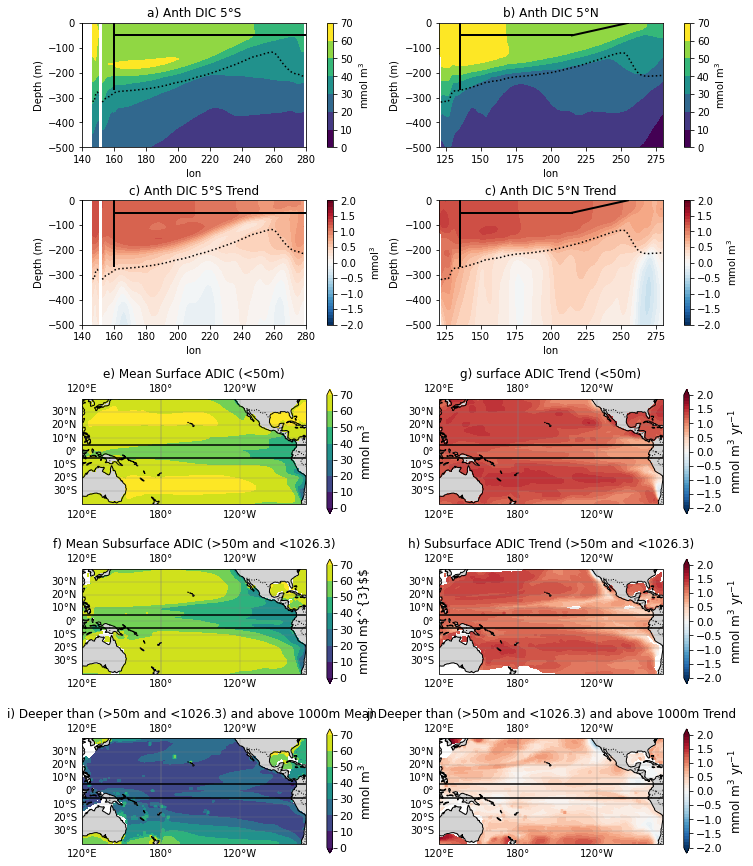

In [39]:
plt.figure(figsize=(10,12),constrained_layout=True)
  
plt.subplot(5,2,1)
(adic_plot.sel(lat=-5,method='nearest').mean(dim='time').plot.contourf(cmap='viridis',cbar_kwargs={'label': 'mmol m$^{3}$'},levels=np.arange(0,80,10)))#10000,1000)))


plt.plot([160,280],[-50,-50],c='k',linewidth=2)
plt.plot([140,140],[-400,0],c='k',linewidth=2)
plt.plot([160,160],[-265,0],c='k',linewidth=2)
cafe_potential_density.chunk('auto').sel(lat=-5.1,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')
plt.title('a) Anth DIC 5°S')
plt.xlim([140,280])
plt.ylim([-500,0])
plt.ylabel('Depth (m)')


plt.subplot(5,2,2)
(adic_plot.sel(lat=5,method='nearest').mean(dim='time').plot.contourf(cmap='viridis', cbar_kwargs={'label': 'mmol m$^{3}$'},levels=np.arange(0,80,10)))##,levels=np.arange(0,10000,1000)))#np.arange(0,2200,200)))


plt.plot([135,215],[-50,-50],c='k',linewidth=2)
plt.plot([215,255],[-50,-0],c='k',linewidth=2)
plt.plot([115,115],[-400,0],c='k',linewidth=2)
plt.plot([135,135],[-265,0],c='k',linewidth=2)
cafe_potential_density.chunk('auto').sel(lat=5,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')
plt.xlim([120,280])
plt.ylabel('Depth (m)')
plt.ylim([-500,0])
plt.title('b) Anth DIC 5°N')

                
plt.subplot(5,2,3)

(xarray_get_trend(adic_plot.sel(lat=-5,method='nearest').chunk(dict(time=-1))).sel(parameter=0)*365).plot.contourf(cmap='RdBu_r', cbar_kwargs={'label': 'mmol$^{3}$'},levels=np.arange(-2,2.1,0.1))#np.arange(-30,33,3))#sel(time='2000-01-01').plot()

plt.plot([160,280],[-50,-50],c='k',linewidth=2)
plt.plot([140,140],[-400,0],c='k',linewidth=2)
plt.plot([160,160],[-265,0],c='k',linewidth=2)
cafe_potential_density.chunk('auto').sel(lat=-5.1,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')
plt.title('c) Anth DIC 5°S Trend')
plt.xlim([140,280])
plt.ylim([-500,0])
plt.ylabel('Depth (m)')

plt.subplot(5,2,4)

(xarray_get_trend(adic_plot.sel(lat=5,method='nearest').chunk(dict(time=-1))).sel(parameter=0)*365).plot.contourf(cmap='RdBu_r', cbar_kwargs={'label': 'mmol m$^{3}$'},levels=np.arange(-2,2.1,0.1))#sel(time='2000-01-01').plot()

plt.plot([135,215],[-50,-50],c='k',linewidth=2)
plt.plot([215,255],[-50,-0],c='k',linewidth=2)
plt.plot([115,115],[-400,0],c='k',linewidth=2)
plt.plot([135,135],[-265,0],c='k',linewidth=2)
cafe_potential_density.chunk('auto').sel(lat=5,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')
plt.title('c) Anth DIC 5°N Trend')
plt.xlim([120,280])
plt.ylim([-500,0])
plt.ylabel('Depth (m)')

dat1=adic_plot.where(adic_plot.st_ocean>-50).mean(dim='st_ocean').mean(dim='time')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
plot_cartopy_row(dat1,axn=5,sb1=5,sb2=2,title='e) Mean Surface ADIC (<50m)',lon='lon',lat='lat',units='mmol m$^{3}$',extend='both',cmap='viridis',levs=np.arange(0,80,10))#np.arange(0,2000,100))#np.arange(0,10000,1000))

# Subsurface
dat2=adic_plot.where(adic_plot.st_ocean<-50).where(cafe_potential_density.chunk('auto').interp({'lat':adic_plot.lat})<=1026.3).mean(dim='st_ocean').mean(dim='time')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
plot_cartopy_row(dat2,axn=7,sb1=5,sb2=2,title='f) Mean Subsurface ADIC (>50m and <1026.3)',lon='lon',lat='lat',units='mmol m$^{3}$$',extend='both',cmap='viridis',levs=np.arange(0,80,10))#np.arange(0,2000,100))#) #np.arange(-30,33,3)


       
dat1=(xarray_get_trend(adic_plot.where(adic_plot.st_ocean>-50).mean(dim='st_ocean').chunk(dict(time=-1))).sel(parameter=0)*365)#.mean(dim='time')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
plot_cartopy_row(dat1,axn=6,sb1=5,sb2=2,title='g) surface ADIC Trend (<50m)',lon='lon',lat='lat',units='mmol m$^{3}$ yr$^{-1}$',extend='both',cmap='RdBu_r',levs=np.arange(-2,2.1,0.1))#np.arange(-150,160,10))

# Subsurface
dat2=(xarray_get_trend(adic_plot.where(adic_plot.st_ocean<-50).where(cafe_potential_density.chunk('auto').rename({'lat':'lat'}).interp({'lat':adic_plot.lat})<=1026.3).mean(dim='st_ocean').chunk(dict(time=-1))).sel(parameter=0)*365)#.mean(dim='time')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
plot_cartopy_row(dat2,axn=8,sb1=5,sb2=2,title='h) Subsurface ADIC Trend (>50m and <1026.3)',lon='lon',lat='lat',units='mmol m$^{3}$ yr$^{-1}$',extend='both',cmap='RdBu_r',levs=np.arange(-2,2.1,0.1))#np.arange(0,55,5))#np.arange(-150,160,10))#np.arange(-30,33,3),

# Subsurface
dat2=adic_plot.where(adic_plot.st_ocean>-1000).where(cafe_potential_density.chunk('auto').rename({'lat':'lat'}).interp({'lat':adic_plot.lat})>=1026.3).mean(dim='st_ocean').mean(dim='time')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
plot_cartopy_row(dat2,axn=9,sb1=5,sb2=2,title='i) Deeper than (>50m and <1026.3) and above 1000m Mean ',lon='lon',lat='lat',units='mmol m$^{3}$',extend='both',cmap='viridis',levs=np.arange(0,80,10))#np.arange(0,2000,100))#np.arange(-150,160,10))#np.arange(-30,33,3),

# Subsurface
dat2=(xarray_get_trend(adic_plot.where(adic_plot.st_ocean>-1000).where(cafe_potential_density.chunk('auto').rename({'lat':'lat'}).interp({'lat':adic_plot.lat})>=1026.3).mean(dim='st_ocean').chunk(dict(time=-1))).sel(parameter=0)*365)#.mean(dim='time')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
plot_cartopy_row(dat2,axn=10,sb1=5,sb2=2,title='j) Deeper than (>50m and <1026.3) and above 1000m Trend',lon='lon',lat='lat',units='mmol m$^{3}$ yr$^{-1}$',extend='both',cmap='RdBu_r',levs=np.arange(-2,2.1,0.1))#np.arange(0,55,5))#np.arange(-150,160,10))#np.arange(-30,33,3),

#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

#plt.tight_layout()
plt.show()

In [106]:
tot_anth_dic_cafe.sel(st_ocean=slice(0,-1200))#

<xarray.DataArray (time: 731, st_ocean: 31, lat: 140, lon: 170)>
dask.array<getitem, shape=(731, 31, 140, 170), dtype=float64, chunksize=(87, 31, 70, 85), chunktype=numpy.ndarray>
Coordinates:
    ensemble    int32 25
  * st_ocean    (st_ocean) float64 -5.0 -15.0 -25.0 ... -812.8 -969.1 -1.131e+03
  * time        (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lon         (lon) float64 120.5 121.5 122.5 123.5 ... 287.5 288.5 289.5
  * lat         (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
    depth_diff  (st_ocean) float64 5.0 10.0 10.0 10.0 ... 147.4 156.3 161.9

In [40]:
totdic_plot=tot_anth_dic_cafe.sel(st_ocean=slice(0,-1200))
#totdic_plot['st_ocean']=totdic_plot['st_ocean']*-1
#totdic_plot=totdic_plot*adic_plot.depth_diff
totdic_plot=totdic_plot.sel(time=slice('2000','2020')).load()

/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/xarray_trends.py:68: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  stat = xr.apply_ufunc(lin_xarray_linregress, x,y,
/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/xarray_trends.py:68: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  stat = xr.apply_ufunc(lin_xarray_linregress, x,y,
/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/xarray_trends.py:68: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  stat = xr.apply_ufunc(lin_xarray_linregress, x,y,
/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/xarray_trends.py:68: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be remov

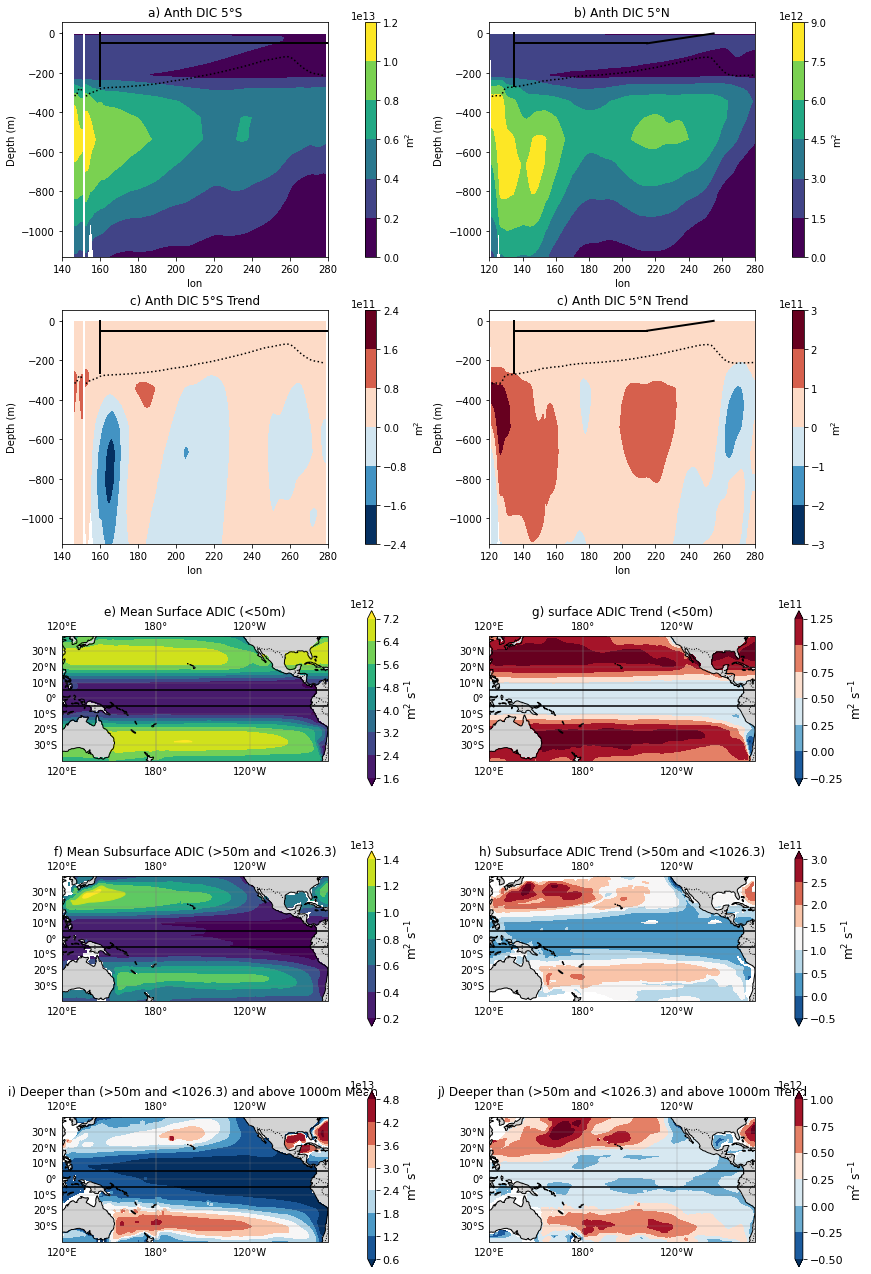

In [41]:
plt.figure(figsize=(12,18),constrained_layout=True)
  
plt.subplot(5,2,1)
(totdic_plot.sel(lat=-5,method='nearest').mean(dim='time').plot.contourf(cmap='viridis',cbar_kwargs={'label': 'm$^{2}$'},levels=None))#levels=np.arange(0,10000,1000)))


plt.plot([160,280],[-50,-50],c='k',linewidth=2)
plt.plot([140,140],[-400,0],c='k',linewidth=2)
plt.plot([160,160],[-265,0],c='k',linewidth=2)
cafe_potential_density.chunk('auto').sel(lat=-5.1,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')
plt.title('a) Anth DIC 5°S')
plt.xlim([140,280])
#plt.ylim([-500,0])
plt.ylabel('Depth (m)')


plt.subplot(5,2,2)
(totdic_plot.sel(lat=5,method='nearest').mean(dim='time').plot.contourf(cmap='viridis', cbar_kwargs={'label': 'm$^{2}$'},levels=None))#,levels=np.arange(0,10000,1000)))#np.arange(0,2200,200)))


plt.plot([135,215],[-50,-50],c='k',linewidth=2)
plt.plot([215,255],[-50,-0],c='k',linewidth=2)
plt.plot([115,115],[-400,0],c='k',linewidth=2)
plt.plot([135,135],[-265,0],c='k',linewidth=2)
cafe_potential_density.chunk('auto').sel(lat=5,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')
plt.xlim([120,280])
plt.ylabel('Depth (m)')
#plt.ylim([-500,0])
plt.title('b) Anth DIC 5°N')

                
plt.subplot(5,2,3)

(xarray_get_trend(totdic_plot.sel(lat=-5,method='nearest').chunk(dict(time=-1))).sel(parameter=0)*365).plot.contourf(cmap='RdBu_r', cbar_kwargs={'label': 'm$^{2}$'},levels=None)#,levels=np.arange(-150,160,10))#np.arange(-30,33,3))#sel(time='2000-01-01').plot()

plt.plot([160,280],[-50,-50],c='k',linewidth=2)
plt.plot([140,140],[-400,0],c='k',linewidth=2)
plt.plot([160,160],[-265,0],c='k',linewidth=2)
cafe_potential_density.chunk('auto').sel(lat=-5.1,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')
plt.title('c) Anth DIC 5°S Trend')
plt.xlim([140,280])
#plt.ylim([-500,0])
plt.ylabel('Depth (m)')

plt.subplot(5,2,4)

(xarray_get_trend(totdic_plot.sel(lat=5,method='nearest').chunk(dict(time=-1))).sel(parameter=0)*365).plot.contourf(cmap='RdBu_r', cbar_kwargs={'label': 'm$^{2}$'},levels=None)#,levels=np.arange(-150,160,10))#sel(time='2000-01-01').plot()

plt.plot([135,215],[-50,-50],c='k',linewidth=2)
plt.plot([215,255],[-50,-0],c='k',linewidth=2)
plt.plot([115,115],[-400,0],c='k',linewidth=2)
plt.plot([135,135],[-265,0],c='k',linewidth=2)
cafe_potential_density.chunk('auto').sel(lat=5,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')
plt.title('c) Anth DIC 5°N Trend')
plt.xlim([120,280])
#plt.ylim([-500,0])
plt.ylabel('Depth (m)')


dat1=totdic_plot.where(totdic_plot.st_ocean>-50).mean(dim='st_ocean').mean(dim='time')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
plot_cartopy_row(dat1,axn=5,sb1=5,sb2=2,title='e) Mean Surface ADIC (<50m)',lon='lon',lat='lat',units='m$^{2}$ s$^{-1}$',extend='both',cmap='viridis',levs=None)#np.arange(0,10000,1000))

# Subsurface
dat2=totdic_plot.where(totdic_plot.st_ocean<-50).where(cafe_potential_density.chunk('auto').interp({'lat':totdic_plot.lat})<=1026.3).mean(dim='st_ocean').mean(dim='time')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
plot_cartopy_row(dat2,axn=7,sb1=5,sb2=2,title='f) Mean Subsurface ADIC (>50m and <1026.3)',lon='lon',lat='lat',units='m$^{2}$ s$^{-1}$',extend='both',cmap='viridis',levs=None)#) #np.arange(-30,33,3)


       
dat1=(xarray_get_trend(totdic_plot.where(totdic_plot.st_ocean>-50).mean(dim='st_ocean').chunk(dict(time=-1))).sel(parameter=0)*365)#.mean(dim='time')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
plot_cartopy_row(dat1,axn=6,sb1=5,sb2=2,title='g) surface ADIC Trend (<50m)',lon='lon',lat='lat',units='m$^{2}$ s$^{-1}$',extend='both',cmap='RdBu_r',levs=None)#np.arange(-150,160,10))

# Subsurface
dat2=(xarray_get_trend(totdic_plot.where(totdic_plot.st_ocean<-50).where(cafe_potential_density.chunk('auto').rename({'lat':'lat'}).interp({'lat':totdic_plot.lat})<=1026.3).mean(dim='st_ocean').chunk(dict(time=-1))).sel(parameter=0)*365)#.mean(dim='time')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
plot_cartopy_row(dat2,axn=8,sb1=5,sb2=2,title='h) Subsurface ADIC Trend (>50m and <1026.3)',lon='lon',lat='lat',units='m$^{2}$ s$^{-1}$',extend='both',cmap='RdBu_r',levs=None)#np.arange(-150,160,10))#np.arange(-30,33,3),

# Subsurface
dat2=totdic_plot.where(totdic_plot.st_ocean>-1000).where(cafe_potential_density.chunk('auto').rename({'lat':'lat'}).interp({'lat':totdic_plot.lat})>=1026.3).mean(dim='st_ocean').mean(dim='time')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
plot_cartopy_row(dat2,axn=9,sb1=5,sb2=2,title='i) Deeper than (>50m and <1026.3) and above 1000m Mean ',lon='lon',lat='lat',units='m$^{2}$ s$^{-1}$',extend='both',cmap='RdBu_r',levs=None)#np.arange(-150,160,10))#np.arange(-30,33,3),

# Subsurface
dat2=(xarray_get_trend(totdic_plot.where(totdic_plot.st_ocean>-1000).where(cafe_potential_density.chunk('auto').rename({'lat':'lat'}).interp({'lat':totdic_plot.lat})>=1026.3).mean(dim='st_ocean').chunk(dict(time=-1))).sel(parameter=0)*365)#.mean(dim='time')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
plot_cartopy_row(dat2,axn=10,sb1=5,sb2=2,title='j) Deeper than (>50m and <1026.3) and above 1000m Trend',lon='lon',lat='lat',units='m$^{2}$ s$^{-1}$',extend='both',cmap='RdBu_r',levs=None)#np.arange(-150,160,10))#np.arange(-30,33,3),

#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

#plt.tight_layout()
plt.show()

In [33]:
adic_tx_fortrends_start=anth_dic_v_tx.chunk('auto')#/lon_face_length_m.interp({'lat':anth_dic_v_tx.lat}).chunk('auto')).chunk('auto')
m_div=lon_face_length_m.interp({'lat':anth_dic_v_tx.lat}).chunk('auto').load()
print(adic_tx_fortrends_start.nbytes/1e9)
adic_tx_fortrends_start

2.1026484


<xarray.DataArray '__xarray_dataarray_variable__' (time: 731, st_ocean: 30, lat: 141, lon: 170)>
dask.array<mul, shape=(731, 30, 141, 170), dtype=float32, chunksize=(103, 30, 103, 85), chunktype=numpy.ndarray>
Coordinates:
    ensemble  int32 25
  * st_ocean  (st_ocean) float64 -5.0 -15.0 -25.0 -35.0 ... -665.4 -812.8 -969.1
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -39.9 -38.92 -37.95 -36.96 ... 37.9 38.86 39.81

In [37]:
fortrends_loaded=adic_tx_fortrends_start.load()

In [38]:
adic_tx_fortrends=fortrends_loaded * m_div # or maybe divide

In [ ]:
#.load()#.mean(dim='time')

In [ ]:
plt.figure(figsize=(12,18),constrained_layout=True)
  
plt.subplot(5,2,1)


(adic_tx_fortrends.sel(lat=-5,method='nearest').mean(dim='time').plot.contourf(cmap='viridis',cbar_kwargs={'label': 'm$^{2}$'},levels=None))#levels=np.arange(0,10000,1000)))


plt.plot([160,280],[-50,-50],c='k',linewidth=2)
plt.plot([140,140],[-400,0],c='k',linewidth=2)
plt.plot([160,160],[-265,0],c='k',linewidth=2)
cafe_potential_density.chunk('auto').sel(lat=-5.1,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')
plt.title('a) Anth DIC tx 5°S')
plt.xlim([140,280])
#plt.ylim([-500,0])
plt.ylabel('Depth (m)')


plt.subplot(5,2,2)
((-adic_tx_fortrends).sel(lat=5,method='nearest').mean(dim='time').plot.contourf(cmap='viridis', cbar_kwargs={'label': 'm$^{2}$'},levels=None))#,levels=np.arange(0,10000,1000)))#np.arange(0,2200,200)))


plt.plot([135,215],[-50,-50],c='k',linewidth=2)
plt.plot([215,255],[-50,-0],c='k',linewidth=2)
plt.plot([115,115],[-400,0],c='k',linewidth=2)
plt.plot([135,135],[-265,0],c='k',linewidth=2)
cafe_potential_density.chunk('auto').sel(lat=5,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')
plt.xlim([120,280])
plt.ylabel('Depth (m)')
#plt.ylim([-500,0])
plt.title('b) Anth DIC tx 5°N')

                
plt.subplot(5,2,3)

(xarray_get_trend((adic_tx_fortrends.sel(lat=-5,method='nearest').chunk(dict(time=-1)))).sel(parameter=0)*365).plot.contourf(cmap='RdBu_r', cbar_kwargs={'label': 'm$^{2}$'},levels=None)#,levels=np.arange(-150,160,10))#np.arange(-30,33,3))#sel(time='2000-01-01').plot()

plt.plot([160,280],[-50,-50],c='k',linewidth=2)
plt.plot([140,140],[-400,0],c='k',linewidth=2)
plt.plot([160,160],[-265,0],c='k',linewidth=2)
cafe_potential_density.chunk('auto').sel(lat=-5.1,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')
plt.title('c) Anth DIC tx 5°S Trend')
plt.xlim([140,280])
#plt.ylim([-500,0])
plt.ylabel('Depth (m)')

plt.subplot(5,2,4)

(xarray_get_trend((-adic_tx_fortrends).sel(lat=5,method='nearest').chunk(dict(time=-1))).sel(parameter=0)*365).plot.contourf(cmap='RdBu_r', cbar_kwargs={'label': 'm$^{2}$'},levels=None)#,levels=np.arange(-150,160,10))#sel(time='2000-01-01').plot()

plt.plot([135,215],[-50,-50],c='k',linewidth=2)
plt.plot([215,255],[-50,-0],c='k',linewidth=2)
plt.plot([115,115],[-400,0],c='k',linewidth=2)
plt.plot([135,135],[-265,0],c='k',linewidth=2)
cafe_potential_density.chunk('auto').sel(lat=5,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')
plt.title('c) Anth DIC tx 5°N Trend')
plt.xlim([120,280])
#plt.ylim([-500,0])
plt.ylabel('Depth (m)')


dat1=adic_tx_fortrends.where(adic_tx_fortrends.st_ocean>-50).mean(dim='st_ocean').mean(dim='time')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
plot_cartopy_row(dat1,axn=5,sb1=5,sb2=2,title='e) Mean Surface ADIC tx (<50m)',lon='lon',lat='lat',units='m$^{2}$ s$^{-1}$',extend='both',cmap='viridis',levs=None)#np.arange(0,10000,1000))

# Subsurface
dat2=adic_tx_fortrends.where(adic_tx_fortrends.st_ocean<-50).where(cafe_potential_density.chunk('auto').interp({'lat':adic_tx_fortrends.lat})<=1026.3).mean(dim='st_ocean').mean(dim='time')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
plot_cartopy_row(dat2,axn=7,sb1=5,sb2=2,title='f) Mean Subsurface ADIC tx (>50m and <1026.3)',lon='lon',lat='lat',units='m$^{2}$ s$^{-1}$',extend='both',cmap='viridis',levs=None)#) #np.arange(-30,33,3)


       
dat1=(xarray_get_trend(adic_tx_fortrends.where(adic_tx_fortrends.st_ocean>-50).mean(dim='st_ocean').chunk(dict(time=-1))).sel(parameter=0)*365)#.mean(dim='time')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
plot_cartopy_row(dat1,axn=6,sb1=5,sb2=2,title='g) surface ADIC tx Trend (<50m)',lon='lon',lat='lat',units='m$^{2}$ s$^{-1}$',extend='both',cmap='RdBu_r',levs=None)#np.arange(-150,160,10))

# Subsurface
dat2=(xarray_get_trend(adic_tx_fortrends.where(adic_tx_fortrends.st_ocean<-50).where(cafe_potential_density.chunk('auto').rename({'lat':'lat'}).interp({'lat':adic_tx_fortrends.lat})<=1026.3).mean(dim='st_ocean').chunk(dict(time=-1))).sel(parameter=0)*365)#.mean(dim='time')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
plot_cartopy_row(dat2,axn=8,sb1=5,sb2=2,title='h) Subsurface ADIC tx Trend (>50m and <1026.3)',lon='lon',lat='lat',units='m$^{2}$ s$^{-1}$',extend='both',cmap='RdBu_r',levs=None)#np.arange(-150,160,10))#np.arange(-30,33,3),

# Subsurface
dat2=adic_tx_fortrends.where(adic_tx_fortrends.st_ocean>-1000).where(cafe_potential_density.chunk('auto').rename({'lat':'lat'}).interp({'lat':adic_tx_fortrends.lat})>=1026.3).mean(dim='st_ocean').mean(dim='time')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
plot_cartopy_row(dat2,axn=9,sb1=5,sb2=2,title='i) Deeper than (>50m and <1026.3) and above 1000m Mean ',lon='lon',lat='lat',units='m$^{2}$ s$^{-1}$',extend='both',cmap='RdBu_r',levs=None)#np.arange(-150,160,10))#np.arange(-30,33,3),

# Subsurface
dat2=(xarray_get_trend(adic_tx_fortrends.where(adic_tx_fortrends.st_ocean>-1000).where(cafe_potential_density.chunk('auto').rename({'lat':'lat'}).interp({'lat':adic_tx_fortrends.lat})>=1026.3).mean(dim='st_ocean').chunk(dict(time=-1))).sel(parameter=0)*365)#.mean(dim='time')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
plot_cartopy_row(dat2,axn=10,sb1=5,sb2=2,title='j) Deeper than (>50m and <1026.3) and above 1000m Trend',lon='lon',lat='lat',units='m$^{2}$ s$^{-1}$',extend='both',cmap='RdBu_r',levs=None)#np.arange(-150,160,10))#np.arange(-30,33,3),

#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

#plt.tight_layout()
plt.show()

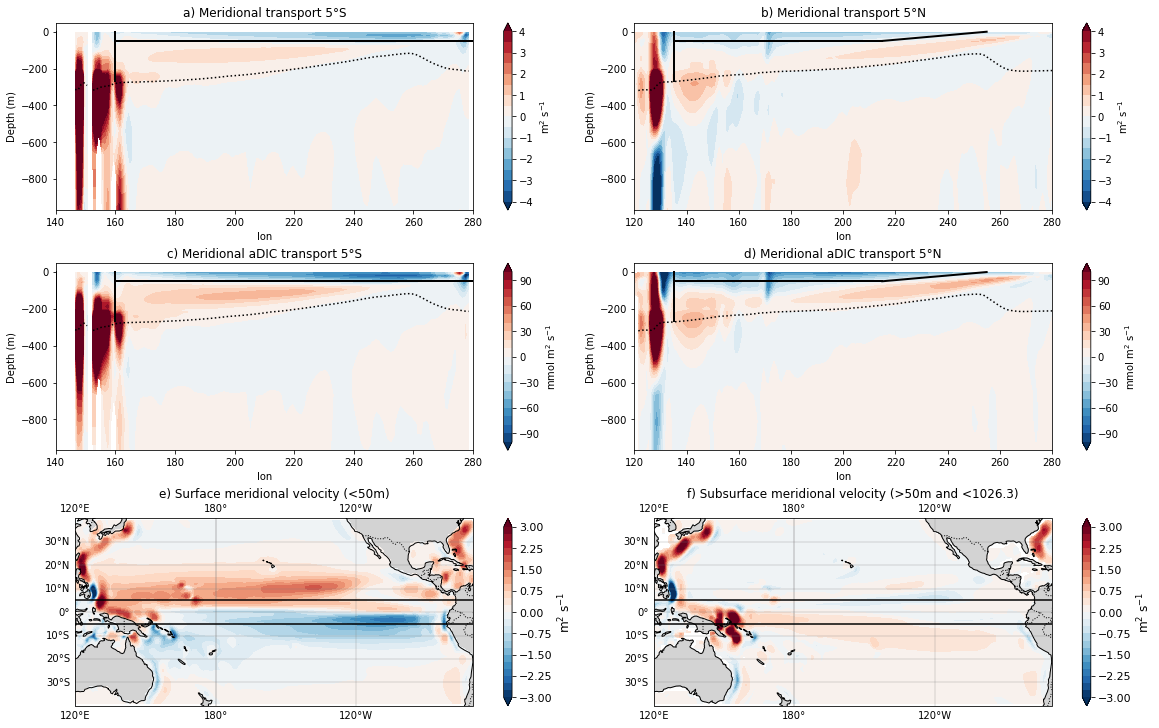

In [67]:
plt.figure(figsize=(16,10),constrained_layout=True)
  
# Sometimes need to run this tice?
plt.subplot(3,2,1)
cplot=(cafe_y_tx*1e6/lon_face_length_m.rename({'lat':'lat_x'}).interp({'lat_x':cafe_y_tx.lat_x})).sel(lat_x=-5,method='nearest').mean(dim='time').plot.contourf(levels=np.arange(-4,4.5,0.5),cmap='RdBu_r',cbar_kwargs={'label': 'm$^{2}$ s$^{-1}$'})#sel(time='2000-01-01').plot()


plt.plot([160,280],[-50,-50],c='k',linewidth=2)
plt.plot([140,140],[-400,0],c='k',linewidth=2)
plt.plot([160,160],[-265,0],c='k',linewidth=2)
cafe_potential_density.chunk('auto').sel(lat=-5.1,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')
plt.title('a) Meridional transport 5°S')
plt.xlim([140,280])
#plt.ylim([-500,0])
plt.ylabel('Depth (m)')


plt.subplot(3,2,2)
cplot=((-cafe_y_tx*1e6/lon_face_length_m.rename({'lat':'lat_x'}).interp({'lat_x':cafe_y_tx.lat_x}))).sel(lat_x=5,method='nearest').mean(dim='time').plot.contourf(levels=np.arange(-4,4.5,0.5),cmap='RdBu_r', cbar_kwargs={'label': 'm$^{2}$ s$^{-1}$'})#sel(time='2000-01-01').plot()


plt.plot([135,215],[-50,-50],c='k',linewidth=2)
plt.plot([215,255],[-50,-0],c='k',linewidth=2)
plt.plot([115,115],[-400,0],c='k',linewidth=2)
plt.plot([135,135],[-265,0],c='k',linewidth=2)
cafe_potential_density.chunk('auto').sel(lat=5,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')
plt.xlim([120,280])
plt.ylabel('Depth (m)')
#plt.ylim([-500,0])
plt.title('b) Meridional transport 5°N')

                
plt.subplot(3,2,3)

(anth_dic_v_tx/lon_face_length_m.interp({'lat':anth_dic_v_tx.lat})).sel(lat=-5,method='nearest').mean(dim='time').plot.contourf(levels=np.arange(-100,110,10),cmap='RdBu_r',cbar_kwargs={'label': 'mmol m$^{2}$ s$^{-1}$'})#sel(time='2000-01-01').plot()

plt.plot([160,280],[-50,-50],c='k',linewidth=2)
plt.plot([140,140],[-400,0],c='k',linewidth=2)
plt.plot([160,160],[-265,0],c='k',linewidth=2)
cafe_potential_density.chunk('auto').sel(lat=-5.1,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')
plt.title('c) Meridional aDIC transport 5°S')
plt.xlim([140,280])
#plt.ylim([-500,0])
plt.ylabel('Depth (m)')

plt.subplot(3,2,4)

(-anth_dic_v_tx/lon_face_length_m.interp({'lat':anth_dic_v_tx.lat})).sel(lat=5,method='nearest').mean(dim='time').plot.contourf(levels=np.arange(-100,110,10),cmap='RdBu_r',cbar_kwargs={'label': 'mmol m$^{2}$ s$^{-1}$'})#sel(time='2000-01-01').plot()

plt.plot([135,215],[-50,-50],c='k',linewidth=2)
plt.plot([215,255],[-50,-0],c='k',linewidth=2)
plt.plot([115,115],[-400,0],c='k',linewidth=2)
plt.plot([135,135],[-265,0],c='k',linewidth=2)
cafe_potential_density.chunk('auto').sel(lat=5,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='k',linestyles=':')
plt.title('d) Meridional aDIC transport 5°N')
plt.xlim([120,280])
#plt.ylim([-500,0])
plt.ylabel('Depth (m)')


dat1=((cafe_y_tx*1e6)/lon_face_length_m.rename({'lat':'lat_x'}).interp({'lat_x':cafe_y_tx.lat_x})).where(cafe_y_tx.st_ocean>-50).mean(dim='st_ocean').mean(dim='time')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
plot_cartopy_row(dat1,axn=5,sb1=3,sb2=2,title='e) Surface meridional velocity (<50m)',lon='lon',lat='lat_x',units='m$^{2}$ s$^{-1}$',levs=np.arange(-3,3.25,0.25),extend='both')

# Subsurface
dat2=((cafe_y_tx*1e6)/lon_face_length_m.rename({'lat':'lat_x'}).interp({'lat_x':cafe_y_tx.lat_x})).where(cafe_y_tx.st_ocean<-50).where(cafe_potential_density.chunk('auto').rename({'lat':'lat_x'}).interp({'lat_x':cafe_y_tx.lat_x})<=1026.3).mean(dim='st_ocean').mean(dim='time')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
plot_cartopy_row(dat2,axn=6,sb1=3,sb2=2,title='f) Subsurface meridional velocity (>50m and <1026.3)',lon='lon',lat='lat_x',units='m$^{2}$ s$^{-1}$',levs=np.arange(-3,3.25,0.25),extend='both')


#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

#plt.tight_layout()
plt.show()

In [30]:
# Meridonal DIC in SUBsurface Layer (above 50m)

In [221]:
# Validation to  Zeller Table 1
# South WBC
cafe_y_tx.sel(lat_x=-5,method='nearest').where(mask.south_wbc.sel(lat=-5,method='nearest')==1).sel(time=slice('1979-01-01','2016-01-01')).mean(dim='time').sum().values#.plot()

array(15.096818, dtype=float32)

In [70]:
# South  subsurface
cafe_y_tx.sel(lat_x=-5,method='nearest').where(mask.south_subsurface.sel(lat=-5,method='nearest')==1).sel(time=slice('1979-01-01','2016-01-01')).mean(dim='time').sum().values#.plot()

array(18.7692, dtype=float32)

In [71]:
# South  surface
cafe_y_tx.sel(lat_x=-5,method='nearest').where(mask.south_surface.sel(lat=-5,method='nearest')==1).sel(time=slice('1979-01-01','2016-01-01')).mean(dim='time').sum().values#.plot()

array(-24.566332, dtype=float32)

In [77]:
24.5+19 #divergence?

43.5

In [74]:
# North wbc
cafe_y_tx.sel(lat_x=5,method='nearest').where(mask.north_wbc.sel(lat=5,method='nearest')==1).sel(time=slice('1979-01-01','2016-01-01')).mean(dim='time').sum().values#.plot()

array(-9.787927, dtype=float32)

In [224]:
# North subsurface
cafe_y_tx.sel(lat_x=5,method='nearest').where(mask.north_subsurface.sel(lat=5,method='nearest')==1).sel(time=slice('1979-01-01','2016-01-01')).mean(dim='time').sum().values#.plot()

array(-14.79665, dtype=float32)

In [225]:
# Nort surface
cafe_y_tx.sel(lat_x=5,method='nearest').where(mask.north_surface.sel(lat=5,method='nearest')==1).sel(time=slice('1979-01-01','2016-01-01')).mean(dim='time').sum().values#.plot()

array(19.77694, dtype=float32)

In [86]:
def add_enso_colours(ax):
    #Put in the ENSO box regions
    #ep_events and cp events
    import matplotlib.patches as patches
    ensofps=['../processed_data/indexes/el_nino_events.csv','../processed_data//indexes/la_nina_events.csv']
    ensofps=['../processed_data//indexes/el_nino_events.csv','../processed_data//indexes/la_nina_events.csv','../processed_data//indexes/cp_events.csv','../processed_data//indexes/cold_cp_events.csv']
    ensofps=['../processed_data//indexes/ep_events.csv','../processed_data//indexes/la_nina_events.csv','../processed_data//indexes/cp_events.csv']
    for whichenso,fp in enumerate(ensofps):
        events=pd.read_csv(fp)
        for ev in events.iterrows():
            endm=np.datetime64(ev[1].end).astype('datetime64[M]')
            endm1=endm-np.timedelta64(1,'M')
            endm2=endm+np.timedelta64(1,'M')
            start=np.datetime64(ev[1].start).astype('datetime64[M]')
          
            if start==endm1: #We don't want to plot events that last for only a month
                pass    
            #elif start==endm2-np.timedelta64(1,'M'): #There was some weirdness with the 2015 event not being continuous, and this fixes it..,
            #    pass
            else:
                if whichenso==0:
                    #if el nino
                    patchcol='darkred'#'firebrick'
                elif whichenso==1:
                    #if la nina
                    patchcol='deepskyblue'
                elif whichenso==2:
                    patchcol='darkorange'
                elif whichenso==3:
                    patchcol='navy'
                rect=patches.Rectangle((start,-25),endm-start,50,linewidth=0,alpha=0.3,color=patchcol)
                ax.add_patch(rect)
                rect=patches.Rectangle((start,-25),endm-start,50,linewidth=0,alpha=0.3,color=patchcol)
                ax.add_patch(rect)
    return True

In [1]:
#(-(anth_dic_v_tx.sel(lat=5,method='nearest').sum(['st_ocean','lon']))+anth_dic_v_tx.sel(lat=-5,method='nearest').sum(['st_ocean','lon'])).sel(time=slice('2000-01-01','2019-01-01')).sum().values#sum(['st_ocean','lon'])).rolling(time=12).mean().plot()#.sum().values#+anth_dic_v_tx.sel(lat=-5,method='nearest').sum(['st_ocean','lon']).rolling(time=12).mean().sel(time=slice('2020-01-01','2018-12-31')).sum().values

# Replicate Zeller Y anomaly Plot

In [31]:
region_mask

<xarray.Dataset>
Dimensions:                      (lon: 170, st_ocean: 30, lat: 7, time: 731)
Coordinates:
  * lon                          (lon) float64 120.5 121.5 122.5 ... 288.5 289.5
  * st_ocean                     (st_ocean) float64 -5.0 -15.0 ... -812.8 -969.1
  * lat                          (lat) float64 -8.833 -4.833 ... 5.167 9.167
  * time                         (time) datetime64[ns] 1960-01-01 ... 2020-11-01
    ensemble                     int32 25
Data variables: (12/13)
    south_subsurface             (st_ocean, lon, time, lat) float64 ...
    south_surface                (st_ocean, lon, time, lat) float64 ...
    south_wbc                    (st_ocean, lon, time, lat) float64 ...
    shallow_south_wbc            (st_ocean, lon, time, lat) float64 ...
    above_isopycnal              (st_ocean, lon, time, lat) bool ...
    north_subsurface             (st_ocean, lon, time, lat) float64 ...
    ...                           ...
    north_wbc                    (st_ocean, lon, time, lat) float64 ...
    shallow_north_wbc            (st_ocean, lon, time, lat) float64 ...
    south_wbc_subsurface         (st_ocean, lon, time, lat) float64 nan ... 0.0
    north_wbc_subsurface         (st_ocean, lon, time, lat) float64 1.0 ... 0.0
    south_shallowwbc_subsurface  (st_ocean, lon, time, lat) float64 nan ... 0.0
    north_shallowwbc_subsurface  (st_ocean, lon, time, lat) float64 1.0 ... 0.0
Attributes: (12/24)
    calendar:                 julian
    cm-enkf_source:          commit 0141830a243704acbf6d8c8c843b161a39ec39fa
    contact_name:            Decadal Activity 1 - Data Assimilation
    control_name:            c5
    creation_date:           Thu Nov  5 17:19:53 2020
    data_assimilation_name:  d60
    ...                      ...
    model_source:            commit 2abb29f4384e68777721fa657850587f28efd85a
    nominal_resoltuion:      Atmosphere delta lat = 2.02degrees ; Atmosphere ...
    perturbation_name:       not applicable
    references:              OKane, T.J., Sandery, P.A., Monselesan, D.P., Sa...
    run_variant_name:        data assimilation
    title:                   AccessOcean-AM2

In [79]:
region_mask['south_wbc_subsurface']=xr.concat([region_mask.south_wbc,region_mask.south_subsurface],dim='regions').max(dim='regions')#.sel(lat=-5,method='nearest').mean(dim='time').plot()
region_mask['north_wbc_subsurface']=xr.concat([region_mask.north_wbc,region_mask.north_subsurface],dim='regions').max(dim='regions')#.sel(lat=-5,method='nearest').mean(dim='time').plot()

region_mask['south_shallowwbc_subsurface']=xr.concat([region_mask.shallow_south_wbc,region_mask.south_subsurface],dim='regions').max(dim='regions')#.sel(lat=-5,method='nearest').mean(dim='time').plot()
region_mask['north_shallowwbc_subsurface']=xr.concat([region_mask.shallow_north_wbc,region_mask.north_subsurface],dim='regions').max(dim='regions')#.sel(lat=-5,method='nearest').mean(dim='time').plot()


In [137]:
ymertrans_wbcS=cafe_y_tx.sel(lat_x=-5,method='nearest').where(region_mask.south_wbc.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
ymertrans_surfaceS=cafe_y_tx.sel(lat_x=-5,method='nearest').where(region_mask.south_surface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
ymertrans_subsurfaceS=cafe_y_tx.sel(lat_x=-5,method='nearest').where(region_mask.south_subsurface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
ymertrans_WBCsubsurfaceS=cafe_y_tx.sel(lat_x=-5,method='nearest').where(region_mask.south_shallowwbc_subsurface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()

ymertrans_wbcN=-cafe_y_tx.sel(lat_x=5,method='nearest').where(region_mask.north_wbc.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
ymertrans_surfaceN=-cafe_y_tx.sel(lat_x=5,method='nearest').where(region_mask.north_surface.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
ymertrans_subsurfaceN=-cafe_y_tx.sel(lat_x=5,method='nearest').where(region_mask.north_subsurface.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
ymertrans_WBCsubsurfaceN=-cafe_y_tx.sel(lat_x=5,method='nearest').where(region_mask.north_shallowwbc_subsurface.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()


ymertrans_wbcS_seasonal=cafe_y_tx.sel(lat_x=-5,method='nearest').where(region_mask.south_wbc.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon'])#.rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
ymertrans_surfaceS_seasonal=cafe_y_tx.sel(lat_x=-5,method='nearest').where(region_mask.south_surface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon'])#.rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
ymertrans_subsurfaceS_seasonal=cafe_y_tx.sel(lat_x=-5,method='nearest').where(region_mask.south_subsurface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon'])#.rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
ymertrans_WBCsubsurfaceS_seasonal=cafe_y_tx.sel(lat_x=-5,method='nearest').where(region_mask.south_wbc_subsurface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon'])#.rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()

ymertrans_wbcN_seasonal=-cafe_y_tx.sel(lat_x=5,method='nearest').where(region_mask.north_wbc.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon'])#.rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
ymertrans_surfaceN_seasonal=-cafe_y_tx.sel(lat_x=5,method='nearest').where(region_mask.north_surface.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon'])#.rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
ymertrans_subsurfaceN_seasonal=-cafe_y_tx.sel(lat_x=5,method='nearest').where(region_mask.north_subsurface.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon'])#.rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
ymertrans_WBCsubsurfaceN_seasonal=-cafe_y_tx.sel(lat_x=5,method='nearest').where(region_mask.north_wbc_subsurface.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon'])#.rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()


ymertrans_wbc=ymertrans_wbcN+ymertrans_wbcS
ymertrans_surface=ymertrans_surfaceN+ymertrans_surfaceS
ymertrans_subsurface=ymertrans_subsurfaceN+ymertrans_subsurfaceS

ymertrans_S=cafe_y_tx.sel(lat_x=-5,method='nearest').where(region_mask.above_isopycnal.sel(lat=-5,method='nearest')==1).sel(lon=slice(140,300)).sum(['st_ocean','lon']).rolling(time=12).mean()
ymertrans_N=-cafe_y_tx.sel(lat_x=5,method='nearest').where(region_mask.above_isopycnal.sel(lat=5,method='nearest')==1).sel(lon=slice(120,300)).sum(['st_ocean','lon']).rolling(time=12).mean()

#(ymertrans_wbc-ymertrans_wbc.mean()).plot(ax=ax,c='r')
#(ymertrans_surface-ymertrans_surface.mean()).plot(ax=ax,c='g')
#(ymertrans_subsurface-ymertrans_subsurface.mean()).plot(ax=ax,c='b')
interior=ymertrans_wbcS+ymertrans_wbcN+ymertrans_subsurfaceN+ymertrans_subsurfaceS
surface=ymertrans_surfaceN+ymertrans_surfaceS#mertrans_surface+ymertrans_surfaceN


anth_dic_area_u_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/raw_canth_area_u_transport.nc').__xarray_dataarray_variable__.chunk('auto')
anth_dic_area_v_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/raw_canth_area_v_transport.nc').__xarray_dataarray_variable__.chunk('auto')

anth_dic_area_u_tx_gm=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/raw_canth_area_u_transport_gm.nc').__xarray_dataarray_variable__.chunk('auto')
anth_dic_area_v_tx_gm=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/raw_canth_area_v_transport_gm.nc').__xarray_dataarray_variable__.chunk('auto')

#((x*60*60*24*365*12)/1e18)
canth_u=(((anth_dic_area_u_tx)*60*60*24*365*12)/1e18)/1e6
anth_dic_v_tx=(((anth_dic_area_v_tx)*60*60*24*365*12)/1e18)/1e6
anth_dic_v_tx_gm=(((anth_dic_area_v_tx_gm)*60*60*24*365*12)/1e18)/1e6


anthymertrans_wbcS=(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=-5,method='nearest').where(region_mask.south_wbc.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
anthymertrans_surfaceS=(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=-5,method='nearest').where(region_mask.south_surface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
anthymertrans_subsurfaceS=(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=-5,method='nearest').where(region_mask.south_subsurface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
anthymertrans_WBCsubsurfaceS=(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=-5,method='nearest').where(region_mask.south_wbc_subsurface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()

anthymertrans_wbcN=-(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=5,method='nearest').where(region_mask.north_wbc.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
anthymertrans_surfaceN=-(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=5,method='nearest').where(region_mask.north_surface.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
anthymertrans_subsurfaceN=-(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=5,method='nearest').where(region_mask.north_subsurface.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
anthymertrans_WBCsubsurfaceN=-(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=5,method='nearest').where(region_mask.north_wbc_subsurface.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()


anthymertrans_S=(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=-5,method='nearest').where(region_mask.above_isopycnal.sel(lat=-5,method='nearest')==1).sel(lon=slice(140,300)).sum(['st_ocean','lon']).rolling(time=12).mean()
anthymertrans_N=-(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=5,method='nearest').where(region_mask.above_isopycnal.sel(lat=5,method='nearest')==1).sel(lon=slice(120,300)).sum(['st_ocean','lon']).rolling(time=12).mean()


anth_interior=anthymertrans_wbcS+anthymertrans_wbcN+anthymertrans_subsurfaceN+anthymertrans_subsurfaceS
anth_surface=anthymertrans_surfaceN+anthymertrans_surfaceS#mertrans_surface+ymertrans_surfaceN



anthymertrans_wbcS_seasonal=(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=-5,method='nearest').where(region_mask.south_wbc.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon'])#.plot()#.sel(time='2000-01-01').plot()
anthymertrans_surfaceS_seasonal=(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=-5,method='nearest').where(region_mask.south_surface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon'])#.plot()#.sel(time='2000-01-01').plot()
anthymertrans_subsurfaceS_seasonal=(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=-5,method='nearest').where(region_mask.south_subsurface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon'])#.plot()#.sel(time='2000-01-01').plot()
anthymertrans_WBCsubsurfaceS_seasonal=(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=-5,method='nearest').where(region_mask.south_wbc_subsurface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon'])#.rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()


anthymertrans_wbcN_seasonal=-(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=5,method='nearest').where(region_mask.north_wbc.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon'])#.plot()#.sel(time='2000-01-01').plot()
anthymertrans_surfaceN_seasonal=-(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=5,method='nearest').where(region_mask.north_surface.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon'])#.plot()#.sel(time='2000-01-01').plot()
anthymertrans_subsurfaceN_seasonal=-(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=5,method='nearest').where(region_mask.north_subsurface.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon'])#.plot()#.sel(time='2000-01-01').plot()
anthymertrans_WBCsubsurfaceN_seasonal=-(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=5,method='nearest').where(region_mask.north_wbc_subsurface.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon'])#.rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()


anthymertrans_S_seasonal=(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=-5,method='nearest').where(region_mask.above_isopycnal.sel(lat=-5,method='nearest')==1).sel(lon=slice(140,300)).sum(['st_ocean','lon'])#.rolling(time=12).mean()
anthymertrans_N_seasonal=-(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=5,method='nearest').where(region_mask.above_isopycnal.sel(lat=5,method='nearest')==1).sel(lon=slice(120,300)).sum(['st_ocean','lon'])#.rolling(time=12).mean()

anth_interior_seasonal=anthymertrans_wbcS_seasonal+anthymertrans_wbcN_seasonal+anthymertrans_subsurfaceN_seasonal+anthymertrans_subsurfaceS_seasonal
anth_surface_seasonal=anthymertrans_surfaceN_seasonal+anthymertrans_surfaceS_seasonal#mertrans_surface+ymertrans_surfaceN




/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ... 

In [91]:
anth_dic_v_tx=(((anth_dic_area_v_tx)*60*60*24*365*12)/1e18)/1e6
anth_dic_v_tx_gm=(((anth_dic_area_v_tx_gm)*60*60*24*365*12)/1e18)/1e6

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


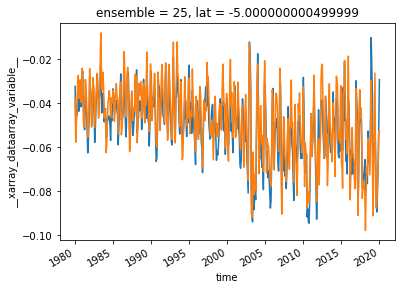

In [97]:

anth_dic_area_u_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/raw_canth_area_u_transport.nc').__xarray_dataarray_variable__.chunk('auto')
anth_dic_area_v_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/raw_canth_area_v_transport.nc').__xarray_dataarray_variable__.chunk('auto')

anth_dic_area_u_tx_gm=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/raw_canth_area_u_transport_gm.nc').__xarray_dataarray_variable__.chunk('auto')
anth_dic_area_v_tx_gm=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/raw_canth_area_v_transport_gm.nc').__xarray_dataarray_variable__.chunk('auto')

anth_dic_v_tx=(((anth_dic_area_v_tx)*60*60*24*365*12)/1e18)/1e6
anth_dic_v_tx_gm=(((anth_dic_area_v_tx_gm)*60*60*24*365*12)/1e18)/1e6

(anth_dic_v_tx).sel(lat=-5,method='nearest').sum(['st_ocean','lon']).plot()
(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=-5,method='nearest').sum(['st_ocean','lon']).plot()

In [93]:
ymertrans_S=cafe_y_tx.sel(lat_x=-5,method='nearest').where(region_mask.above_isopycnal.sel(lat=-5,method='nearest')==1).sel(lon=slice(140,300)).sum(['st_ocean','lon']).rolling(time=12).mean()
ymertrans_N=-cafe_y_tx.sel(lat_x=5,method='nearest').where(region_mask.above_isopycnal.sel(lat=5,method='nearest')==1).sel(lon=slice(120,300)).sum(['st_ocean','lon']).rolling(time=12).mean()

(3652.0, 18262.0)

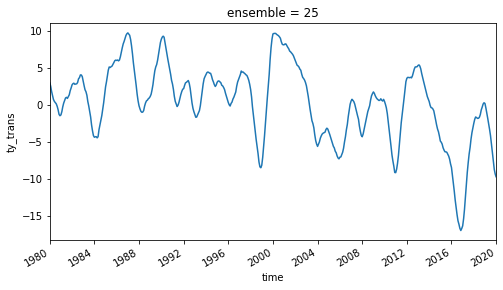

In [112]:
plt.figure(figsize=(8,4))
#(ymertrans_S+ymertrans_N).plot()
#plt.show()
#plt.figure(figsize=(8,4))
((ymertrans_S+ymertrans_N)-(ymertrans_S+ymertrans_N).sel(time=slice('1980','2020')).mean(dim='time')).rolling(time=12).mean().plot()
plt.xlim([np.datetime64('1980-01-01'),np.datetime64('2020-01-01')])

In [104]:
(ymertrans_N).mean(dim='time').values

array(-5.32156538)

In [103]:
(ymertrans_S).mean(dim='time').values

array(5.02275569)

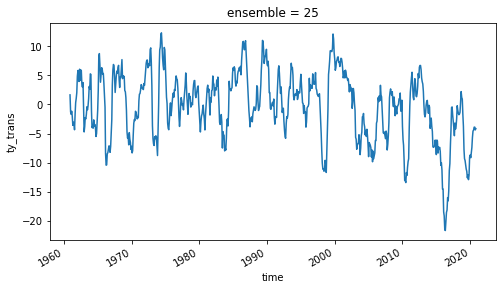

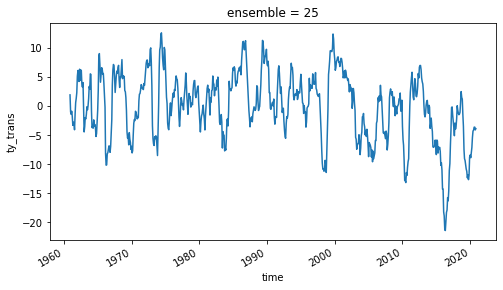

In [100]:
+ymertrans_N

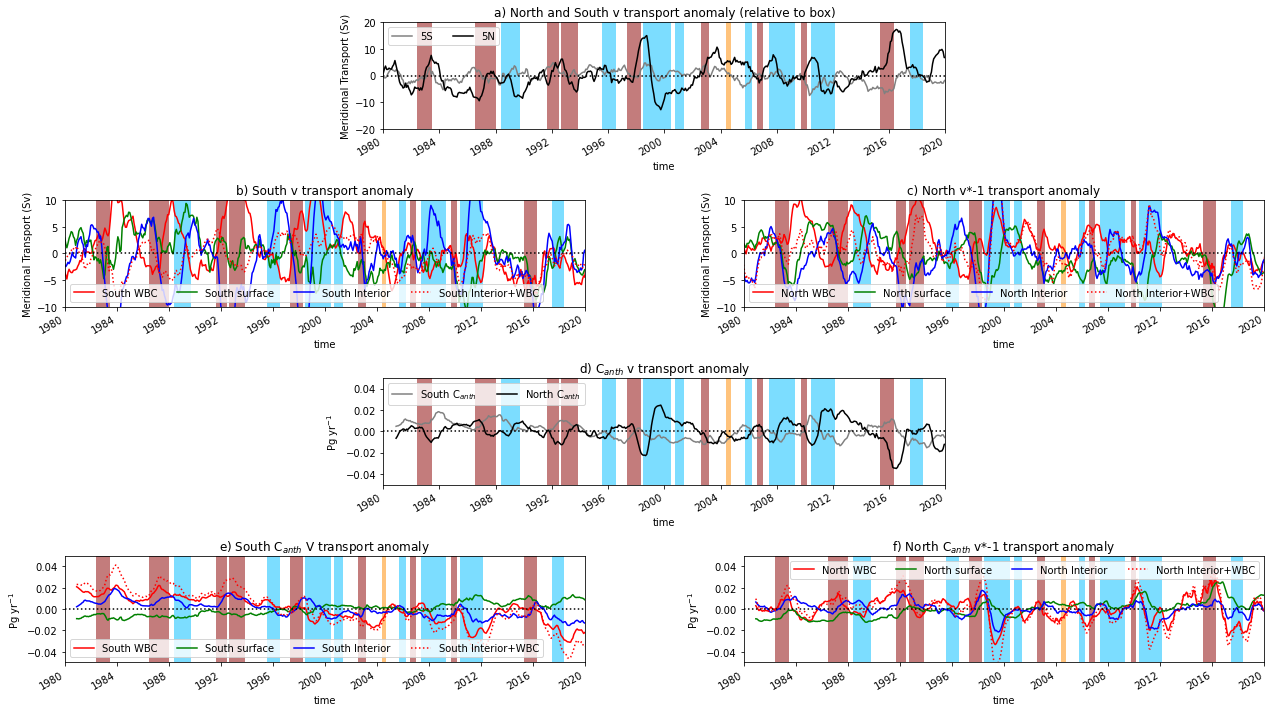

In [90]:
# Replicate Zeller

#26.34*1.025
#26.34*1.025
fig=plt.figure(figsize=(18,10))

gs=fig.add_gridspec(4,4)

#ax=plt.subplot(421)#
ax=fig.add_subplot(gs[0,1:3]) #plt.subplot(3,4,[2,3])

(ymertrans_S-ymertrans_S.mean()).plot(ax=ax,c='gray')
((ymertrans_N-ymertrans_N.mean())*-1).plot(ax=ax,c='k')
#(interior-interior.mean()).plot(ax=ax,c='r')
#(surface-surface.mean()).plot(ax=ax,c='g')

ax.set_xlim([np.datetime64('1980-01-01'),np.datetime64('2020-01-01')])
ax.set_title('a) North and South v transport anomaly (relative to box)')
ax.legend(['5S','5N'],ncol=2)
add_enso_colours(ax)
ax.set_ylim([-20,20])
plt.axhline(0,c='k',linestyle=':')
ax.set_ylabel('Meridional Transport (Sv)')



#ax=ax=plt.subplot(422)#fig.add_subplot(gs[0,1:3]) #plt.subplot(3,4,[2,3])

#ax.set_xlim([np.datetime64('1980-01-01'),np.datetime64('2020-01-01')])
#ax.set_title('b) North and South v transport Surface and Interior anomaly in Sv (relative to box)')
#ax.legend(['5N Surface','5S Surface','5N Subsurface+WBC','5S Subsurface+WBC'])
#add_enso_colours(ax)
#ax.set_ylim([-20,20])
#plt.axhline(0,c='k',linestyle=':')



ax=plt.subplot(423)
#ymertrans_wbc=cafe_y_tx.sel(lat_x=-5,method='nearest').where(region_mask.south_wbc.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
#ymertrans_surface=cafe_y_tx.sel(lat_x=-5,method='nearest').where(region_mask.south_surface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()
#ymertrans_subsurface=cafe_y_tx.sel(lat_x=-5,method='nearest').where(region_mask.south_subsurface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12).mean()#.plot()#.sel(time='2000-01-01').plot()

(ymertrans_wbc-ymertrans_wbc.mean()).plot(ax=ax,c='r')
(ymertrans_surface-ymertrans_surface.mean()).plot(ax=ax,c='g')
(ymertrans_subsurface-ymertrans_subsurface.mean()).plot(ax=ax,c='b')
(ymertrans_WBCsubsurfaceS-ymertrans_WBCsubsurfaceS.mean()).plot(ax=ax,c='r',linestyle=':')



#(ymertrans_surfaceN-ymertrans_surfaceN.mean()).plot(ax=ax,c='g')
#(ymertrans_surfaceS-ymertrans_surfaceS.mean()).plot(ax=ax,c='g',linestyle=':')
#((ymertrans_wbcN+ymertrans_subsurfaceN)-(ymertrans_wbcN+ymertrans_subsurfaceN).mean()).plot(ax=ax,c='r')


ax.set_xlim([np.datetime64('1980-01-01'),np.datetime64('2020-01-01')])
ax.set_title('b) South v transport anomaly')
ax.legend(['South WBC','South surface','South Interior', 'South Interior+WBC'],ncol=4)
add_enso_colours(ax)
ax.set_ylabel('Meridional Transport (Sv)')

ax.set_ylim([-10,10])
plt.axhline(0,c='k',linestyle=':')

ax=plt.subplot(424)
#26.34*1.025
#26.34*1.025

(ymertrans_wbcN-ymertrans_wbcN.mean()).plot(ax=ax,c='r')
(ymertrans_surfaceN-ymertrans_surfaceN.mean()).plot(ax=ax,c='g')
(ymertrans_subsurfaceN-ymertrans_subsurfaceN.mean()).plot(ax=ax,c='b')
(ymertrans_WBCsubsurfaceN-ymertrans_WBCsubsurfaceN.mean()).plot(ax=ax,c='r',linestyle=':')

ax.set_xlim([np.datetime64('1980-01-01'),np.datetime64('2020-01-01')])
plt.legend(['North WBC','North surface','North Interior', 'North Interior+WBC'],ncol=4)
plt.title('c) North v*-1 transport anomaly')
add_enso_colours(ax)
ax.set_ylim([-10,10])
plt.axhline(0,c='k',linestyle=':')
ax.set_ylabel('Meridional Transport (Sv)')


#ax=plt.subplot(425)#
ax=fig.add_subplot(gs[2,1:3]) #plt.subplot(3,4,[2,3])
(((anthymertrans_S-anthymertrans_S.mean()))).plot(ax=ax,c='gray')
((((anthymertrans_N-anthymertrans_N.mean())*-1))).plot(ax=ax,c='k')

ax.set_xlim([np.datetime64('1980-01-01'),np.datetime64('2020-01-01')])
ax.set_title('d) C$_{anth}$ v transport anomaly')
ax.legend(['South C$_{anth}$','North C$_{anth}$'],ncol=2)
add_enso_colours(ax)
ax.set_ylim([-0.05,0.05])
plt.axhline(0,c='k',linestyle=':')
ax.set_ylabel('Pg yr$^{-1}$')


#ax=ax=plt.subplot(426)#fig.add_subplot(gs[0,1:3]) #plt.subplot(3,4,[2,3])


#ax.set_xlim([np.datetime64('1980-01-01'),np.datetime64('2020-01-01')])
#ax.set_title('f) North and South Anthropogenic Carbon v transport Surface and Interior anomaly in Sv (relative to box)')
#ax.legend(['5N Surface','5S Surface','5N Subsurface+WBC','5S Subsurface+WBC'])
#add_enso_colours(ax)
#ax.set_ylim([-20,20])
#plt.axhline(0,c='k',linestyle=':')


ax=plt.subplot(427)
#26.34*1.025
#26.34*1.025


(((anthymertrans_wbcS-anthymertrans_wbcS.mean()))).plot(ax=ax,c='r')
(((anthymertrans_surfaceS-anthymertrans_surfaceS.mean()))).plot(ax=ax,c='g')
(((anthymertrans_subsurfaceS-anthymertrans_subsurfaceS.mean()))).plot(ax=ax,c='b')
(((anthymertrans_WBCsubsurfaceS-anthymertrans_WBCsubsurfaceS.mean()))).plot(ax=ax,c='r',linestyle=':')


#(((anthymertrans_surfaceN-anthymertrans_surfaceN.mean())*60*60*24*365*12)/1e18).plot(ax=ax,c='g')
#(((anthymertrans_surfaceS-anthymertrans_surfaceS.mean())*60*60*24*365*12)/1e18).plot(ax=ax,c='g',linestyle=':')
#((((anthymertrans_wbcS+anthymertrans_subsurfaceS)-(anthymertrans_wbcS+anthymertrans_subsurfaceS).mean())*60*60*24*365*12)/1e18).plot(ax=ax,c='r',linestyle=':')
#((((anthymertrans_wbcS+anthymertrans_subsurfaceS)-(anthymertrans_wbcS+anthymertrans_subsurfaceS).mean())*60*60*24*365*12)/1e18).plot(ax=ax,c='r',linestyle=':')


ax.set_xlim([np.datetime64('1980-01-01'),np.datetime64('2020-01-01')])
plt.legend(['South WBC','South surface','South Interior', 'South Interior+WBC'],ncol=4)
plt.title('e) South C$_{anth}$ V transport anomaly')
ax.set_ylabel('Pg yr$^{-1}$')

add_enso_colours(ax)
plt.axhline(0,c='k',linestyle=':')
ax.set_ylim([-0.05,0.05])

ax=plt.subplot(428)
#26.34*1.025
#26.34*1.025

(((anthymertrans_wbcN-anthymertrans_wbcN.mean()))).plot(ax=ax,c='r')
(((anthymertrans_surfaceN-anthymertrans_surfaceN.mean()))).plot(ax=ax,c='g')
(((anthymertrans_subsurfaceN-anthymertrans_subsurfaceN.mean()))).plot(ax=ax,c='b')
#((((anthymertrans_wbcN+anthymertrans_subsurfaceN)-(anthymertrans_wbcN+anthymertrans_subsurfaceN).mean())*60*60*24*365*12)/1e18).plot(ax=ax,c='r',linestyle=':')
(((anthymertrans_WBCsubsurfaceN-anthymertrans_WBCsubsurfaceN.mean()))).plot(ax=ax,c='r',linestyle=':')

add_enso_colours(ax)

ax.set_xlim([np.datetime64('1980-01-01'),np.datetime64('2020-01-01')])
plt.legend(['North WBC','North surface','North Interior', 'North Interior+WBC'],ncol=4)
plt.title('f) North C$_{anth}$ v*-1 transport anomaly')
ax.set_ylabel('Pg yr$^{-1}$')
#ax.set_xlabel('Meridional C$_{anth}$ Transport (Pg yr$^{-1}$)')


plt.axhline(0,c='k',linestyle=':')
ax.set_ylim([-0.05,0.05])
plt.tight_layout()

In [ ]:
#33333333333(1e9*60*60*24*365*12)/1e18
cluster

In [188]:
cluster = SLURMCluster(cores=8,processes=2,memory="47GB")

client = Client(cluster)
cluster.scale(cores=64)
cluster

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43229 instead
  warnings.warn(


ERROR! Session/line number was not unique in database. History logging moved to new session 2764


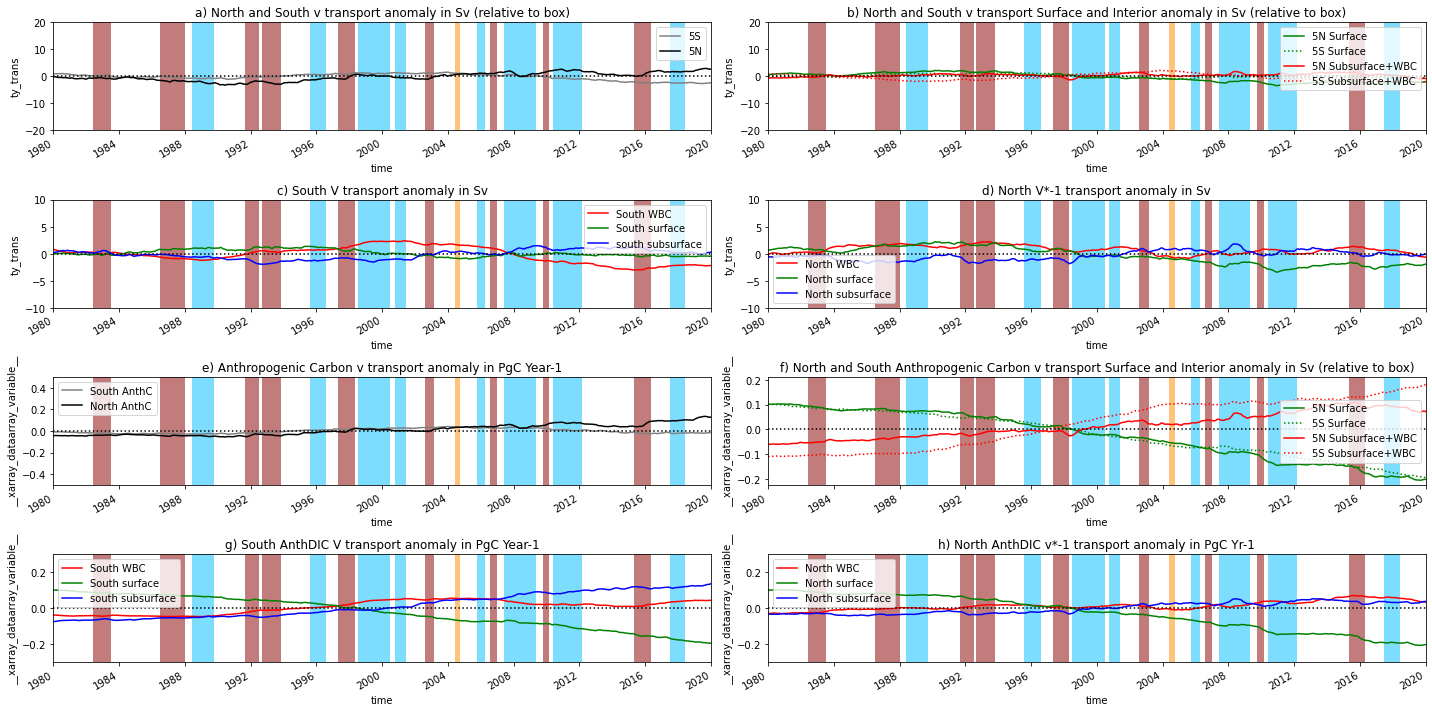

In [77]:
#10 yr rolling mean

ymertrans_wbcS=cafe_y_tx.sel(lat_x=-5,method='nearest').where(region_mask.south_wbc.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12*10).mean()#.plot()#.sel(time='2000-01-01').plot()
ymertrans_surfaceS=cafe_y_tx.sel(lat_x=-5,method='nearest').where(region_mask.south_surface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12*10).mean()#.plot()#.sel(time='2000-01-01').plot()
ymertrans_subsurfaceS=cafe_y_tx.sel(lat_x=-5,method='nearest').where(region_mask.south_subsurface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12*10).mean()#.plot()#.sel(time='2000-01-01').plot()

ymertrans_wbcN=-cafe_y_tx.sel(lat_x=5,method='nearest').where(region_mask.north_wbc.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12*10).mean()#.plot()#.sel(time='2000-01-01').plot()
ymertrans_surfaceN=-cafe_y_tx.sel(lat_x=5,method='nearest').where(region_mask.north_surface.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12*10).mean()#.plot()#.sel(time='2000-01-01').plot()
ymertrans_subsurfaceN=-cafe_y_tx.sel(lat_x=5,method='nearest').where(region_mask.north_subsurface.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12*10).mean()#.plot()#.sel(time='2000-01-01').plot()

ymertrans_wbc=ymertrans_wbcN+ymertrans_wbcS
ymertrans_surface=ymertrans_surfaceN+ymertrans_surfaceS
ymertrans_subsurface=ymertrans_subsurfaceN+ymertrans_subsurfaceS

ymertrans_S=cafe_y_tx.sel(lat_x=-5,method='nearest').where(region_mask.above_isopycnal.sel(lat=-5,method='nearest')==1).sel(lon=slice(140,300)).sum(['st_ocean','lon']).rolling(time=12*10).mean()
ymertrans_N=-cafe_y_tx.sel(lat_x=5,method='nearest').where(region_mask.above_isopycnal.sel(lat=5,method='nearest')==1).sel(lon=slice(120,300)).sum(['st_ocean','lon']).rolling(time=12*10).mean()

#(ymertrans_wbc-ymertrans_wbc.mean()).plot(ax=ax,c='r')
#(ymertrans_surface-ymertrans_surface.mean()).plot(ax=ax,c='g')
#(ymertrans_subsurface-ymertrans_subsurface.mean()).plot(ax=ax,c='b')
interior=ymertrans_wbcS+ymertrans_wbcN+ymertrans_subsurfaceN+ymertrans_subsurfaceS
surface=ymertrans_surfaceN+ymertrans_surfaceS#mertrans_surface+ymertrans_surfaceN


anthymertrans_wbcS=anth_dic_v_tx.sel(lat=-5,method='nearest').where(region_mask.south_wbc.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12*10).mean()#.plot()#.sel(time='2000-01-01').plot()
anthymertrans_surfaceS=anth_dic_v_tx.sel(lat=-5,method='nearest').where(region_mask.south_surface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12*10).mean()#.plot()#.sel(time='2000-01-01').plot()
anthymertrans_subsurfaceS=anth_dic_v_tx.sel(lat=-5,method='nearest').where(region_mask.south_subsurface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12*10).mean()#.plot()#.sel(time='2000-01-01').plot()

anthymertrans_wbcN=-anth_dic_v_tx.sel(lat=5,method='nearest').where(region_mask.north_wbc.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12*10).mean()#.plot()#.sel(time='2000-01-01').plot()
anthymertrans_surfaceN=-anth_dic_v_tx.sel(lat=5,method='nearest').where(region_mask.north_surface.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12*10).mean()#.plot()#.sel(time='2000-01-01').plot()
anthymertrans_subsurfaceN=-anth_dic_v_tx.sel(lat=5,method='nearest').where(region_mask.north_subsurface.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12*10).mean()#.plot()#.sel(time='2000-01-01').plot()


anthymertrans_S=anth_dic_v_tx.sel(lat=-5,method='nearest').where(region_mask.above_isopycnal.sel(lat=-5,method='nearest')==1).sel(lon=slice(140,300)).sum(['st_ocean','lon']).rolling(time=12*10).mean()
anthymertrans_N=-anth_dic_v_tx.sel(lat=5,method='nearest').where(region_mask.above_isopycnal.sel(lat=5,method='nearest')==1).sel(lon=slice(120,300)).sum(['st_ocean','lon']).rolling(time=12*10).mean()


anth_interior=anthymertrans_wbcS+anthymertrans_wbcN+anthymertrans_subsurfaceN+anthymertrans_subsurfaceS
anth_surface=anthymertrans_surfaceN+anthymertrans_surfaceS#mertrans_surface+ymertrans_surfaceN


# Replicate Zeller

#26.34*1.025
#26.34*1.025
fig=plt.figure(figsize=(20,10))

#gs=fig.add_gridspec(4,4)

ax=ax=plt.subplot(421)#fig.add_subplot(gs[0,1:3]) #plt.subplot(3,4,[2,3])

(ymertrans_S-ymertrans_S.mean()).plot(ax=ax,c='gray')
((ymertrans_N-ymertrans_N.mean())*-1).plot(ax=ax,c='k')
#(interior-interior.mean()).plot(ax=ax,c='r')
#(surface-surface.mean()).plot(ax=ax,c='g')

ax.set_xlim([np.datetime64('1980-01-01'),np.datetime64('2020-01-01')])
ax.set_title('a) North and South v transport anomaly in Sv (relative to box)')
ax.legend(['5S','5N'])
add_enso_colours(ax)
ax.set_ylim([-20,20])
plt.axhline(0,c='k',linestyle=':')




ax=ax=plt.subplot(422)#fig.add_subplot(gs[0,1:3]) #plt.subplot(3,4,[2,3])
(ymertrans_surfaceN-ymertrans_surfaceN.mean()).plot(ax=ax,c='g')
(ymertrans_surfaceS-ymertrans_surfaceS.mean()).plot(ax=ax,c='g',linestyle=':')
((ymertrans_wbcN+ymertrans_subsurfaceN)-(ymertrans_wbcN+ymertrans_subsurfaceN).mean()).plot(ax=ax,c='r')
((ymertrans_wbcS+ymertrans_subsurfaceS)-(ymertrans_wbcS+ymertrans_subsurfaceS).mean()).plot(ax=ax,c='r',linestyle=':')


ax.set_xlim([np.datetime64('1980-01-01'),np.datetime64('2020-01-01')])
ax.set_title('b) North and South v transport Surface and Interior anomaly in Sv (relative to box)')
ax.legend(['5N Surface','5S Surface','5N Subsurface+WBC','5S Subsurface+WBC'])
add_enso_colours(ax)
ax.set_ylim([-20,20])
plt.axhline(0,c='k',linestyle=':')




ax=plt.subplot(423)
ymertrans_wbc=cafe_y_tx.sel(lat_x=-5,method='nearest').where(region_mask.south_wbc.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12*10).mean()#.plot()#.sel(time='2000-01-01').plot()
ymertrans_surface=cafe_y_tx.sel(lat_x=-5,method='nearest').where(region_mask.south_surface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12*10).mean()#.plot()#.sel(time='2000-01-01').plot()
ymertrans_subsurface=cafe_y_tx.sel(lat_x=-5,method='nearest').where(region_mask.south_subsurface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12*10).mean()#.plot()#.sel(time='2000-01-01').plot()

(ymertrans_wbc-ymertrans_wbc.mean()).plot(ax=ax,c='r')
(ymertrans_surface-ymertrans_surface.mean()).plot(ax=ax,c='g')
(ymertrans_subsurface-ymertrans_subsurface.mean()).plot(ax=ax,c='b')
ax.set_xlim([np.datetime64('1980-01-01'),np.datetime64('2020-01-01')])
ax.set_title('c) South V transport anomaly in Sv')
ax.legend(['South WBC','South surface','south subsurface'])
add_enso_colours(ax)

ax.set_ylim([-10,10])
plt.axhline(0,c='k',linestyle=':')

ax=plt.subplot(424)
#26.34*1.025
#26.34*1.025

(ymertrans_wbcN-ymertrans_wbcN.mean()).plot(ax=ax,c='r')
(ymertrans_surfaceN-ymertrans_surfaceN.mean()).plot(ax=ax,c='g')
(ymertrans_subsurfaceN-ymertrans_subsurfaceN.mean()).plot(ax=ax,c='b')
ax.set_xlim([np.datetime64('1980-01-01'),np.datetime64('2020-01-01')])
plt.legend(['North WBC','North surface','North subsurface'])
plt.title('d) North V*-1 transport anomaly in Sv')
add_enso_colours(ax)
ax.set_ylim([-10,10])
plt.axhline(0,c='k',linestyle=':')


ax=plt.subplot(425)#fig.add_subplot(gs[2,1:3]) #plt.subplot(3,4,[2,3])
(((anthymertrans_S-anthymertrans_S.mean())*60*60*24*365*12)/1e18).plot(ax=ax,c='gray')
((((anthymertrans_N-anthymertrans_N.mean())*-1)*60*60*24*365*12)/1e18).plot(ax=ax,c='k')




ax.set_xlim([np.datetime64('1980-01-01'),np.datetime64('2020-01-01')])
ax.set_title('e) Anthropogenic Carbon v transport anomaly in PgC Year-1')
ax.legend(['South AnthC','North AnthC'])
add_enso_colours(ax)
ax.set_ylim([-0.5,0.5])
plt.axhline(0,c='k',linestyle=':')


ax=ax=plt.subplot(426)#fig.add_subplot(gs[0,1:3]) #plt.subplot(3,4,[2,3])
(((anthymertrans_surfaceN-anthymertrans_surfaceN.mean())*60*60*24*365*12)/1e18).plot(ax=ax,c='g')
(((anthymertrans_surfaceS-anthymertrans_surfaceS.mean())*60*60*24*365*12)/1e18).plot(ax=ax,c='g',linestyle=':')
((((anthymertrans_wbcN+anthymertrans_subsurfaceN)-(anthymertrans_wbcN+anthymertrans_subsurfaceN).mean())*60*60*24*365*12)/1e18).plot(ax=ax,c='r')
((((anthymertrans_wbcS+anthymertrans_subsurfaceS)-(anthymertrans_wbcS+anthymertrans_subsurfaceS).mean())*60*60*24*365*12)/1e18).plot(ax=ax,c='r',linestyle=':')


ax.set_xlim([np.datetime64('1980-01-01'),np.datetime64('2020-01-01')])
ax.set_title('f) North and South Anthropogenic Carbon v transport Surface and Interior anomaly in Sv (relative to box)')
ax.legend(['5N Surface','5S Surface','5N Subsurface+WBC','5S Subsurface+WBC'])
add_enso_colours(ax)
#ax.set_ylim([-20,20])
plt.axhline(0,c='k',linestyle=':')







ax=plt.subplot(427)
#26.34*1.025
#26.34*1.025


(((anthymertrans_wbcS-anthymertrans_wbcS.mean())*60*60*24*365*12)/1e18).plot(ax=ax,c='r')
(((anthymertrans_surfaceS-anthymertrans_surfaceS.mean())*60*60*24*365*12)/1e18).plot(ax=ax,c='g')
(((anthymertrans_subsurfaceS-anthymertrans_subsurfaceS.mean())*60*60*24*365*12)/1e18).plot(ax=ax,c='b')
ax.set_xlim([np.datetime64('1980-01-01'),np.datetime64('2020-01-01')])
plt.legend(['South WBC','South surface','south subsurface'])
plt.title('g) South AnthDIC V transport anomaly in PgC Year-1')
add_enso_colours(ax)
plt.axhline(0,c='k',linestyle=':')
ax.set_ylim([-0.3,0.3])

ax=plt.subplot(428)
#26.34*1.025
#26.34*1.025

(((anthymertrans_wbcN-anthymertrans_wbcN.mean())*60*60*24*365*12)/1e18).plot(ax=ax,c='r')
(((anthymertrans_surfaceN-anthymertrans_surfaceN.mean())*60*60*24*365*12)/1e18).plot(ax=ax,c='g')
(((anthymertrans_subsurfaceN-anthymertrans_subsurfaceN.mean())*60*60*24*365*12)/1e18).plot(ax=ax,c='b')
add_enso_colours(ax)

ax.set_xlim([np.datetime64('1980-01-01'),np.datetime64('2020-01-01')])
plt.legend(['North WBC','North surface','North subsurface'])
plt.title('h) North AnthDIC v*-1 transport anomaly in PgC Yr-1')
plt.axhline(0,c='k',linestyle=':')
ax.set_ylim([-0.3,0.3])
plt.tight_layout()

# Correlation

In [128]:
enso=pd.read_csv('../external_data/indexes/meiv2.csv',index_col=0,header=None)
enso_flat=enso.stack()
enso_dates=pd.date_range('1979','2021-10-01',freq='M')- pd.offsets.MonthBegin(1) #Probably want to check this is correct if updating.
enso_timeseries=pd.DataFrame({'Date':enso_dates,'mei':enso_flat})
enso_ts=enso_timeseries.reset_index()[['Date','mei']].query('Date >= 1980').query('Date <2020')

In [129]:
co2_corr=-cafe_co2_anth.sel(lat=slice(-5,5),lon=slice(160,300),time=slice('2000','2019-12-31')).mean(['lat','lon'])
corr_ds_extra=co2_corr.to_dataset(name='anth_co2flux')
#corr_ds_extra['Canth upwelling 300m']=anthupwelling.sel(time=slice('2000','2019-12-31'),lat=slice(-5,5),lon=slice(160,300)).mean(['lat','lon']).sel(st_ocean=-300,method='nearest')
corr_ds_extra['Canth upwelling 100m']=anthupwelling.sel(time=slice('2000','2019-12-31'),lat=slice(-5,5),lon=slice(160,300)).mean(['lat','lon']).sel(st_ocean=-100,method='nearest')
#corr_ds_extra['upwelling500']=anthupwelling.sel(time=slice('1980','2019-12-31'),lat=slice(-5,5),lon=slice(160,300)).mean(['lat','lon']).sel(st_ocean=-500,method='nearest')

corr_ds_extra['MEI']=enso_ts.rename({'Date':'time'},axis=1).set_index('time')['mei']
corr_ds_extra['windspeed']=eqws.sel(time=slice('2000','2019-12-31'),lat=slice(-5,5),lon=slice(160,300)).mean(['lat','lon'])

#corr_ds_extra['S_WBC_flow']=ymertrans_wbcS.sel(time=slice('1980','2019-12-31'))
#corr_ds_extra['S_surface_flow']=ymertrans_surfaceS.sel(time=slice('1980','2019-12-31'))
#corr_ds_extra['S_subsurface_flow']=ymertrans_subsurfaceS.sel(time=slice('1980','2019-12-31'))
#corr_ds_extra['N_WBC_flow']=ymertrans_wbcN.sel(time=slice('1980','2019-12-31'))
#corr_ds_extra['N_surface_flow']=ymertrans_surfaceN.sel(time=slice('1980','2019-12-31'))
#corr_ds_extra['N_subsurface_flow']=ymertrans_subsurfaceN.sel(time=slice('1980','2019-12-31'))

corr_ds_extra['S_subsurface+wbc_Canth_flow']=anthymertrans_WBCsubsurfaceS.sel(time=slice('2000','2019-12-31'))
corr_ds_extra['S_WBC_Canth_flow']=anthymertrans_wbcS.sel(time=slice('2000','2019-12-31'))
corr_ds_extra['S_surface_Canth_flow']=anthymertrans_surfaceS.sel(time=slice('2000','2019-12-31'))
corr_ds_extra['S_subsurface_Canth_flow']=anthymertrans_subsurfaceS.sel(time=slice('2000','2019-12-31'))

corr_ds_extra['N_subsurface+wbc_Canth_flow']=anthymertrans_WBCsubsurfaceN.sel(time=slice('2000','2019-12-31'))
corr_ds_extra['N_WBC_Canth_flow']=anthymertrans_wbcN.sel(time=slice('2000','2019-12-31'))
corr_ds_extra['N_surface_Canth_flow']=anthymertrans_surfaceN.sel(time=slice('2000','2019-12-31'))
corr_ds_extra['N_subsurface_Canth_flow']=anthymertrans_subsurfaceN.sel(time=slice('2000','2019-12-31'))


corr_ds_extra['surface_flow_Sv']=surface.sel(time=slice('2000','2019-12-31'))
corr_ds_extra['subsurface+wbc_flow_Sv']=interior.sel(time=slice('2000','2019-12-31'))
corr_ds_extra['anthC_surface_flow']=anth_surface.sel(time=slice('2000','2019-12-31'))
corr_ds_extra['anthC_subsurface+wbc_flow']=anth_interior.sel(time=slice('2000','2019-12-31'))

corr_ds_extra['anthC_surface_flow_detrend']=xarray_detrend(anth_surface.sel(time=slice('2000','2020')).chunk(dict(time=-1)))#.sel(time=slice('2000','2019-12-31'))
corr_ds_extra['anthC_subsurface+wbc_flow_detrend']=xarray_detrend(anth_interior.sel(time=slice('2000','2020')).chunk(dict(time=-1)))#.sel(time=slice('2000','2019-12-31'))

corr_ds_extra['anth_co2_accumululation']=((tot_anth_dic_cafe.sel(lat=slice(-5,5),lon=slice(160,300)).sum(['lat','lon','st_ocean'])*12)/1e18).sel(time=slice('2000','2019-12-31'))
corr_ds_extra['anth_co2_accumululation_detrend']=xarray_detrend((tot_anth_dic_cafe.sel(lat=slice(-5,5),lon=slice(160,300)).sum(['lat','lon','st_ocean']).chunk(dict(time=-1))*12)/1e18)#.sel(time=slice('1980','2019-12-31'))
corr_ds_extra=corr_ds_extra.drop(['ensemble','st_ocean'])
print('Loading data into memory')
corr_ds_extra_loaded=corr_ds_extra.load()
print('Loaded')
corr_ds_extra_loaded

/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/xarray_trends.py:39: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,return_trend,
/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/xarray_trends.py:39: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,return_trend,
/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/xarray_trends.py:39: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,return_trend,


Loading data into memory
Loaded


<xarray.Dataset>
Dimensions:                            (time: 240)
Coordinates:
  * time                               (time) datetime64[ns] 2000-01-01 ... 2...
Data variables: (12/20)
    anth_co2flux                       (time) float32 9.531e-06 ... 9.327e-06
    Canth upwelling 100m               (time) float64 6.435e+05 ... 3.962e+05
    MEI                                (time) float64 -1.26 -1.27 ... 0.45 0.41
    windspeed                          (time) float32 5.311 5.178 ... 5.5 5.131
    S_subsurface+wbc_Canth_flow        (time) float64 -0.1324 ... -0.1617
    S_WBC_Canth_flow                   (time) float64 -0.1028 ... -0.1242
    ...                                 ...
    anthC_surface_flow                 (time) float64 0.04322 ... 0.06871
    anthC_subsurface+wbc_flow          (time) float64 -0.1912 ... -0.1974
    anthC_surface_flow_detrend         (time) float64 0.01153 ... 0.01598
    anthC_subsurface+wbc_flow_detrend  (time) float64 -0.1742 -0.1692 ... -0.169
    anth_co2_accumululation            (time) float64 3.12 3.065 ... 4.043 4.145
    anth_co2_accumululation_detrend    (time) float64 2.153 2.096 ... 2.537

In [132]:
# Need to trim or shorten
def linear_trend(ax,x,y):#,xlab,ylab,diagonal_line=1,printer=1,plot=1,logspace=0,color=np.ndarray(0),zx=np.ndarray(0),zy=np.ndarray(0),trendline=1):
    """"
    Designed for chlorophyll trends <1mg/m3 
    
    Given an x and y (same size)
    + Title, X Label, Y Label
    
    if Z, will plot 
    Optional: Diagonal_line=0, default on.
    Optional: Printer=0, default on
    
    Returns linear statistics. 
    """
    
    x1=np.ravel(x)
    y=np.ravel(y)
    mask=~np.isnan(x1)
    x=x[mask]
    y=y[mask]
    x2=x1.astype('datetime64[D]')
    slope, intercept, r_value, p_value, std_err = linregress(pd.to_numeric(x2),y)
    #if plot==0:
    #     return slope, intercept, r_value, p_value, std_err 
    
    mn=min(pd.to_numeric(x2))
    mx=max(pd.to_numeric(x2))
    x2=np.linspace(mn,mx,len(x2))
    y1=slope*pd.to_numeric(x2)+intercept
    plt.plot(x,y1,'r:',linewidth=2)  
     
    return slope, intercept, r_value, p_value

In [169]:
plt.figure(figsize=(10,10))
ax=plt.subplot(611)
(corr_ds_extra_loaded['anth_co2_accumululation']-corr_ds_extra_loaded['anth_co2_accumululation'].values[0]).plot(c='k',linestyle=':')
(corr_ds_extra_loaded['anth_co2_accumululation']-corr_ds_extra_loaded['anth_co2_accumululation'].values[0]).rolling(time=12).mean().plot(c='k')
res=linear_trend(ax,x=corr_ds_extra_loaded['anth_co2_accumululation'].time.values,
                y=(corr_ds_extra_loaded['anth_co2_accumululation']-corr_ds_extra_loaded['anth_co2_accumululation'].values[0]))#)
add_enso_colours(ax=ax)

In [173]:
# Quick corr tests

In [136]:
corr_ds_extra_loaded

<xarray.Dataset>
Dimensions:                            (time: 240)
Coordinates:
  * time                               (time) datetime64[ns] 2000-01-01 ... 2...
Data variables: (12/20)
    anth_co2flux                       (time) float32 9.531e-06 ... 9.327e-06
    Canth upwelling 100m               (time) float64 6.435e+05 ... 3.962e+05
    MEI                                (time) float64 -1.26 -1.27 ... 0.45 0.41
    windspeed                          (time) float32 5.311 5.178 ... 5.5 5.131
    S_subsurface+wbc_Canth_flow        (time) float64 1.749e+09 ... 2.159e+09
    S_WBC_Canth_flow                   (time) float64 9.23e+08 ... 1.004e+09
    ...                                 ...
    anthC_surface_flow                 (time) float64 -1.354e+09 ... -2.158e+09
    anthC_subsurface+wbc_flow          (time) float64 2.725e+09 ... 2.849e+09
    anthC_surface_flow_detrend         (time) float64 -3.838e+08 ... -5.443e+08
    anthC_subsurface+wbc_flow_detrend  (time) float64 2.128e+09 ... 1.855e+09
    anth_co2_accumululation            (time) float64 3.12 3.065 ... 4.043 4.145
    anth_co2_accumululation_detrend    (time) float64 2.153 2.096 ... 2.537

In [155]:
def cross_correlation(a1, a2):
    #https://stackoverflow.com/a/48379444
        lags = range(-len(a1)+1, len(a2))
        cs = []
        for lag in lags:
            idx_lower_a1 = max(lag, 0)
            idx_lower_a2 = max(-lag, 0)
            idx_upper_a1 = min(len(a1), len(a1)+lag)
            idx_upper_a2 = min(len(a2), len(a2)-lag)
            b1 = a1[idx_lower_a1:idx_upper_a1]
            b2 = a2[idx_lower_a2:idx_upper_a2]
            c = np.correlate(b1, b2)[0]
            c = c / np.sqrt((b1**2).sum() * (b2**2).sum())
            cs.append(c)
        return cs

In [164]:
np.corrcoef(corr_ds_extra_loaded['anth_co2flux'].values,corr_ds_extra_loaded['MEI'].values)

array([[ 1.       , -0.1807804],
       [-0.1807804,  1.       ]])

In [148]:
(np.correlate(corr_ds_extra_loaded['anth_co2flux'],corr_ds_extra_loaded['anthMEI_co2flux']))#,mode='full'))

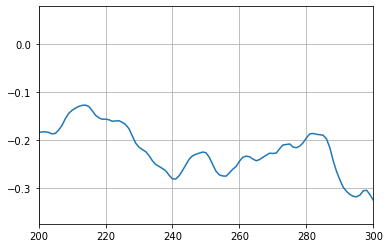

In [176]:
# Pearson r2 correlation vs cross correlation

a=corr_ds_extra_loaded['anth_co2flux'].values
b=corr_ds_extra_loaded['MEI'].values
#https://stackoverflow.com/a/71005798
norm_a = np.linalg.norm(a)
a = a / norm_a
norm_b = np.linalg.norm(b)
b = b / norm_b
plt.plot(np.correlate(a,b,mode='full'))
plt.xlim([200,300]) #[0,50])#
plt.grid()

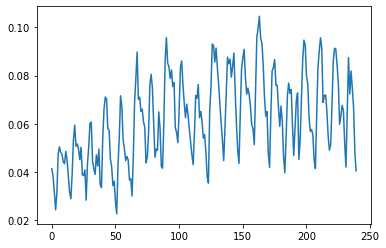

In [177]:
plt.plot(a)

In [189]:
#co.values
cluster

In [178]:
cluster = SLURMCluster(cores=8,processes=2,memory="47GB")
client = Client(cluster)
cluster.scale(cores=64)
cluster

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38109 instead
  warnings.warn(


In [142]:
# Total transport sum compared to accumulation?
co2_flux1=(((-cafe_co2_anth*area_m2).sel(lat=slice(-5,5),time=slice('2000','2020')).sum(['lat','lon']))*12*60*60*24*365)/1e18
upwelling1=((anthupwelling.sel(time=slice('2000','2019-12-31'),lat=slice(-5,5),lon=slice(160,300)).sum(['lat','lon']).sel(st_ocean=-300,method='nearest')*60*60*24*365*12)/1e18)
surface_out=anth_surface_seasonal#*60*60*24*365*12)/1e18#).sum(['lat','lon'])
wbc_in=(anthymertrans_wbcS+anthymertrans_wbcN)#*60*60*24*365*12)/1e18#.sum(['lat','lon']#)
wbcsubsurface_in=(anthymertrans_WBCsubsurfaceS+anthymertrans_WBCsubsurfaceN)#*60*60*24*365*12)/1e18
interior_in=(anthymertrans_subsurfaceS+anthymertrans_subsurfaceN)#*60*60*24*365*12)/1e18#.sum(['lat','lon'])
euc_in=anth_dic_u_tx.sel(lat=slice(-5,5),st_ocean=slice(0,-600)).sel(lon=124,method='nearest').sum(dim=['st_ocean','lat'])#*60*60*24*365*12)/1e18)#.plot() #.rolling(time=12).mean()

#(surface_out+wbcsubsurface_in+co2_flux1+upwelling1).rolling(time=12).mean().plot(c='darkred',linestyle=':')
#(surface_out+wbcsubsurface_in).rolling(time=12).mean().plot(c='darkred')

In [103]:
accumulation_estimate=co2_flux1+upwelling1+surface_out+wbc_in+interior_in
accumulation_estimate=accumulation_estimate.load()

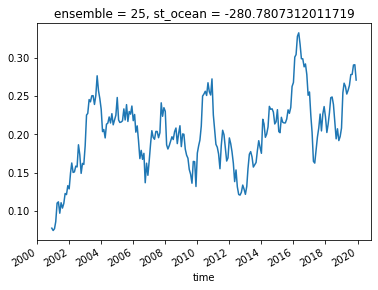

In [143]:
upwelling1.rolling(time=12).mean().plot()

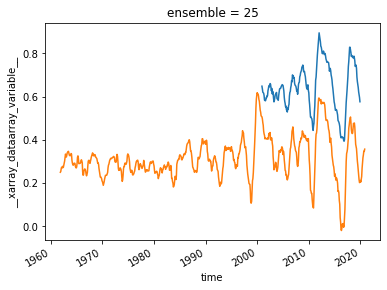

In [144]:
(surface_out+wbc_in+interior_in+co2_flux1+upwelling1).rolling(time=12).mean().plot()
(surface_out+wbcsubsurface_in).rolling(time=12).mean().plot()

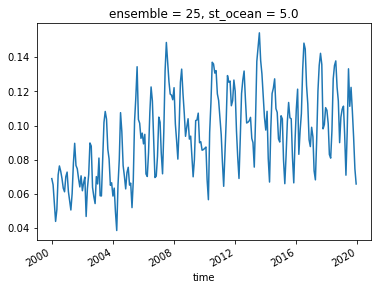

In [135]:
co2_flux1.plot()

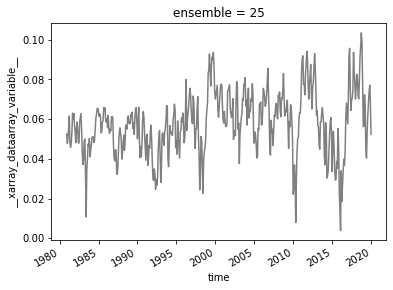

In [144]:
(-(surface_out+wbcsubsurface_in)).plot(c='gray')

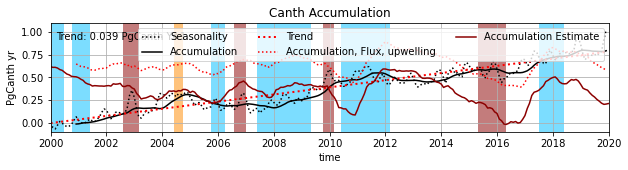

In [39]:
plt.figure(figsize=(10,14))
ax=plt.subplot(611)
(corr_ds_extra_loaded['anth_co2_accumululation']-corr_ds_extra_loaded['anth_co2_accumululation'].values[0]).plot(c='k',linestyle=':')
(corr_ds_extra_loaded['anth_co2_accumululation']-corr_ds_extra_loaded['anth_co2_accumululation'].values[0]).rolling(time=12).mean().plot(c='k')
res1=linear_trend(ax,x=corr_ds_extra_loaded['anth_co2_accumululation'].time.values,
                y=corr_ds_extra_loaded['anth_co2_accumululation']-corr_ds_extra_loaded['anth_co2_accumululation'].values[0])#)
#accumulation_estimate.rolling(time=12).mean().plot(c=Z'r')
(surface_out+wbcsubsurface_in+co2_flux1+upwelling1).rolling(time=12).mean().plot(c='darkred',linestyle=':')
(surface_out+wbcsubsurface_in).rolling(time=12).mean().plot(c='darkred')

plt.title('Canth Accumulation')
#corr_ds_extra_loaded['anth_co2_accumululation_detrend'].plot()
#((corr_ds_extra_loaded['anth_co2flux'])).plot()
plt.xlim([np.datetime64('2000'),np.datetime64('2020')])
plt.xticks(rotation=0,ha='center')
#plt.ylabel('PgCanth yr')
plt.ylabel('PgCanth yr')

plt.text(0.01,0.85, f'Trend: {np.round(res1[0]*365,3)} PgCanth Yr-1',fontsize=10, transform = ax.transAxes)
plt.ylim([-0.1,1.1])
plt.grid(True)
add_enso_colours(ax)
plt.legend(['Seasonality','Accumulation','Trend','Accumulation, Flux, upwelling','Accumulation Estimate'],loc='upper right',ncol=3)

In [227]:
cluster

<xarray.DataArray 'time' (time: 241)>
array(['2000-01-01T00:00:00.000000000', '2000-02-01T00:00:00.000000000',
       '2000-03-01T00:00:00.000000000', ..., '2019-11-01T00:00:00.000000000',
       '2019-12-01T00:00:00.000000000', '2020-01-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    ensemble  int32 25
  * time      (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2020-01-01
Attributes:
    bounds:          time_bounds
    calendar_type:   JULIAN
    cartesian_axis:  T
    long_name:       time

In [149]:
# Do Canth real quick??

raw_canth_area=xr.open_dataset(f'../processed_data/physics_ds/canth_raw_area_jul5.nc').__xarray_dataarray_variable__
anth_dic_area_u_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/raw_canth_area_u_transport.nc').__xarray_dataarray_variable__.chunk('auto')
anth_dic_area_v_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/raw_canth_area_v_transport.nc').__xarray_dataarray_variable__.chunk('auto')

anth_dic_area_u_tx_gm=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/raw_canth_area_u_transport_gm.nc').__xarray_dataarray_variable__.chunk('auto')
anth_dic_area_v_tx_gm=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/raw_canth_area_v_transport_gm.nc').__xarray_dataarray_variable__.chunk('auto')

#((x*60*60*24*365*12)/1e18)
canth_u=(((anth_dic_area_u_tx+anth_dic_area_u_tx_gm)*60*60*24*365*12)/1e18)/1e6
canth_v=(((anth_dic_area_v_tx+anth_dic_area_v_tx_gm)*60*60*24*365*12)/1e18)/1e6

#canth_u=(((anth_dic_u_tx_fulldep)*60*60*24*365*12)/1e18)
#canth_v=(((anth_dic_v_tx_fulldep)*60*60*24*365*12)/1e18)

N_transport_canth=-canth_v.sel(lat=5,method='nearest').sel(time=slice('2000-01-01','2020-01-01')).sel(lon=slice(120,290))
S_transport_canth=-canth_v.sel(lat=-5,method='nearest').sel(time=slice('2000-01-01','2020-01-01')).sel(lon=slice(140,290))
N_S_tx_canth=(-N_transport_canth.sum(['st_ocean','lon'])+S_transport_canth.sum(['st_ocean','lon']))
itf1_canth=canth_u.sel(lat=-5,method='nearest').sel(lon=slice(120,140),time=slice('2000-01-01','2020-01-01'))
itf2_canth=canth_v.sel(lon=120,method='nearest').sel(lat=slice(-5,5),time=slice('2000-01-01','2020-01-01'))
itf_canth=(itf1_canth.sum(['st_ocean','lon'])+itf2_canth.sum(['st_ocean','lat']))#.sum(['st_ocean','lat_x  #N_S_tx




# Total transport sum compared to accumulation?
co2_flux1=(((-cafe_co2_anth*area_m2).sel(lat=slice(-5,5),time=slice('2000','2020')).sum(['lat','lon']))*12*60*60*24*365)/1e18
#??
upwelling1=((anthupwelling.sel(time=slice('2000','2019-12-31'),lat=slice(-5,5),lon=slice(160,300)).sum(['lat','lon']).sel(st_ocean=-300,method='nearest')*60*60*24*365*12)/1e18)
surface_out=(anth_surface_seasonal)#*60*60*24*365*12)/1e18#).sum(['lat','lon'])
wbc_in=((anthymertrans_wbcS+anthymertrans_wbcN))#*60*60*24*365*12)/1e18#.sum(['lat','lon']#)
wbcsubsurface_in=((anthymertrans_WBCsubsurfaceS+anthymertrans_WBCsubsurfaceN))#*60*60*24*365*12)/1e18
interior_in=((anthymertrans_subsurfaceS+anthymertrans_subsurfaceN))#*60*60*24*365*12)/1e18#.sum(['lat','lon'])
euc_in=itf_canth#((anth_dic_u_tx.sel(lat=slice(-5,5),st_ocean=slice(0,-600)).sel(lon=124,method='nearest').sum(dim=['st_ocean','lat'])*60*60*24*365*12)/1e18)#.plot() #.rolling(time=12).mean()



#plt.figure(figsize=(10,8))
#plt.subplot(211)
#(-itf_canth).plot()
#N_S_tx_canth.plot()
#plt.legend(['-ITF canth','N+S TX canth'])
#plt.subplot(212)
#(-itf_canth).rolling(time=12).mean().plot()
#N_S_tx_canth.rolling(time=12).mean().plot()
#plt.legend(['-ITF canth','N+S TX canth'])

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ... 

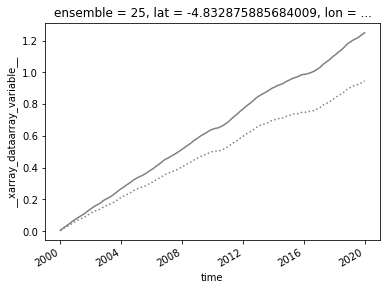

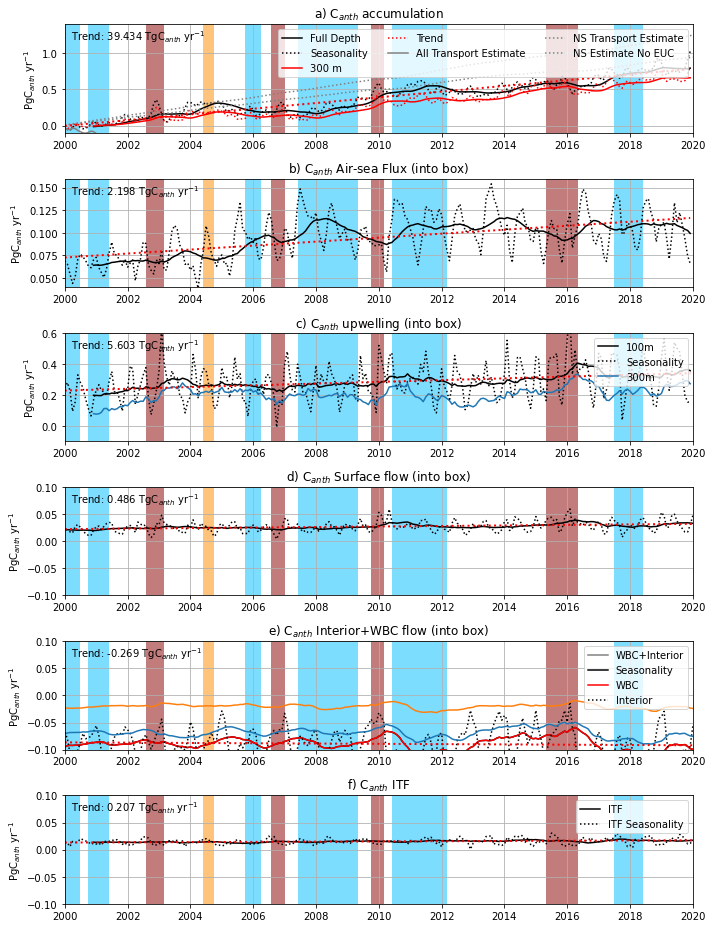

In [192]:
plt.figure(figsize=(10,13))
ax=plt.subplot(611)
(corr_ds_extra_loaded['anth_co2_accumululation']-corr_ds_extra_loaded['anth_co2_accumululation'].values[0]).rolling(time=12).mean().plot(c='k')
(corr_ds_extra_loaded['anth_co2_accumululation']-corr_ds_extra_loaded['anth_co2_accumululation'].values[0]).plot(c='k',linestyle=':')

accum_300m=((tot_anth_dic_cafe.sel(lat=slice(-5,5),lon=slice(160,300)).sel(st_ocean=slice(0,-300)).sum(['lat','lon','st_ocean'])*12)/1e18).sel(time=slice('2000','2019-12-31'))
(accum_300m-accum_300m.values[0]).rolling(time=12).mean().plot(c='r')
(accum_300m-accum_300m.values[0]).plot(c='r',linestyle=':')



#accumulation_estimate.rolling(time=12).mean().plot(c='gray')
(-(surface_out+wbcsubsurface_in+co2_flux1+upwelling1+euc_in).sel(time=slice('2000','2020')).cumsum()/12).plot(c='gray')
(-(surface_out+wbcsubsurface_in+euc_in).sel(time=slice('2000','2020')).cumsum()/12).plot(c='gray',linestyle=':')
(-(surface_out+wbcsubsurface_in).sel(time=slice('2000','2020')).cumsum()/12).plot(c='gray',linestyle=':')

#((surface_out+wbcsubsurface_in).rolling(time=12).mean().cumsum()/12).plot(c='gray',linestyle=':')
#((surface_out+wbcsubsurface_in).rolling(time=12).mean().cumsum()/12).plot(c='gray')



plt.legend(['Full Depth','Seasonality','300 m','Trend','All Transport Estimate','NS Transport Estimate','NS Estimate No EUC'],loc='upper right',ncol=3)

plt.title('a) C$_{anth}$ accumulation')
#corr_ds_extra_loaded['anth_co2_accumululation_detrend'].plot()
#((corr_ds_extra_loaded['anth_co2flux'])).plot()
plt.xlim([np.datetime64('2000'),np.datetime64('2020')])
plt.xticks(rotation=0,ha='center')
#plt.ylabel('PgCanth yr')
plt.ylabel('PgC$_{anth}$ yr$^{-1}$')
res1=linear_trend(ax,x=corr_ds_extra_loaded['anth_co2_accumululation'].time.values,
                y=corr_ds_extra_loaded['anth_co2_accumululation']-corr_ds_extra_loaded['anth_co2_accumululation'].values[0])#)
plt.text(0.01,0.85, f'Trend: {np.round(res1[0]*365*1000,3)} TgC$_{{anth}}$ yr$^{{-1}}$',fontsize=10, transform = ax.transAxes)
plt.ylim([-0.1,1.4])
plt.xlabel('')
plt.grid(visible=True,which='both')
add_enso_colours(ax)




ax=plt.subplot(612)
co=(((-cafe_co2_anth*area_m2).sel(lat=slice(-5,5),time=slice('2000','2020')).sum(['lat','lon']).rolling(time=12).mean())*12*60*60*24*365)/1e18
co1=(((-cafe_co2_anth*area_m2).sel(lat=slice(-5,5),time=slice('2000','2020')).sum(['lat','lon']))*12*60*60*24*365)/1e18
co.plot(c='k')
co1.plot(c='k',linestyle=':')
plt.title('b) C$_{anth}$ Air-sea Flux (into box)')
#plt.xlim(['2000','2020'])
plt.xlim([np.datetime64('2000'),np.datetime64('2020')])
plt.xticks(rotation=0,ha='center')
plt.ylabel('PgC$_{anth}$ yr$^{-1}$')
#plt.ylabel('PgCanth yr')
res2=linear_trend(ax,x=corr_ds_extra_loaded.time.values,
                y=co1.values)#)
add_enso_colours(ax)
plt.ylim([0.04,0.16])
plt.xlabel('')
plt.grid(visible=True,which='both')
plt.text(0.01,0.85, f'Trend: {np.round(res2[0]*365*1000,3)} TgC$_{{anth}}$ yr$^{{-1}}$',fontsize=10, transform = ax.transAxes)






ax=plt.subplot(613)
((corr_ds_extra['Canth upwelling 100m']*60*60*24*365*12)/1e15).rolling(time=12).mean().plot(c='k')
((corr_ds_extra['Canth upwelling 100m']*60*60*24*365*12)/1e15).plot(c='k',linestyle=':')

((anthupwelling.sel(time=slice('2000','2019-12-31'),lat=slice(-5,5),lon=slice(160,300)).sum(['lat','lon']).sel(st_ocean=-300,method='nearest')*60*60*24*365*12)/1e18).rolling(time=12).mean().plot()
plt.title('c) C$_{anth}$ upwelling (into box)')
plt.legend(['100m','Seasonality','300m'],loc='upper right')
#plt.xlim(['2000','2020'])
plt.xlim([np.datetime64('2000'),np.datetime64('2020')])
plt.xticks(rotation=0,ha='center')
#plt.ylabel('PgCanth yr')
plt.ylabel('PgC$_{anth}$ yr$^{-1}$')
res3=linear_trend(ax,x=corr_ds_extra.time.values,
                y=((corr_ds_extra['Canth upwelling 100m']*60*60*24*365*12)/1e15))#)
add_enso_colours(ax)
plt.ylim([-0.1,0.6])
plt.grid(visible=True,which='both')
plt.text(0.01,0.85, f'Trend: {np.round(res3[0]*365*1000,3)} TgC$_{{anth}}$ yr$^{{-1}}$',fontsize=10, transform = ax.transAxes)
plt.xlabel('')




ax=plt.subplot(614)
#((corr_ds_extra_loaded['anthC_surface_flow']*60*60*24*365*12)/1e18).plot(c='k')
(anth_surface).plot(c='k')
(anth_surface_seasonal).plot(c='k',linestyle=':')
plt.title('d) C$_{anth}$ Surface flow (into box)')
#plt.xlim(['2000','2020'])
plt.xlim([np.datetime64('2000'),np.datetime64('2020')])
plt.xticks(rotation=0,ha='center')
plt.ylabel('PgC$_{anth}$ yr$^{-1}$')
plt.xlabel('')
res4=linear_trend(ax,x=anth_surface_seasonal.sel(time=slice('2000','2020-01-01')).time.values,                 #x=corr_ds_extra_loaded.time.values
                y=anth_surface_seasonal.sel(time=slice('2000','2020-01-01')))
add_enso_colours(ax)
plt.ylim([-0.1,0.1])
plt.grid(visible=True,which='both')
plt.text(0.01,0.85, f'Trend: {np.round(res4[0]*365*1000,3)} TgC$_{{anth}}$ yr$^{{-1}}$',fontsize=10, transform = ax.transAxes)




ax=plt.subplot(615)

anth_wbc=anthymertrans_wbcS+anthymertrans_wbcN
anth_interior=anthymertrans_subsurfaceS+anthymertrans_subsurfaceN
anth_wbc_seasonal=anthymertrans_wbcS_seasonal+anthymertrans_wbcN_seasonal
anth_interior_seasonal=anthymertrans_subsurfaceS_seasonal+anthymertrans_subsurfaceN_seasonal
(corr_ds_extra_loaded['anthC_subsurface+wbc_flow']).plot(c='grey')
((anth_wbc+anth_interior)).plot(c='k')
((anthymertrans_WBCsubsurfaceS+anthymertrans_WBCsubsurfaceN)).plot(c='r')

((anth_wbc_seasonal+anth_interior_seasonal)).plot(c='k',linestyle=':')
(anth_wbc).plot()
(anth_interior).plot()


plt.legend(['WBC+Interior','Seasonality','WBC','Interior'],loc='upper right')
plt.xlabel('')
plt.title('e) C$_{anth}$ Interior+WBC flow (into box)')
#plt.xlim(['2000','2020'])
plt.xlim([np.datetime64('2000'),np.datetime64('2020')])
plt.xticks(rotation=0,ha='center')
plt.ylabel('PgC$_{anth}$ yr$^{-1}$')
res5=linear_trend(ax,x=(anthymertrans_WBCsubsurfaceN.sel(time=slice('2000','2020-01-01'))).time.values,#corr_ds_extra_loaded.time.values,
                y=(anthymertrans_WBCsubsurfaceS+anthymertrans_WBCsubsurfaceN.sel(time=slice('2000','2020-01-01'))))

add_enso_colours(ax)
plt.ylim([-0.1,0.1])
plt.grid(visible=True,which='both')
plt.text(0.01,0.85, f'Trend: {np.round(res5[0]*365*1000,3)} TgC$_{{anth}}$ yr$^{{-1}}$',fontsize=10, transform = ax.transAxes)




ax=plt.subplot(616)
#((anth_dic_u_tx.sel(lat=slice(-5,5),st_ocean=slice(0,-600)).sel(lon=160,method='nearest').sum(dim=['st_ocean','lat']).rolling(time=12).mean()*60*60*24*365*12)/1e18).plot(c='k')
#((anth_dic_u_tx.sel(lat=slice(-5,5),st_ocean=slice(0,-600)).sel(lon=160,method='nearest').sum(dim=['st_ocean','lat'])*60*60*24*365*12)/1e18).plot(c='k',linestyle=':')

#((anth_dic_u_tx.sel(lat=slice(-5,5),st_ocean=slice(0,-600)).sel(lon=130,method='nearest').sum(dim=['st_ocean','lat']).rolling(time=12).mean()*60*60*24*365*12)/1e18).plot()
#((anth_dic_u_tx.sel(lat=slice(-5,5),st_ocean=slice(0,-600)).sel(lon=124,method='nearest').sum(dim=['st_ocean','lat']).rolling(time=12).mean()*60*60*24*365*12)/1e18).plot()
(itf_canth).rolling(time=12).mean().plot(c='k')
(itf_canth).plot(c='k',linestyle=':')

plt.title('f) C$_{anth}$ ITF')
plt.legend(['ITF','ITF Seasonality','130E','124E'],loc='upper right')
#plt.xlim(['2000','2020'])
plt.xlim([np.datetime64('2000'),np.datetime64('2020')])
plt.xticks(rotation=0,ha='center')
plt.ylabel('PgC$_{anth}$ yr$^{-1}$')
plt.xlabel('')
res6=linear_trend(ax,x=itf_canth.time,
                y=itf_canth)

add_enso_colours(ax)
plt.ylim([-0.1,0.1])
plt.grid(visible=True,which='both')
plt.text(0.01,0.85, f'Trend: {np.round(res6[0]*365*1000,3)} TgC$_{{anth}}$ yr$^{{-1}}$',fontsize=10, transform = ax.transAxes)

plt.tight_layout()

In [101]:
# Compare both Canth accumulation and ITF plots for tx and Canth
cafe_wt

<xarray.DataArray 'wt' (time: 731, sw_ocean: 29, lat: 140, lon: 170)>
[504536200 values with dtype=float32]
Coordinates:
    ensemble  int32 25
  * sw_ocean  (sw_ocean) float64 -10.0 -20.0 -30.0 ... -601.1 -739.1 -890.9
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
Attributes:
    cell_methods:  time: mean
    long_name:     dia-surface velocity T-points
    units:         m/sec
    valid_range:   [-0.2  0.2]

In [82]:
itf1_canth=anth_dic_u_tx.sel(lat=-5,method='nearest').sel(lon=slice(120,130),st_ocean=slice(0,-300),time=slice('2000','2020'))#.rename({'lon_x':'lon'}).interp({'lon':anth_dic_cafe_rv.lon})
itf2_canth=anth_dic_v_tx.sel(lon=120,method='nearest').sel(lat=slice(-5,5),st_ocean=slice(0,-300),time=slice('2000','2020'))#.rename({'lat_x':'lat'}).interp({'lat':anth_dic_cafe_rv.lat})

itf1_canth=((itf1_canth*60*60*24*365*12)/1e18).sum(['lon','st_ocean'])
itf2_canth=((itf2_canth*60*60*24*365*12)/1e18).sum(['lat','st_ocean'])
#itf_canth=(itf1_canth+itf2_canth).load()

#upwelling_tx_canth=((upwelling_tx_canth*anth_dic_cafe_rv.sel(lat=-5,st_ocean=-300,method='nearest').sel(lon=slice(120,130),time=slice('2000','2020'))*60*60*24*365*12)/1e18)
#upwelling_tx_canth=((cafe_wt.chunk('auto').sel(lat=slice(-5,5),time=slice('2000','2020')).sel(sw_ocean=-300,method='nearest')*area_m2).sum(['lat','lon'])/1e6).rename({'sw_ocean':'st_ocean'})#.interp({'st_ocean':anth_dic_cafe.st_ocean})


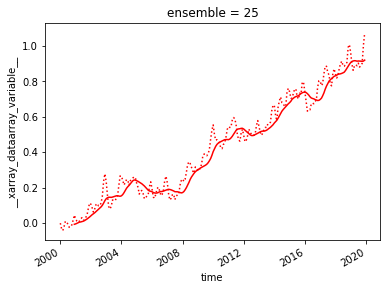

In [176]:
up=((((anthupwelling.sel(time=slice('2000','2019-12-31'),lat=slice(-5,5),lon=slice(160,300)).sum(['lat','lon']).sel(st_ocean=-300,method='nearest')))*60*60*24*365*12)/1e18).rolling(time=12).mean()#.plot()
surf_anth=-((anthymertrans_surfaceN_seasonal+anthymertrans_surfaceS_seasonal)).sel(time=slice('2000','2020'))#*60*60*24*365*12)/1e18
subsurf_anth=-((anthymertrans_WBCsubsurfaceS_seasonal+anthymertrans_WBCsubsurfaceN_seasonal)).sel(time=slice('2000','2020'))#*60*60*24*365*12)/1e18
co1=(((-cafe_co2_anth*area_m2).sel(lat=slice(-5,5),time=slice('2000','2020')).sum(['lat','lon']))*12*60*60*24*365)/1e18

accum_300m=((-raw_canth_area.sel(lat=slice(-5,5),lon=slice(120,300)).sel(st_ocean=slice(0,-300)).sum(['lat','lon','st_ocean'])*12)/1e18).sel(time=slice('2000','2019-12-31'))
(accum_300m-accum_300m.values[0]).rolling(time=12).mean().plot(c='r')
(accum_300m-accum_300m.values[0]).plot(c='r',linestyle=':')


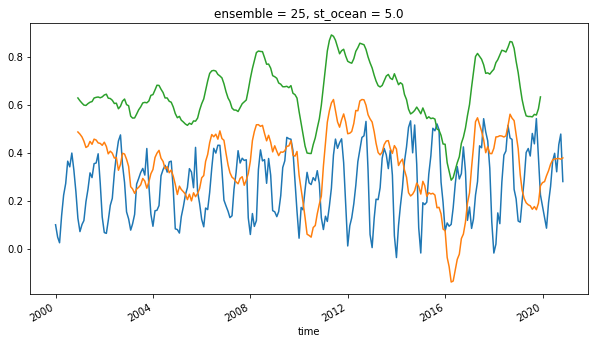

In [219]:
plt.figure(figsize=(10,5))
#(itf1_canth).plot()
#(itf2_canth).plot()
(-itf_canth).plot()
(((surf_anth+subsurf_anth)*12*60*60*24*365)/1e18).rolling(time=12).mean().plot()

((((surf_anth+subsurf_anth+up+co1)*12*60*60*24*365)/1e18)+co1).rolling(time=12).mean().plot()

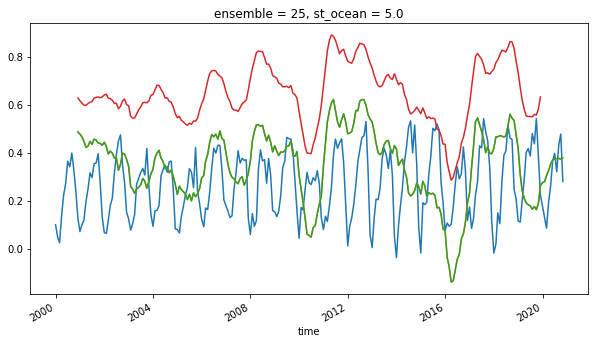

In [173]:
plt.show()

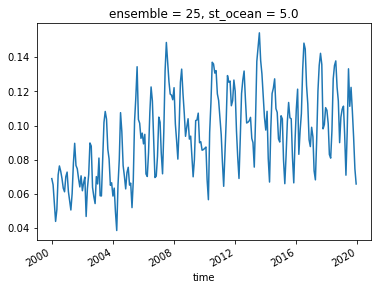

In [181]:
co1.plot()

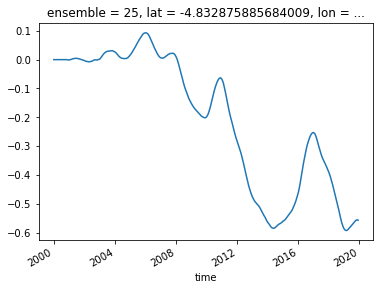

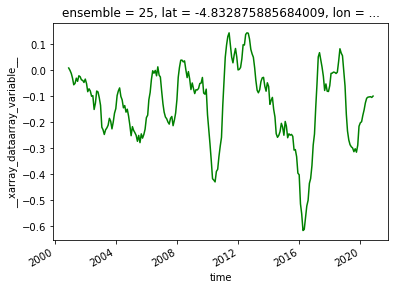

In [201]:
accum_est_itf_diff1.plot(c='g')

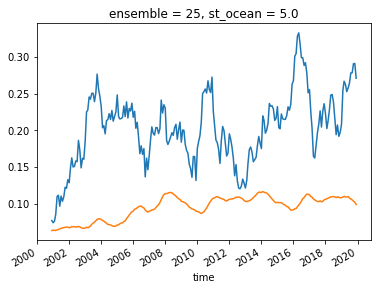

In [200]:
((((up)*12*60*60*24*365)/1e18)).rolling(time=12).mean().plot()
co1.rolling(time=12).mean().plot()

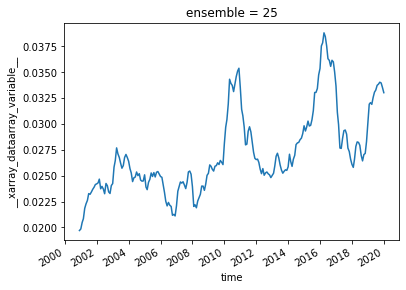

In [165]:
((surf_anth).rolling(time=12).mean()).plot()

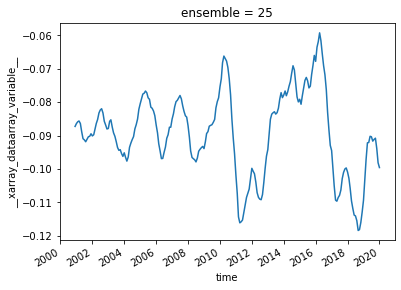

In [166]:
(((subsurf_anth)).rolling(time=12).mean()).plot()

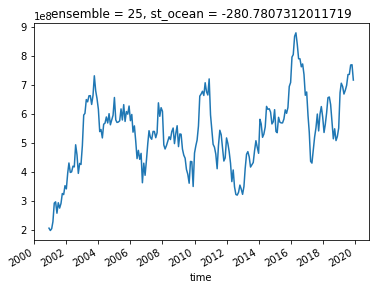

In [167]:
(((up)).rolling(time=12).mean()).plot()

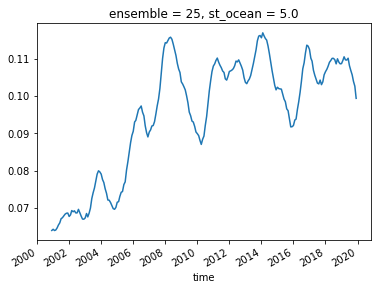

In [168]:
(((co1))).rolling(time=12).mean().plot()

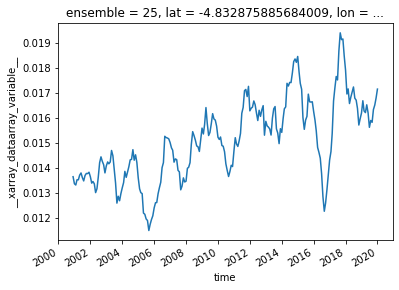

In [169]:
(((itf_canth)).rolling(time=12).mean()).plot()

In [175]:
up

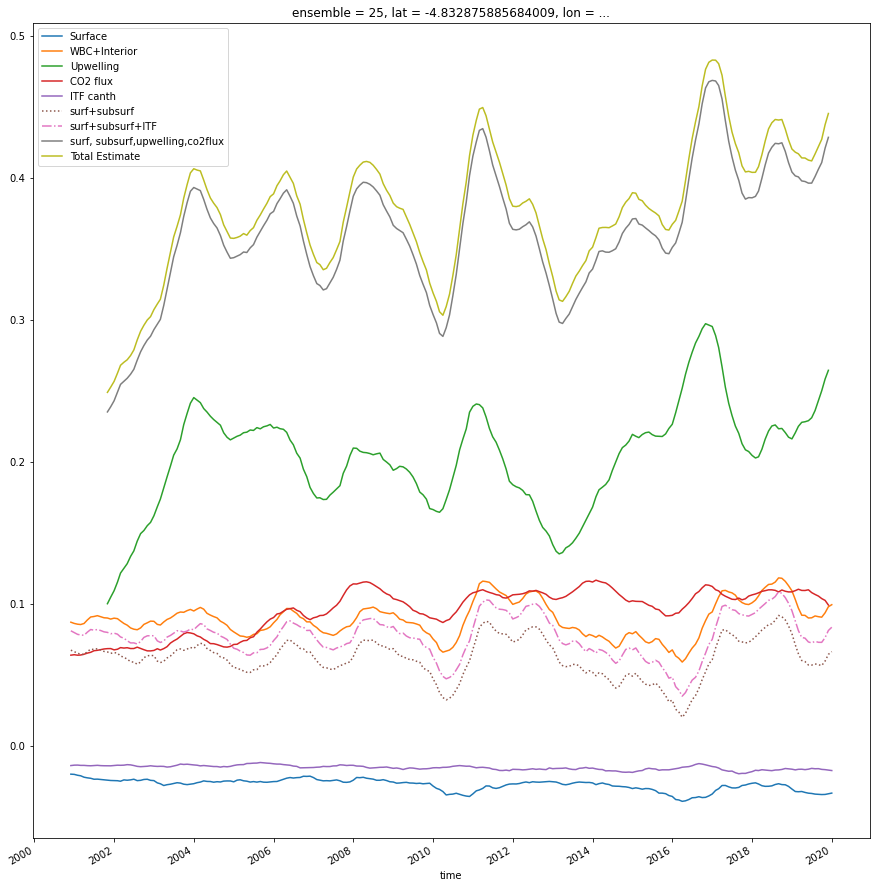

In [181]:
plt.figure(figsize=(15,15))
((surf_anth).rolling(time=12).mean()).plot()
(((subsurf_anth)).rolling(time=12).mean()).plot()
(((up)).rolling(time=12).mean()).plot()
(((co1))).rolling(time=12).mean().plot()
(((-itf_canth)).rolling(time=12).mean()).plot()

((surf_anth+subsurf_anth).rolling(time=12).mean()).plot(linestyle=':')
((surf_anth+subsurf_anth+itf_canth).rolling(time=12).mean()).plot(linestyle='-.')
(surf_anth+subsurf_anth+up+co1).rolling(time=12).mean().plot()
(surf_anth+subsurf_anth+up+co1+itf_canth).rolling(time=12).mean().plot()

#(((((subsurf_anth)*12*60*60*24*365)/1e18)).rolling(time=12).mean()).plot()
plt.legend(['Surface','WBC+Interior','Upwelling','CO2 flux','ITF canth','surf+subsurf','surf+subsurf+ITF','surf, subsurf,upwelling,co2flux','Total Estimate'])

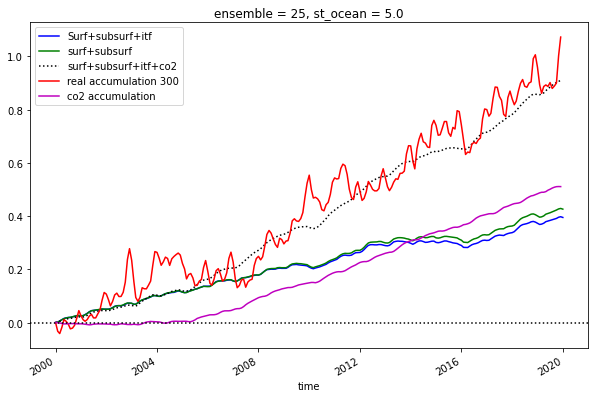

In [187]:
plt.figure(figsize=(10,6))
accum_est_itf=((surf_anth+subsurf_anth+-itf_canth))#.rolling(time=12).mean())
accum_est_itf_diff=accum_est_itf-accum_est_itf.sel(time='2000-01-01')
#(accum_est_itf_diff).plot(c='b')
((accum_est_itf_diff).cumsum(dim='time')/12).plot(c='b')#,linestyle=':')
               
accum_est_itf1=((surf_anth+subsurf_anth))#.rolling(time=12).mean())
accum_est_itf_diff1=accum_est_itf1-accum_est_itf1.sel(time='2000-01-01')
#(accum_est_itf_diff1).plot(c='g')
((accum_est_itf_diff1).cumsum(dim='time')/12).plot(c='g')#,linestyle=':')
    
               
accum_est_itf1=((surf_anth+subsurf_anth+-itf_canth+co1))#.rolling(time=12).mean())
accum_est_itf_diff1=accum_est_itf1-accum_est_itf1.sel(time='2000-01-01')
#(accum_est_itf_diff1).plot(c='k')
((accum_est_itf_diff1).cumsum(dim='time')/12).plot(c='k',linestyle=':')
    
# Whats the bet that Upwelling is able to close this, and tjat i screwed up the area integration there too.

(accum_300m-accum_300m.values[0]).plot(c='r')
((co1-co1.sel(time='2000-01-01')).cumsum()/12).plot(c='m')
plt.axhline(0,c='k',linestyle=':')
plt.legend(['Surf+subsurf+itf','surf+subsurf','surf+subsurf+itf+co2','real accumulation 300','co2 accumulation'])

In [33]:
np.cumsum([5,2,1,5,-59,30,12,-49,12,99,-1,-12])

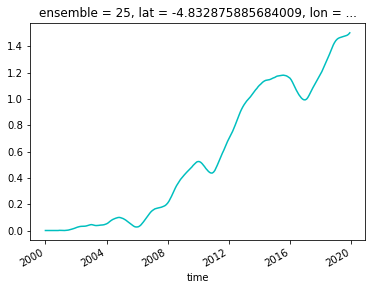

In [44]:
#accum_est_itx1=(((((surf_anth+subsurf_anth)*12*60*60*24*365)/1e18)+itf_canth).rolling(time=12).mean())
accum_est_itf1=(((((surf_anth+subsurf_anth)*12*60*60*24*365)/1e18)+itf_canth).rolling(time=12).mean())#.plot()
accum_est_itf_diff1=(accum_est_itf1.cumsum(dim='time')/12)-((accum_est_itf1.cumsum(dim='time')/12).sel(time='2001-01-01'))
(accum_est_itf_diff.cumsum(dim='time')/12).plot(c='c')
#((accum_est_itf_diff1).cumsum(dim='time')/12).plot(c='c',linestyle=':')
#(((((surf_anth+subsurf_anth)*12*60*60*24*365)/1e18)+itf_canth).rolling(time=12).mean()).plot(linestyle=':')


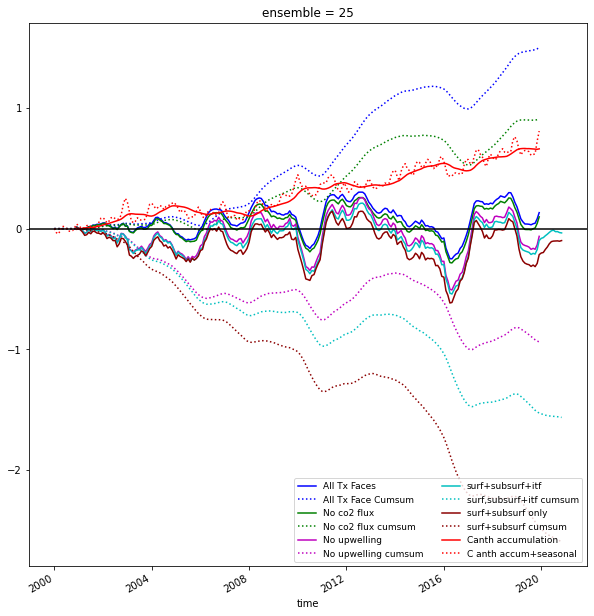

In [36]:
plt.figure(figsize=(10,10))
accum_est_itf=(((((surf_anth+subsurf_anth+up)*12*60*60*24*365)/1e18)+co1+itf_canth).rolling(time=12).mean())#.plot()#*up
accum_est_itf_diff=accum_est_itf-accum_est_itf.sel(time='2001-01-01')
(accum_est_itf_diff).plot(c='b')
((accum_est_itf_diff).cumsum(dim='time')/12).plot(c='b',linestyle=':')

#accum_est_itx1=(((((surf_anth+subsurf_anth)*12*60*60*24*365)/1e18)+itf_canth).rolling(time=12).mean())
accum_est_itf1=(((((surf_anth+subsurf_anth+up)*12*60*60*24*365)/1e18)+itf_canth).rolling(time=12).mean())#.plot()
accum_est_itf_diff1=accum_est_itf1-accum_est_itf1.sel(time='2001-01-01')
accum_est_itf_diff1.plot(c='g')
((accum_est_itf_diff1).cumsum(dim='time')/12).plot(c='g',linestyle=':')

#accum_est_itx1=(((((surf_anth+subsurf_anth)*12*60*60*24*365)/1e18)+itf_canth).rolling(time=12).mean())
accum_est_itf1=(((((surf_anth+subsurf_anth)*12*60*60*24*365)/1e18)+co1+itf_canth).rolling(time=12).mean())#.plot()
accum_est_itf_diff1=accum_est_itf1-accum_est_itf1.sel(time='2001-01-01')
accum_est_itf_diff1.plot(c='m')
((accum_est_itf_diff1).cumsum(dim='time')/12).plot(c='m',linestyle=':')


#accum_est_itx1=(((((surf_anth+subsurf_anth)*12*60*60*24*365)/1e18)+itf_canth).rolling(time=12).mean())
accum_est_itf1=(((((surf_anth+subsurf_anth)*12*60*60*24*365)/1e18)+itf_canth).rolling(time=12).mean())#.plot()
accum_est_itf_diff1=accum_est_itf1-accum_est_itf1.sel(time='2001-01-01')
accum_est_itf_diff1.plot(c='c')
((accum_est_itf_diff1).cumsum(dim='time')/12).plot(c='c',linestyle=':')
#(((((surf_anth+subsurf_anth)*12*60*60*24*365)/1e18)+itf_canth).rolling(time=12).mean()).plot(linestyle=':')

accum_est_itf2=(((((surf_anth+subsurf_anth)*12*60*60*24*365)/1e18)).rolling(time=12).mean())#.plot()
accum_est_itf_diff2=accum_est_itf2-accum_est_itf2.sel(time='2001-01-01')
accum_est_itf_diff2.plot(c='darkred')
((accum_est_itf_diff2).cumsum(dim='time')/12).plot(c='darkred',linestyle=':')


accum_300m=((tot_anth_dic_cafe.sel(lat=slice(-5,5),lon=slice(160,300)).sel(st_ocean=slice(0,-300)).sum(['lat','lon','st_ocean'])*12)/1e18).sel(time=slice('2000','2019-12-31'))
(accum_300m-accum_300m.values[0]).rolling(time=12).mean().plot(c='r')
(accum_300m-accum_300m.values[0]).plot(c='r',linestyle=':')


#(-accum_est_itf_diff).plot(c='b',linestyle='-.')
#(-(accum_est_itf_diff).cumsum(dim='time')/12).plot(c='b',linestyle='-')

plt.axhline(0,c='k')
plt.legend(['All Tx Faces','All Tx Face Cumsum',
            'No co2 flux','No co2 flux cumsum',
            'No upwelling', 'No upwelling cumsum',
            'surf+subsurf+itf','surf,subsurf+itf cumsum',
            'surf+subsurf only','surf+subsurf cumsum',
            'Canth accumulation','C anth accum+seasonal'],ncol=2,fontsize=9,loc='lower left')
#            ''Surf+Subsurf+ITF Accumulation''Surf+Subsurf Only','Canth Accumulation 300'])
           

(-0.3, 10.0)

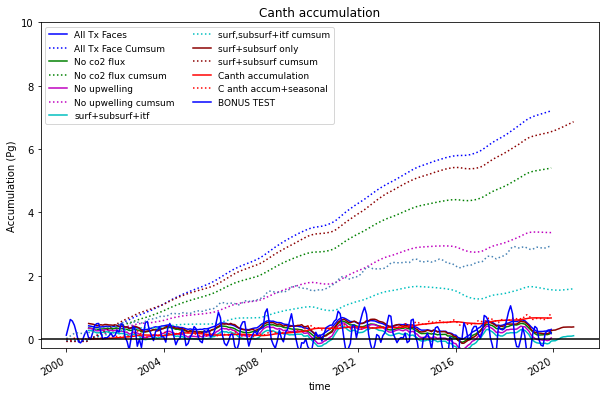

In [85]:
plt.figure(figsize=(10,6))
accum_est_itf=(((((surf_anth+subsurf_anth+up)*12*60*60*24*365)/1e18)+co1+itf_canth).rolling(time=12).mean())#.plot()#*up
accum_est_itf_diff=((accum_est_itf).cumsum(dim='time')/12)
accum_est_itf.plot(c='b')
(accum_est_itf_diff-accum_est_itf_diff.sel(time='2001-01-01')).plot(c='b',linestyle=':')

#accum_est_itx1=(((((surf_anth+subsurf_anth)*12*60*60*24*365)/1e18)+itf_canth).rolling(time=12).mean())
accum_est_itf1=(((((surf_anth+subsurf_anth+up)*12*60*60*24*365)/1e18)+itf_canth).rolling(time=12).mean())#.plot()
accum_est_itf_diff1=((accum_est_itf1).cumsum(dim='time')/12)
accum_est_itf1.plot(c='g')
(accum_est_itf_diff1-accum_est_itf_diff1.sel(time='2001-01-01')).plot(c='g',linestyle=':')


#accum_est_itx1=(((((surf_anth+subsurf_anth)*12*60*60*24*365)/1e18)+itf_canth).rolling(time=12).mean())
accum_est_itf1=(((((surf_anth+subsurf_anth)*12*60*60*24*365)/1e18)+co1+itf_canth).rolling(time=12).mean())#.plot()
accum_est_itf_diff1=((accum_est_itf1).cumsum(dim='time')/12)
accum_est_itf1.plot(c='m')
(accum_est_itf_diff1-accum_est_itf_diff1.sel(time='2001-01-01')).plot(c='m',linestyle=':')


#accum_est_itx1=(((((surf_anth+subsurf_anth)*12*60*60*24*365)/1e18)+itf_canth).rolling(time=12).mean())
accum_est_itf1=(((((surf_anth+subsurf_anth)*12*60*60*24*365)/1e18)+itf_canth).rolling(time=12).mean())#.plot()
accum_est_itf_diff1=((accum_est_itf1).cumsum(dim='time')/12)
accum_est_itf1.plot(c='c')
(accum_est_itf_diff1-accum_est_itf_diff1.sel(time='2001-01-01')).plot(c='c',linestyle=':')


accum_est_itf2=(((((surf_anth+subsurf_anth)*12*60*60*24*365)/1e18)).rolling(time=12).mean())#.plot()
accum_est_itf_diff2=((accum_est_itf2).cumsum(dim='time')/12)
accum_est_itf2.plot(c='darkred')
(accum_est_itf_diff2-accum_est_itf_diff2.sel(time='2001-01-01')).plot(c='darkred',linestyle=':')


accum_300m=((tot_anth_dic_cafe.sel(lat=slice(-5,5),lon=slice(160,300)).sel(st_ocean=slice(0,-300)).sum(['lat','lon','st_ocean'])*12)/1e18).sel(time=slice('2000','2019-12-31'))
(accum_300m-accum_300m.values[0]).rolling(time=12).mean().plot(c='r')
(accum_300m-accum_300m.values[0]).plot(c='r',linestyle=':')



accum_est_itf=(((((surf_anth+subsurf_anth+up)*12*60*60*24*365)/1e18)+itf_canth))#.rolling(time=12).mean())
accum_est_itf_diff=accum_est_itf-accum_est_itf.sel(time='2001-01-01')
(accum_est_itf_diff).plot(c='b')
((accum_est_itf_diff).cumsum(dim='time')/12).plot(c='steelblue',linestyle=':')

#(-accum_est_itf_diff).plot(c='b',linestyle='-.')
#(-(accum_est_itf_diff).cumsum(dim='time')/12).plot(c='b',linestyle='-')

plt.axhline(0,c='k')
plt.legend(['All Tx Faces','All Tx Face Cumsum',
            'No co2 flux','No co2 flux cumsum',
            'No upwelling', 'No upwelling cumsum',
            'surf+subsurf+itf','surf,subsurf+itf cumsum',
            'surf+subsurf only','surf+subsurf cumsum',
            'Canth accumulation','C anth accum+seasonal','BONUS TEST'],ncol=2,fontsize=9,loc='upper left')
#            ''Surf+Subsurf+ITF Accumulation''Surf+Subsurf Only','Canth Accumulation 300'])
plt.ylabel('Accumulation (Pg)')
plt.title('Canth accumulation')
plt.ylim([-0.3,10])

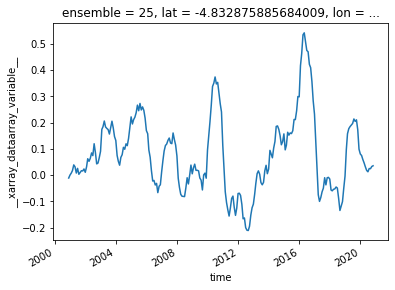

In [171]:
accumulation_itf_diff=accumulation_itf.sel(time='2001-01-01')-accumulation_itf
accumulation_itf_diff.plot()

In [129]:
((anth_dic_cafe_rv.sel(lat=-5,method='nearest').sel(lon=slice(120,130),st_ocean=slice(0,-300),time=slice('2000','2020'))*60*60*24*365*12)/1e18).sum('lon')

<xarray.DataArray '__xarray_dataarray_variable__' (time: 251, st_ocean: 24)>
dask.array<sum-aggregate, shape=(251, 24), dtype=float32, chunksize=(87, 24), chunktype=numpy.ndarray>
Coordinates:
    ensemble  int32 25
  * st_ocean  (st_ocean) float64 -5.0 -15.0 -25.0 -35.0 ... -216.8 -241.3 -280.8
  * time      (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2020-11-01
    lat       float64 -4.833

In [119]:
cafe_y_tx.sel(lon=120,method='nearest').sel(lat_x=slice(-5,5),st_ocean=slice(0,-300),time=slice('2000','2020')).rename({'lat_x':'lat'}).interp({'lat':anth_dic_cafe.lat})

<xarray.DataArray 'ty_trans' (time: 251, st_ocean: 24, lat: 140)>
dask.array<dask_aware_interpnd, shape=(251, 24, 140), dtype=float32, chunksize=(103, 24, 140), chunktype=numpy.ndarray>
Coordinates:
    ensemble  int32 25
  * st_ocean  (st_ocean) float64 -5.0 -15.0 -25.0 -35.0 ... -216.8 -241.3 -280.8
  * time      (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2020-11-01
    lon       float64 120.5
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
Attributes:
    cell_methods:   time: mean
    long_name:      T-cell j-mass transport
    standard_name:  ocean_y_mass_transport
    units:          Sv (10^9 kg/s)
    valid_range:    [-1.00000002e+20  1.00000002e+20]

In [95]:
anth_dic_cafe

<xarray.DataArray '__xarray_dataarray_variable__' (time: 731, st_ocean: 50, lat: 140, lon: 170)>
dask.array<xarray-__xarray_dataarray_variable__, shape=(731, 50, 140, 170), dtype=float32, chunksize=(87, 50, 70, 85), chunktype=numpy.ndarray>
Coordinates:
    ensemble  int32 ...
  * st_ocean  (st_ocean) float64 5.0 15.0 25.0 ... 5.166e+03 5.499e+03 5.831e+03
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34

In [219]:
ymertrans_WBCsubsurfaceN

In [88]:
surf=((ymertrans_surfaceN_seasonal+ymertrans_surfaceS_seasonal)).sel(time=slice('2000','2020'))#*60*60*24*365*12)/1e18
subsurf=((ymertrans_WBCsubsurfaceS_seasonal+ymertrans_WBCsubsurfaceN_seasonal)).sel(time=slice('2000','2020'))#*60*60*24*365*12)/1e18
upwelling_tx=(cafe_wt.chunk('auto').sel(lat=slice(-5,5),time=slice('2000','2020')).sel(sw_ocean=-300,method='nearest')*area_m2).sum(['lat','lon'])/1e6
itf1=cafe_x_tx.sel(lat=-5,method='nearest').sel(lon_x=slice(120,130),st_ocean=slice(0,-300),time=slice('2000','2020'))
itf2=cafe_y_tx.sel(lon=120,method='nearest').sel(lat_x=slice(-5,5),st_ocean=slice(0,-300),time=slice('2000','2020'))

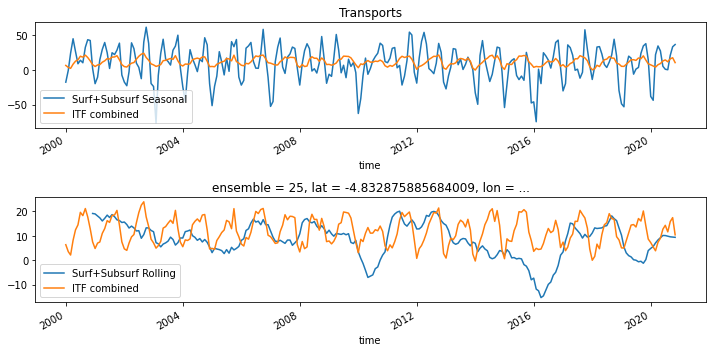

In [94]:
#(surf+subsurf+upwelling_tx).plot()
plt.figure(figsize=(10,5))
plt.subplot(211)
(surf+subsurf).plot()
(-((itf1.sum(['st_ocean','lon_x'])+itf2.sum(['st_ocean','lat_x'])))).plot()
#(-((itf1.sum(['st_ocean','lon_x'])+itf2.sum(['st_ocean','lat_x'])))).plot()
plt.legend(['Surf+Subsurf Seasonal','ITF combined'])
plt.title('Transports')
plt.subplot(212)
(surf+subsurf).rolling(time=12).mean().plot()
(-((itf1.sum(['st_ocean','lon_x'])+itf2.sum(['st_ocean','lat_x'])))).plot()
plt.legend(['Surf+Subsurf Rolling','ITF combined'])
plt.tight_layout()

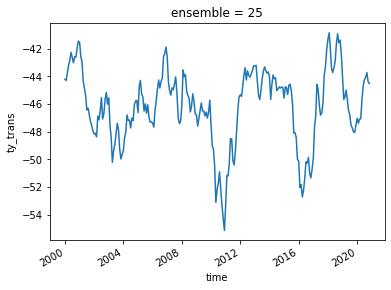

In [54]:
surf.plot()

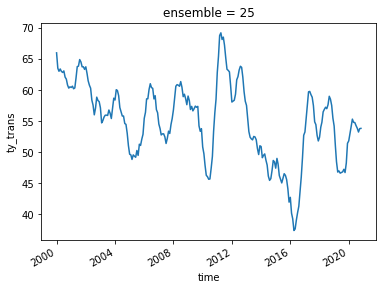

In [55]:
subsurf.plot()

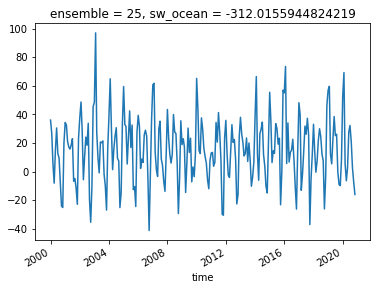

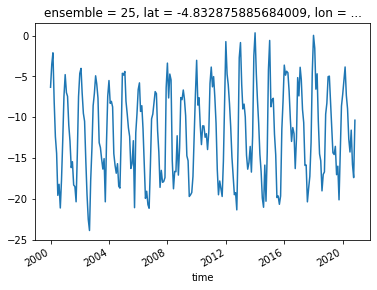

<xarray.DataArray 'ty_trans' (time: 731)>
dask.array<neg, shape=(731,), dtype=float64, chunksize=(114,), chunktype=numpy.ndarray>
Coordinates:
    ensemble  int32 25
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
    lat_x     float64 5.0
    lat       float64 5.167

In [219]:
# AS ABOVE BUT TRANSPORTS ONLY
# Total transport sum compared to accumulation?
co2_flux1=(((-cafe_co2_anth*area_m2).sel(lat=slice(-5,5),time=slice('2000','2020')).sum(['lat','lon']))*12*60*60*24*365)/1e18
upwelling1=((anthupwelling.sel(time=slice('2000','2019-12-31'),lat=slice(-5,5),lon=slice(160,300)).sum(['lat','lon']).sel(st_ocean=-300,method='nearest')*60*60*24*365*12)/1e18)
surface_out=(anth_surface_seasonal*60*60*24*365*12)/1e18#).sum(['lat','lon'])
wbc_in=((ymertrans_wbcS+ymertrans_wbcN)*60*60*24*365*12)/1e18#.sum(['lat','lon']#)
wbcsubsurface_in=((ymertrans_WBCsubsurfaceS+ymertrans_WBCsubsurfaceN)*60*60*24*365*12)/1e18
interior_in=((ymertrans_subsurfaceS+ymertrans_subsurfaceN)*60*60*24*365*12)/1e18#.sum(['lat','lon'])
#euc_in=((anth_dic_u_tx.sel(lat=slice(-5,5),st_ocean=slice(0,-600)).sel(lon=124,method='nearest').sum(dim=['st_ocean','lat'])*60*60*24*365*12)/1e18)#.plot() #.rolling(time=12).mean()




plt.figure(figsize=(10,13))
ax=plt.subplot(611)
(corr_ds_extra_loaded['anth_co2_accumululation']-corr_ds_extra_loaded['anth_co2_accumululation'].values[0]).rolling(time=12).mean().plot(c='k')
(corr_ds_extra_loaded['anth_co2_accumululation']-corr_ds_extra_loaded['anth_co2_accumululation'].values[0]).plot(c='k',linestyle=':')

accum_300m=((tot_anth_dic_cafe.sel(lat=slice(-5,5),lon=slice(160,300)).sel(st_ocean=slice(0,-300)).sum(['lat','lon','st_ocean'])*12)/1e18).sel(time=slice('2000','2019-12-31'))
(accum_300m-accum_300m.values[0]).rolling(time=12).mean().plot(c='r')
(accum_300m-accum_300m.values[0]).plot(c='r',linestyle=':')



#accumulation_estimate.rolling(time=12).mean().plot(c='gray')
(surface_out+wbcsubsurface_in+co2_flux1+upwelling1).rolling(time=12).mean().plot(c='gray',linestyle=':')
(surface_out+wbcsubsurface_in).rolling(time=12).mean().plot(c='gray')



plt.legend(['Full Depth','Seasonality','300 m','Trend','All Transport Estimate','NS Transport Estimate'],loc='upper right',ncol=3)

plt.title('a) C$_{anth}$ accumulation')
#corr_ds_extra_loaded['anth_co2_accumululation_detrend'].plot()
#((corr_ds_extra_loaded['anth_co2flux'])).plot()
plt.xlim([np.datetime64('2000'),np.datetime64('2020')])
plt.xticks(rotation=0,ha='center')
#plt.ylabel('PgCanth yr')
plt.ylabel('PgC$_{anth}$ yr$^{-1}$')
res1=linear_trend(ax,x=corr_ds_extra_loaded['anth_co2_accumululation'].time.values,
                y=corr_ds_extra_loaded['anth_co2_accumululation']-corr_ds_extra_loaded['anth_co2_accumululation'].values[0])#)
plt.text(0.01,0.85, f'Trend: {np.round(res1[0]*365*1000,3)} TgC$_{{anth}}$ yr$^{{-1}}$',fontsize=10, transform = ax.transAxes)
plt.ylim([-0.1,1.1])
plt.xlabel('')
plt.grid(visible=True,which='both')
add_enso_colours(ax)


ax=plt.subplot(612)
co=(((-cafe_co2_anth*area_m2).sel(lat=slice(-5,5),time=slice('2000','2020')).sum(['lat','lon']).rolling(time=12).mean())*12*60*60*24*365)/1e18
co1=(((-cafe_co2_anth*area_m2).sel(lat=slice(-5,5),time=slice('2000','2020')).sum(['lat','lon']))*12*60*60*24*365)/1e18
co.plot(c='k')
co1.plot(c='k',linestyle=':')
plt.title('b) C$_{anth}$ Air-sea Flux (into box)')
#plt.xlim(['2000','2020'])
plt.xlim([np.datetime64('2000'),np.datetime64('2020')])
plt.xticks(rotation=0,ha='center')
plt.ylabel('PgC$_{anth}$ yr$^{-1}$')
#plt.ylabel('PgCanth yr')
res2=linear_trend(ax,x=corr_ds_extra_loaded.time.values,
                y=co1.values)#)
add_enso_colours(ax)
plt.ylim([0.04,0.16])
plt.xlabel('')
plt.grid(visible=True,which='both')
plt.text(0.01,0.85, f'Trend: {np.round(res2[0]*365*1000,3)} TgC$_{{anth}}$ yr$^{{-1}}$',fontsize=10, transform = ax.transAxes)





ax=plt.subplot(613)
((corr_ds_extra['Canth upwelling 100m']*60*60*24*365*12)/1e15).rolling(time=12).mean().plot(c='k')
((corr_ds_extra['Canth upwelling 100m']*60*60*24*365*12)/1e15).plot(c='k',linestyle=':')

((anthupwelling.sel(time=slice('2000','2019-12-31'),lat=slice(-5,5),lon=slice(160,300)).sum(['lat','lon']).sel(st_ocean=-300,method='nearest')*60*60*24*365*12)/1e18).rolling(time=12).mean().plot()
plt.title('c) C$_{anth}$ upwelling (into box)')
plt.legend(['100m','Seasonality','300m'],loc='upper right')
#plt.xlim(['2000','2020'])
plt.xlim([np.datetime64('2000'),np.datetime64('2020')])
plt.xticks(rotation=0,ha='center')
#plt.ylabel('PgCanth yr')
plt.ylabel('PgC$_{anth}$ yr$^{-1}$')
res3=linear_trend(ax,x=corr_ds_extra.time.values,
                y=((corr_ds_extra['Canth upwelling 100m']*60*60*24*365*12)/1e15))#)
add_enso_colours(ax)
plt.ylim([-0.1,0.6])
plt.grid(visible=True,which='both')
plt.text(0.01,0.85, f'Trend: {np.round(res3[0]*365*1000,3)} TgC$_{{anth}}$ yr$^{{-1}}$',fontsize=10, transform = ax.transAxes)
plt.xlabel('')




ax=plt.subplot(614)
#((corr_ds_extra_loaded['anthC_surface_flow']*60*60*24*365*12)/1e18).plot(c='k')
((anth_surface*60*60*24*365*12)/1e18).plot(c='k')
((anth_surface_seasonal*60*60*24*365*12)/1e18).plot(c='k',linestyle=':')
plt.title('d) C$_{anth}$ Surface flow (into box)')
#plt.xlim(['2000','2020'])
plt.xlim([np.datetime64('2000'),np.datetime64('2020')])
plt.xticks(rotation=0,ha='center')
plt.ylabel('PgC$_{anth}$ yr$^{-1}$')
plt.xlabel('')
res4=linear_trend(ax,x=anth_surface_seasonal.sel(time=slice('2000','2020-01-01')).time.values,                 #x=corr_ds_extra_loaded.time.values
                y=((anth_surface_seasonal.sel(time=slice('2000','2020-01-01'))*60*60*24*365*12)/1e18))
add_enso_colours(ax)
plt.ylim([-1.4,-0.3])
plt.grid(visible=True,which='both')
plt.text(0.01,0.85, f'Trend: {np.round(res4[0]*365*1000,3)} TgC$_{{anth}}$ yr$^{{-1}}$',fontsize=10, transform = ax.transAxes)




ax=plt.subplot(615)

anth_wbc=ymertrans_wbcS+ymertrans_wbcN
anth_interior=ymertrans_subsurfaceS+ymertrans_subsurfaceN
anth_wbc_seasonal=ymertrans_wbcS_seasonal+ymertrans_wbcN_seasonal
anth_interior_seasonal=ymertrans_subsurfaceS_seasonal+ymertrans_subsurfaceN_seasonal
((corr_ds_extra_loaded['anthC_subsurface+wbc_flow']*60*60*24*365*12)/1e18).plot(c='grey')
(((anth_wbc+anth_interior)*60*60*24*365*12)/1e18).plot(c='k')
(((ymertrans_WBCsubsurfaceS+ymertrans_WBCsubsurfaceN)*60*60*24*365*12)/1e18).plot(c='r')

(((anth_wbc_seasonal+anth_interior_seasonal)*60*60*24*365*12)/1e18).plot(c='k',linestyle=':')
((anth_wbc*60*60*24*365*12)/1e18).plot()
((anth_interior*60*60*24*365*12)/1e18).plot()


plt.legend(['WBC+Interior','Seasonality','WBC','Interior'],loc='upper right')
plt.xlabel('')
plt.title('e) C$_{anth}$ Interior+WBC flow (into box)')
#plt.xlim(['2000','2020'])
plt.xlim([np.datetime64('2000'),np.datetime64('2020')])
plt.xticks(rotation=0,ha='center')
plt.ylabel('PgC$_{anth}$ yr$^{-1}$')
res5=linear_trend(ax,x=(ymertrans_WBCsubsurfaceN.sel(time=slice('2000','2020-01-01'))).time.values,#corr_ds_extra_loaded.time.values,
                y=(((ymertrans_WBCsubsurfaceS+ymertrans_WBCsubsurfaceN.sel(time=slice('2000','2020-01-01')))*60*60*24*365*12)/1e18))

add_enso_colours(ax)
plt.ylim([0.2,1.5])
plt.grid(visible=True,which='both')
plt.text(0.01,0.85, f'Trend: {np.round(res5[0]*365*1000,3)} TgC$_{{anth}}$ yr$^{{-1}}$',fontsize=10, transform = ax.transAxes)




ax=plt.subplot(616)
((anth_dic_u_tx.sel(lat=slice(-5,5),st_ocean=slice(0,-600)).sel(lon=160,method='nearest').sum(dim=['st_ocean','lat']).rolling(time=12).mean()*60*60*24*365*12)/1e18).plot(c='k')
((anth_dic_u_tx.sel(lat=slice(-5,5),st_ocean=slice(0,-600)).sel(lon=160,method='nearest').sum(dim=['st_ocean','lat'])*60*60*24*365*12)/1e18).plot(c='k',linestyle=':')

((anth_dic_u_tx.sel(lat=slice(-5,5),st_ocean=slice(0,-600)).sel(lon=130,method='nearest').sum(dim=['st_ocean','lat']).rolling(time=12).mean()*60*60*24*365*12)/1e18).plot()
((anth_dic_u_tx.sel(lat=slice(-5,5),st_ocean=slice(0,-600)).sel(lon=124,method='nearest').sum(dim=['st_ocean','lat']).rolling(time=12).mean()*60*60*24*365*12)/1e18).plot()
plt.title('f) C$_{anth}$ EUC advection')
plt.legend(['160E','Seasonality','130E','124E'],loc='upper right')
#plt.xlim(['2000','2020'])
plt.xlim([np.datetime64('2000'),np.datetime64('2020')])
plt.xticks(rotation=0,ha='center')
plt.ylabel('PgC$_{anth}$ yr$^{-1}$')
plt.xlabel('')
res6=linear_trend(ax,x=anth_dic_u_tx.time,
                y=((anth_dic_u_tx.sel(lat=slice(-5,5),st_ocean=slice(0,-600)).sel(lon=160,method='nearest').sum(dim=['st_ocean','lat'])*60*60*24*365*12)/1e18))

add_enso_colours(ax)
plt.ylim([-0.4,1.2])
plt.grid(visible=True,which='both')
plt.text(0.01,0.85, f'Trend: {np.round(res6[0]*365*1000,3)} TgC$_{{anth}}$ yr$^{{-1}}$',fontsize=10, transform = ax.transAxes)

plt.tight_layout()

<xarray.DataArray (time: 731, st_ocean: 50, lat: 140, lon: 170)>
dask.array<mul, shape=(731, 50, 140, 170), dtype=float64, chunksize=(87, 50, 70, 85), chunktype=numpy.ndarray>
Coordinates:
    ensemble    int32 25
  * st_ocean    (st_ocean) float64 -5.0 -15.0 -25.0 ... -5.499e+03 -5.831e+03
  * time        (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lon         (lon) float64 120.5 121.5 122.5 123.5 ... 287.5 288.5 289.5
  * lat         (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
    depth_diff  (st_ocean) float64 5.0 10.0 10.0 10.0 ... 323.6 333.1 332.0

<xarray.DataArray (time: 240)>
dask.array<getitem, shape=(240,), dtype=float64, chunksize=(87,), chunktype=numpy.ndarray>
Coordinates:
    ensemble  int32 25
  * time      (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2019-12-01

In [148]:
#res=linear_trend(ax,x=anth_dic_u_tx.time,
#                y=((anth_dic_u_tx.sel(lat=slice(-5,5),st_ocean=slice(0,-600)).sel(lon=160,method='nearest').sum(dim=['st_ocean','lat'])*60*60*24*365*12)/1e18))
res1

(0.00010803955219700133,
 -1.1875424777182282,
 0.9366841523837262,
 1.9112844819972843e-110)

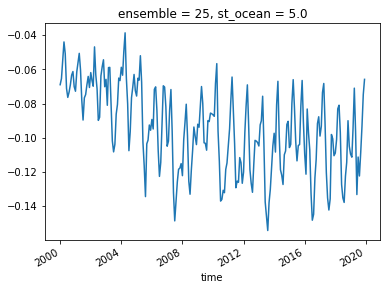

In [139]:
co.plot()

In [46]:
co2_corr1=-cafe_co2_anth.sel(lat=slice(-5,5),lon=slice(160,300),time=slice('2000','2019-12-31')).mean(['lat','lon'])
corr_ds_extra1=co2_corr1.to_dataset(name='C$_{anth}$ air-sea flux')
#corr_ds_extra['Canth upwelling 300m']=anthupwelling.sel(time=slice('2000','2019-12-31'),lat=slice(-5,5),lon=slice(160,300)).mean(['lat','lon']).sel(st_ocean=-300,method='nearest')
corr_ds_extra1['C$_{anth}$ upwelling 100m']=anthupwelling.sel(time=slice('2000','2019-12-31'),lat=slice(-5,5),lon=slice(160,300)).mean(['lat','lon']).sel(st_ocean=-100,method='nearest')
#corr_ds_extra['upwelling500']=anthupwelling.sel(time=slice('1980','2019-12-31'),lat=slice(-5,5),lon=slice(160,300)).mean(['lat','lon']).sel(st_ocean=-500,method='nearest')

corr_ds_extra1['MEI']=enso_ts.rename({'Date':'time'},axis=1).set_index('time')['mei']
corr_ds_extra1['windspeed']=eqws.sel(time=slice('2000','2019-12-31'),lat=slice(-5,5),lon=slice(160,300)).mean(['lat','lon'])

#corr_ds_extra['S_WBC_flow']=ymertrans_wbcS.sel(time=slice('1980','2019-12-31'))
#corr_ds_extra['S_surface_flow']=ymertrans_surfaceS.sel(time=slice('1980','2019-12-31'))
#corr_ds_extra['S_subsurface_flow']=ymertrans_subsurfaceS.sel(time=slice('1980','2019-12-31'))
#corr_ds_extra['N_WBC_flow']=ymertrans_wbcN.sel(time=slice('1980','2019-12-31'))
#corr_ds_extra['N_surface_flow']=ymertrans_surfaceN.sel(time=slice('1980','2019-12-31'))
#corr_ds_extra['N_subsurface_flow']=ymertrans_subsurfaceN.sel(time=slice('1980','2019-12-31'))

corr_ds_extra1['South WBC+Interior C$_{anth}$']=anthymertrans_WBCsubsurfaceS.sel(time=slice('2000','2019-12-31'))
corr_ds_extra1['South WBC C$_{anth}$']=anthymertrans_wbcS.sel(time=slice('2000','2019-12-31'))
corr_ds_extra1['South Surface C$_{anth}$']=anthymertrans_surfaceS.sel(time=slice('2000','2019-12-31'))
corr_ds_extra1['South Interior C$_{anth}$']=anthymertrans_subsurfaceS.sel(time=slice('2000','2019-12-31'))

corr_ds_extra1['North WBC+Interior C$_{anth}$']=anthymertrans_WBCsubsurfaceN.sel(time=slice('2000','2019-12-31'))
corr_ds_extra1['North WBC C$_{anth}$']=anthymertrans_wbcN.sel(time=slice('2000','2019-12-31'))
corr_ds_extra1['North Surface C$_{anth}$']=anthymertrans_surfaceN.sel(time=slice('2000','2019-12-31'))
corr_ds_extra1['North Interior C$_{anth}$']=anthymertrans_subsurfaceN.sel(time=slice('2000','2019-12-31'))

corr_ds_extra1['Surface outflow (Sv)']=surface.sel(time=slice('2000','2019-12-31'))
corr_ds_extra1['WBC+Interior inflow (Sv)']=interior.sel(time=slice('2000','2019-12-31'))
corr_ds_extra1['Surface outflow C$_{anth}$']=anth_surface.sel(time=slice('2000','2019-12-31'))
corr_ds_extra1['WBC+Interior inflow C$_{anth}$']=anth_interior.sel(time=slice('2000','2019-12-31'))

corr_ds_extra1['Surface outflow C$_{anth}$ detrended']=xarray_detrend(anth_surface.sel(time=slice('2000','2020')).chunk(dict(time=-1)))#.sel(time=slice('2000','2019-12-31'))
corr_ds_extra1['WBC+Interior inflow C$_{anth}$ detrended']=xarray_detrend(anth_interior.sel(time=slice('2000','2020')).chunk(dict(time=-1)))#.sel(time=slice('2000','2019-12-31'))

corr_ds_extra1['C$_{anth}$ accumulation']=((tot_anth_dic_cafe.sel(lat=slice(-5,5),lon=slice(160,300)).sum(['lat','lon','st_ocean'])*12)/1e18).sel(time=slice('2000','2019-12-31'))
corr_ds_extra1['C$_{anth}$ accumulation detrended']=xarray_detrend((tot_anth_dic_cafe.sel(lat=slice(-5,5),lon=slice(160,300)).sum(['lat','lon','st_ocean']).chunk(dict(time=-1))*12)/1e18)#.sel(time=slice('1980','2019-12-31'))
corr_ds_extra1=corr_ds_extra1.drop(['ensemble','st_ocean'])
print('Loading data into memory')
corr_ds_extra_loaded1=corr_ds_extra1.load()
print('Loaded')
corr_ds_extra_loaded1

/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/xarray_trends.py:39: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,return_trend,
/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/xarray_trends.py:39: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,return_trend,
/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/xarray_trends.py:39: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,return_trend,


Loading data into memory
Loaded


<xarray.Dataset>
Dimensions:                                   (time: 240)
Coordinates:
  * time                                      (time) datetime64[ns] 2000-01-0...
Data variables: (12/20)
    C$_{anth}$ air-sea flux                   (time) float32 9.531e-06 ... 9....
    C$_{anth}$ upwelling 100m                 (time) float64 6.435e+05 ... 3....
    MEI                                       (time) float64 -1.26 ... 0.41
    windspeed                                 (time) float32 5.311 ... 5.131
    South WBC+Interior C$_{anth}$             (time) float64 1.749e+09 ... 2....
    South WBC C$_{anth}$                      (time) float64 9.23e+08 ... 1.0...
    ...                                        ...
    Surface outflow C$_{anth}$                (time) float64 -1.354e+09 ... -...
    WBC+Interior inflow C$_{anth}$            (time) float64 2.725e+09 ... 2....
    Surface outflow C$_{anth}$ detrended      (time) float64 -3.838e+08 ... -...
    WBC+Interior inflow C$_{anth}$ detrended  (time) float64 2.128e+09 ... 1....
    C$_{anth}$ accumulation                   (time) float64 3.12 ... 4.145
    C$_{anth}$ accumulation detrended         (time) float64 2.153 ... 2.537

In [47]:
#corr_ds_extra
import seaborn as sns
from pylab import cm

#corr_df_extra=corr_ds_extra.drop(['lat','lat_x']).to_pandas()

#plt.pcolormesh(corr_df_extra.corr(),cmap=cmap)
corr=corr_ds_extra_loaded1.to_pandas().corr()
corr

C$_{anth}$ air-sea flux  \
C$_{anth}$ air-sea flux                                  1.000000   
C$_{anth}$ upwelling 100m                                0.291495   
MEI                                                     -0.180780   
windspeed                                                0.739432   
South WBC+Interior C$_{anth}$                            0.124375   
South WBC C$_{anth}$                                     0.034896   
South Surface C$_{anth}$                                -0.199522   
South Interior C$_{anth}$                                0.139768   
North WBC+Interior C$_{anth}$                            0.180290   
North WBC C$_{anth}$                                     0.182860   
North Surface C$_{anth}$                                -0.270786   
North Interior C$_{anth}$                                0.063034   
Surface outflow (Sv)                                    -0.072064   
WBC+Interior inflow (Sv)                                -0.211938   
Surface outflow C$_{anth}$                              -0.320329   
WBC+Interior inflow C$_{anth}$                           0.197888   
Surface outflow C$_{anth}$ detrended                     0.020601   
WBC+Interior inflow C$_{anth}$ detrended                 0.007291   
C$_{anth}$ accumulation                                  0.372857   
C$_{anth}$ accumulation detrended                        0.016565   

                                          C$_{anth}$ upwelling 100m       MEI  \
C$_{anth}$ air-sea flux                                    0.291495 -0.180780   
C$_{anth}$ upwelling 100m                                  1.000000  0.161587   
MEI                                                        0.161587  1.000000   
windspeed                                                  0.146970 -0.101374   
South WBC+Interior C$_{anth}$                              0.093419 -0.016708   
South WBC C$_{anth}$                                       0.161757 -0.003529   
South Surface C$_{anth}$                                  -0.225777 -0.108316   
South Interior C$_{anth}$                                 -0.008087 -0.019742   
North WBC+Interior C$_{anth}$                             -0.102810 -0.404801   
North WBC C$_{anth}$                                       0.065494 -0.032428   
North Surface C$_{anth}$                                  -0.283867 -0.144189   
North Interior C$_{anth}$                                 -0.156207 -0.409398   
Surface outflow (Sv)                                      -0.205965  0.049675   
WBC+Interior inflow (Sv)                                  -0.260735 -0.450582   
Surface outflow C$_{anth}$                                -0.344292 -0.171630   
WBC+Interior inflow C$_{anth}$                            -0.009878 -0.279818   
Surface outflow C$_{anth}$ detrended                      -0.215307 -0.112907   
WBC+Interior inflow C$_{anth}$ detrended                  -0.128388 -0.357925   
C$_{anth}$ accumulation                                    0.227137  0.153322   
C$_{anth}$ accumulation detrended                          0.045577  0.136630   

                                          windspeed  \
C$_{anth}$ air-sea flux                    0.739432   
C$_{anth}$ upwelling 100m                  0.146970   
MEI                                       -0.101374   
windspeed                                  1.000000   
South WBC+Interior C$_{anth}$              0.023910   
South WBC C$_{anth}$                       0.008743   
South Surface C$_{anth}$                  -0.009554   
South Interior C$_{anth}$                  0.025171   
North WBC+Interior C$_{anth}$              0.086050   
North WBC C$_{anth}$                       0.042986   
North Surface C$_{anth}$                  -0.001327   
North Interior C$_{anth}$                  0.061460   
Surface outflow (Sv)                      -0.048193   
WBC+Interior inflow (Sv)                   0.063107   
Surface outflow C$_{anth}$                -0.005951   
WBC+Interi

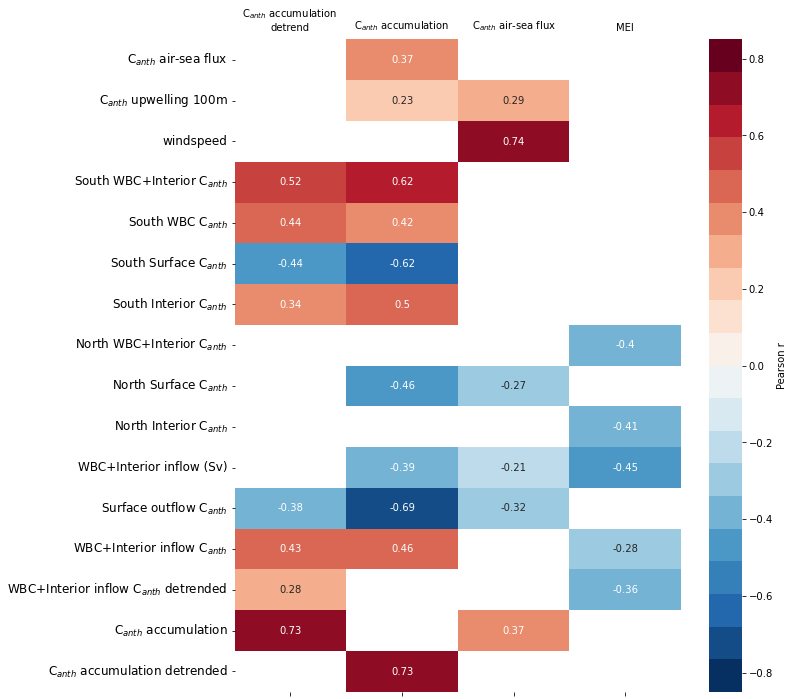

In [50]:
mini_corr=corr.loc[['C$_{anth}$ accumulation detrended','C$_{anth}$ accumulation','C$_{anth}$ air-sea flux','MEI']].replace(1,np.nan).T #anth_
mini_corr=mini_corr.rename({'C$_{anth}$ accumulation detrended':'C$_{anth}$ accumulation \ndetrend'},axis=1)
#annots=mini_corr
mini_corr=mini_corr.where(abs(mini_corr)>0.2).dropna(thresh=1)
plt.figure(figsize=(10,12)) 
cmap = cm.get_cmap('RdBu_r', 20) 
my_cmap = cmap
my_cmap.set_under("grey")

sns.heatmap(mini_corr,annot=True,cmap=cmap,vmin=-0.85,vmax=0.85,cbar_kws={'label': 'Pearson r'})#,mask=trimask)


plt.xticks(rotation=320,ha='left',fontsize=12)
plt.yticks(fontsize=12)
plt.tick_params(labelbottom=False,labeltop=True)
#plt.colorbar()
#_=plt.xticks(np.arange(0,len(corr_df_extra.columns),1),corr_df_extra.columns,rotation=310)
#_=plt.yticks(np.arange(0,len(corr_df_extra.columns),1),corr_df_extra.columns)

anth_co2_accumululation\n_detrend  \
co2flux                                                          NaN   
Canth upwelling 100m                                             NaN   
windspeed                                                        NaN   
S_subsurface+wbc_Canth_flow                                 0.527465   
S_WBC_Canth_flow                                            0.421861   
S_surface_Canth_flow                                       -0.504441   
S_subsurface_Canth_flow                                     0.351506   
N_subsurface+wbc_Canth_flow                                      NaN   
N_surface_Canth_flow                                             NaN   
N_subsurface_Canth_flow                                          NaN   
subsurface+wbc_flow_Sv                                           NaN   
anthC_surface_flow                                         -0.447435   
anthC_subsurface+wbc_flow                                   0.420816   
anthC_subsurface+wbc_flow_detrend                           0.274470   
anth_co2_accumululation                                     0.726823   
anth_co2_accumululation_detrend                                  NaN   

                                   anth_co2_accumululation   co2flux       MEI  
co2flux                                          -0.372857       NaN       NaN  
Canth upwelling 100m                                   NaN -0.291495       NaN  
windspeed                                              NaN -0.739432       NaN  
S_subsurface+wbc_Canth_flow                       0.604381       NaN       NaN  
S_WBC_Canth_flow                                  0.357748       NaN       NaN  
S_surface_Canth_flow                             -0.735459  0.279926       NaN  
S_subsurface_Canth_flow                           0.500631       NaN       NaN  
N_subsurface+wbc_Canth_flow                            NaN       NaN -0.375270  
N_surface_Canth_flow                             -0.561841  0.329305       NaN  
N_subsurface_Canth_flow                                NaN       NaN -0.430755  
subsurface+wbc_flow_Sv                           -0.385787       NaN -0.450582  
anthC_surface_flow                               -0.807733  0.396654       NaN  
anthC_subsurface+wbc_flow                         0.431809       NaN -0.287125  
anthC_subsurface+wbc_flow_detrend                      NaN       NaN -0.358287  
anth_co2_accumululation                                NaN -0.372857       NaN  
anth_co2_accumululation_detrend                   0.726823       NaN       NaN

<AxesSubplot:>

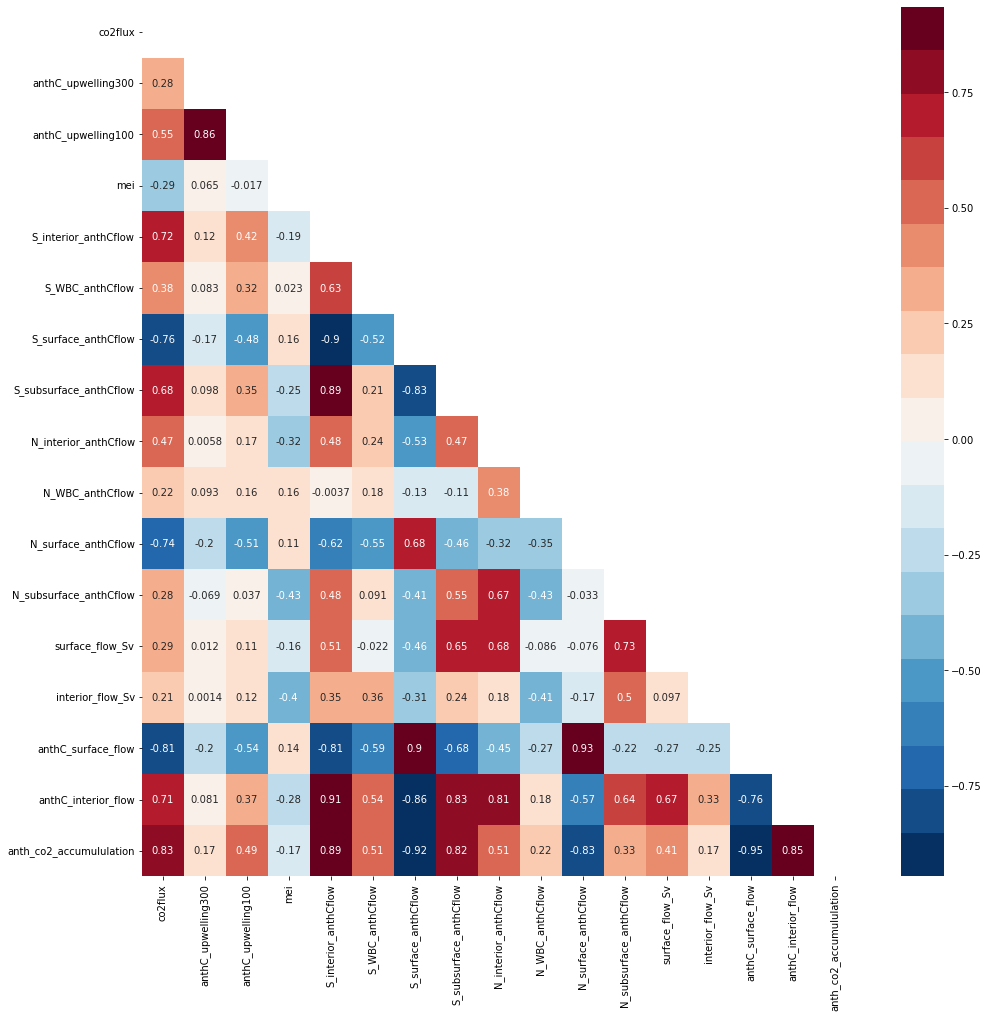

In [39]:
#corr_ds_extra
import seaborn as sns
from pylab import cm

#corr_df_extra=corr_ds_extra.drop(['lat','lat_x']).to_pandas()
plt.figure(figsize=(16,16))

cmap = cm.get_cmap('RdBu_r', 20) 
#plt.pcolormesh(corr_df_extra.corr(),cmap=cmap)
corr=corr_ds_extra.to_pandas().corr()
trimask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr,cmap=cmap,annot=True,mask=trimask)
#plt.colorbar()
#_=plt.xticks(np.arange(0,len(corr_df_extra.columns),1),corr_df_extra.columns,rotation=310)
#_=plt.yticks(np.arange(0,len(corr_df_extra.columns),1),corr_df_extra.columns)

In [60]:
co2_corr=cafe_co2_anth.sel(lat=slice(-5,5),lon=slice(160,300),time=slice('1980','2019-12-31')).mean(['lat','lon'])
corr_ds=co2_corr.to_dataset(name='co2flux')
corr_ds['upwelling']=anthupwelling.sel(time=slice('1980','2019-12-31'),lat=slice(-5,5),lon=slice(160,300)).mean(['lat','lon']).sel(st_ocean=-300,method='nearest')
corr_ds['mei']=enso_ts.rename({'Date':'time'},axis=1).set_index('time')['mei']
corr_ds['surface_flow']=surface.sel(time=slice('1980','2019-12-31'))
corr_ds['interior_flow']=interior.sel(time=slice('1980','2019-12-31'))
corr_ds['anth_surface_flow']=anth_surface.sel(time=slice('1980','2019-12-31'))
corr_ds['anth_interior_flow']=anth_interior.sel(time=slice('1980','2019-12-31'))
corr_ds['anth_co2_accumululation']=((tot_anth_dic_cafe.sel(lat=slice(-5,5),lon=slice(160,300)).sum(['lat','lon','st_ocean'])*12)/1e18).sel(time=slice('1980','2019-12-31'))
corr_ds=corr_ds.drop(['ensemble','st_ocean'])
corr_ds

<xarray.Dataset>
Dimensions:                  (time: 480)
Coordinates:
  * time                     (time) datetime64[ns] 1980-01-01 ... 2019-12-01
Data variables:
    co2flux                  (time) float32 3.612e-06 3.322e-06 ... 9.327e-06
    upwelling                (time) float64 dask.array<chunksize=(69,), meta=np.ndarray>
    mei                      (time) float64 0.35 0.19 0.41 ... 0.27 0.45 0.41
    surface_flow             (time) float64 dask.array<chunksize=(80,), meta=np.ndarray>
    interior_flow            (time) float64 dask.array<chunksize=(80,), meta=np.ndarray>
    anth_surface_flow        (time) float64 dask.array<chunksize=(80,), meta=np.ndarray>
    anth_interior_flow       (time) float64 dask.array<chunksize=(80,), meta=np.ndarray>
    anth_co2_accumululation  (time) float64 dask.array<chunksize=(21,), meta=np.ndarray>

In [65]:
corr_ds.load()#to_pandas()

<xarray.Dataset>
Dimensions:                  (time: 480)
Coordinates:
  * time                     (time) datetime64[ns] 1980-01-01 ... 2019-12-01
Data variables:
    co2flux                  (time) float32 3.612e-06 3.322e-06 ... 9.327e-06
    upwelling                (time) float64 3.79e+05 3.818e+05 ... 4.064e+04
    mei                      (time) float64 0.35 0.19 0.41 ... 0.27 0.45 0.41
    surface_flow             (time) float64 -41.08 -42.32 ... -48.06 -47.54
    interior_flow            (time) float64 39.54 38.66 38.22 ... 35.89 38.46
    anth_surface_flow        (time) float64 -1.239e+09 -1.282e+09 ... -3.074e+09
    anth_interior_flow       (time) float64 1.231e+09 1.198e+09 ... 2.399e+09
    anth_co2_accumululation  (time) float64 2.43 2.389 2.367 ... 4.043 4.145

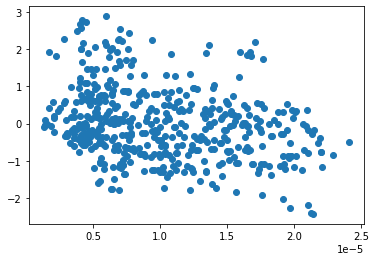

In [135]:
plt.scatter(corr_ds.co2flux,corr_ds.mei)

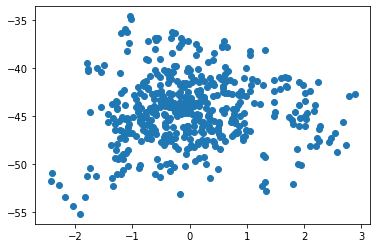

In [133]:
plt.scatter(corr_ds.mei,corr_ds.surface_flow)

In [92]:
? mpl.colors.colormap

In [92]:

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Object ` mpl.colors.colormap` not found.


In [86]:
bounds = np.linspace(0, 20, 21)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

<Figure size 720x720 with 0 Axes>

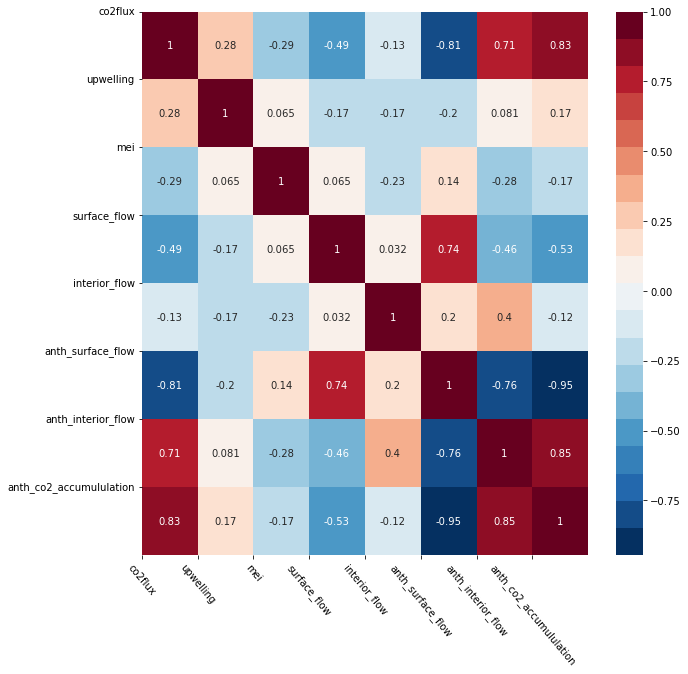

In [116]:
corr_df=corr_ds.to_pandas()
plt.figure(figsize=(10,10))

cmap = cm.get_cmap('RdBu_r', 20) 
plt.figure(figsize=(10,10))
trimask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr_df.corr(),cmap=cmap,annot=True,mask=trimask)

_=plt.xticks(np.arange(0,len(corr_df.columns),1),corr_df.columns,rotation=310)
_=plt.yticks(np.arange(0,len(corr_df.columns),1),corr_df.columns)

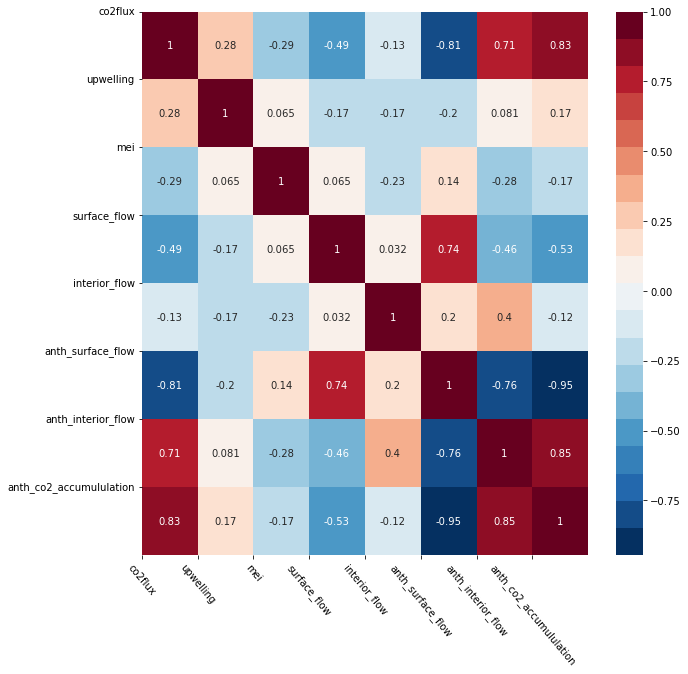

In [101]:
import seaborn as sns
plt.figure(figsize=(10,10))
sns.heatmap(corr_df.corr(),cmap=cmap,annot=True)

_=plt.xticks(np.arange(0,len(corr_df.columns),1),corr_df.columns,rotation=310)
_=plt.yticks(np.arange(0,len(corr_df.columns),1),corr_df.columns)

In [63]:
#xr.corr(corr_ds,corr_ds)

TypeError: Only xr.DataArray is supported.Given [<class 'xarray.core.dataset.Dataset'>, <class 'xarray.core.dataset.Dataset'>].

In [186]:
surface_corr.drop('ensemble')

<xarray.DataArray 'ty_trans' (time: 480)>
dask.array<getitem, shape=(480,), dtype=float64, chunksize=(103,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-12-01

In [189]:
xr.corr(interior_corr.drop('ensemble'),surface_corr.drop('ensemble'),dim='time').values**2

0.0010308638417790936

In [210]:
xr.corr(interior_corr.drop('ensemble'),co2_corr.drop('ensemble'),dim='time').values

array(-0.12865824)

In [209]:
xr.corr(interior_corr.drop('ensemble').chunk('auto'),anth_co2_accumulation_corr.drop('ensemble').chunk('auto'),dim='time').values

array(-0.11978553)

In [215]:
#interior_corr.values
np.corrcoef(interior_corr.values,co2_corr.values)

array([[ 1.        , -0.12865826],
       [-0.12865826,  1.        ]])

(array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9,  10]),
 array([0.21011999, 0.210029  , 0.20994459, 0.20984975, 0.20978456,
        0.2098183 , 0.20974823, 0.20964718, 0.209591  , 0.20960353,
        0.20960198, 0.20927382, 0.20892809, 0.20847082, 0.20795223,
        0.2073675 , 0.20686145, 0.20618331, 0.20563224, 0.20521845,
        0.20465938]),
 <matplotlib.lines.Line2D at 0x7f0299638640>)

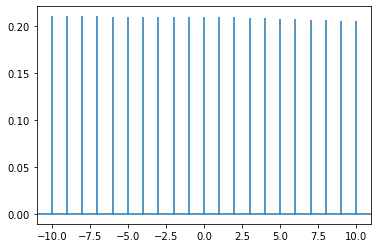

In [218]:
plt.xcorr(interior_corr.values,co2_corr.values,normed=False)

In [213]:
stats.pearsonr(interior_corr.values,surface_corr.values)

(0.03210706840835975, 0.4828179198650511)

(array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9,  10]),
 array([-0.97505621, -0.97647621, -0.9778685 , -0.97925473, -0.98070503,
        -0.98223342, -0.98379444, -0.98545897, -0.9871621 , -0.98888034,
        -0.99065381, -0.98887006, -0.98705302, -0.98525004, -0.98342483,
        -0.98161537, -0.97981671, -0.97799165, -0.97609916, -0.97423331,
        -0.97235525]),
 <matplotlib.lines.Line2D at 0x7f0299550640>)

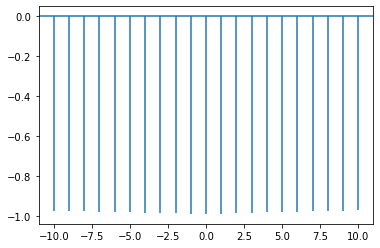

In [211]:
plt.xcorr(interior_corr.values,surface_corr.values)

In [142]:
anth_co2_flux

NameError: name 'anth_co2_flux' is not defined

In [133]:
enso_flat.iloc[1]

0.35

In [134]:
enso_dates

DatetimeIndex(['1979-01-01', '1979-02-01', '1979-03-01', '1979-04-01',
               '1979-05-01', '1979-06-01', '1979-07-01', '1979-08-01',
               '1979-09-01', '1979-10-01',
               ...
               '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01',
               '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01',
               '2021-07-01', '2021-08-01'],
              dtype='datetime64[ns]', length=512, freq=None)

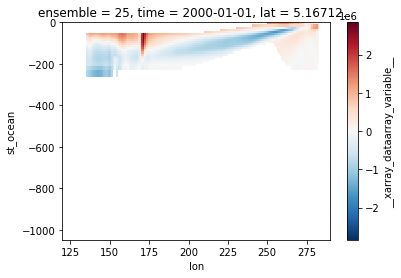

In [40]:
anth_dic_v_tx.sel(lat=5,method='nearest').mean(dim='time').where(mask.north_subsurface.sel(lat=5,method='nearest')==1).where(mask.north_subsurface.sel(lat=5,method='nearest')==1).sel(time='2000-01-01').plot()

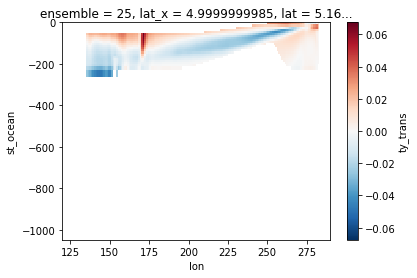

In [33]:
cafe_y_tx.sel(lat_x=5,method='nearest').mean(dim='time').where(mask.north_subsurface.sel(lat=5,method='nearest')==1).where(mask.north_subsurface.sel(lat=5,method='nearest')==1).sel(time='2000-01-01').plot()

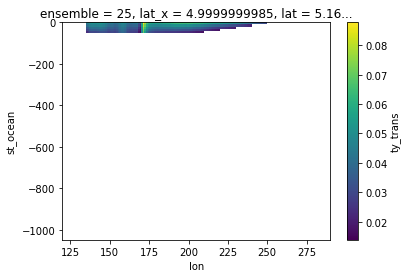

In [34]:
cafe_y_tx.sel(lat_x=5,method='nearest').mean(dim='time').where(mask.north_surface.sel(lat=5,method='nearest')==1).mean(dim='time').plot()

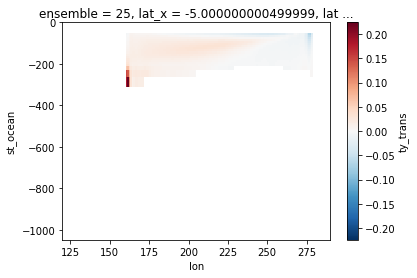

In [35]:
cafe_y_tx.sel(lat_x=-5,method='nearest').mean(dim='time').where(mask.south_subsurface.sel(lat=-5,method='nearest')==1).where(mask.south_subsurface.sel(lat=-5,method='nearest')==1).sel(time='2000-01-01').plot()

In [ ]:
surface_mask.vals.plot()
plt.ylim([0,200])

In [ ]:
deep_mask.vals.plot()
plt.ylim([0,200])

In [ ]:
surface_mask.plot.scatter()

In [ ]:
180+75

In [ ]:
# Diagonal Line

In [ ]:
S_cutoff=50 #m depth
N_cutoff=50
N_cutoff_2=


#To adapt to the changing surface-subsurface boundary, we choose the 50-m level west of 145◦ W and introduce a linear slope east of 145◦ W that reaches the surface at 105◦ W.

In [ ]:
# Validation Budget
anth_dic_cafe=xr.open_dataset('../processed_data/physics_ds/anth_DIC_pac_alldep1.nc').chunk('auto').__xarray_dataarray_variable__

st_ocean_holder=anth_dic_cafe.st_ocean

l=0
depth_diffs=[]
# Calcualate the m between depths so we can integrate
for i,x in enumerate(st_ocean_holder.st_ocean):
    d=x.values-l
    l=x.values
    #print(d)#x.values)
    depth_diffs.append(d)

st_ocean_holder=st_ocean_holder.assign_coords(
    depth_diff=('st_ocean', depth_diffs))

anth_dic_cafe=anth_dic_cafe*st_ocean_holder.depth_diff #Cell weighted depth


area_m2=xr.open_dataset('/g/data/xv83/rxm599/area.nc')
area_m2['xt_ocean']=area_m2['xt_ocean']+360
#area_m2['xu_ocean']=area_m2['xu_ocean']+360
area_m2=area_m2.sel(xt_ocean=slice(120,290),yt_ocean=slice(-40,40)).area_t.rename({'xt_ocean':'lon','yt_ocean':'lat'})

tot_anth_dic_cafe=anth_dic_cafe*area_m2/1000 #mol anthC (m3 is now cancelled)

In [ ]:
# + [markdown] Collapsed="false"
#RIchards Fast Calcs
# ## Fluxes
file2='/g/data/xv83/dcfp/CAFE60v1/ocean_bgc_month.zarr.zip'#'/OSM/CBR/OA_DCFP/data/model_output/CAFE/data_assimilation/d60-zarr/ocean_bgc_month.zarr'#gc=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_bgc_month.zarr.zip')
file1='/g/data/xv83/rxm599/area.nc' #

dgrid=xr.open_dataset(file1)
dbgc = xr.open_zarr(file2,consolidated=True)


# + Collapsed="false"
stf10_mean = dbgc.stf10.mean(axis=1)
stf10_std = dbgc.stf10.std(axis=1)
stf07_mean = dbgc.stf07.mean(axis=1)
stf07_std = dbgc.stf07.std(axis=1)

# + Collapsed="false"
# q Pacific
#edic=stf07_mean.sel(yt_ocean=slice(-3,3),xt_ocean=slice(120,260)).load()
#eadic=stf10_mean.sel(yt_ocean=slice(-90,-35),xt_ocean=slice(120,260)).load()
#esum=edic*dgrid.area_t*86400*365*12E-3
#etotsd=esum.sum(axis=(1,2)).load()
#esum=eadic*dgrid.area_t*86400*365*12E-3
#etotsa=esum.sum(axis=(1,2)).load()

# model
tmp=dbgc.adic.mean(axis=1)  #.sel(ensemble=25) # Check chunks first
adic=tmp.sel(time=slice('2000-01-16','2000-12-31')).mean(axis=0)
tmp=dbgc.dic.mean(axis=1)
dic=tmp.sel(time=slice('2000-01-16','2000-12-31')).mean(axis=0)
cant=(adic-dic).load()

tmp=dbgc.adic.mean(axis=1)
adic1=tmp.sel(time=slice('2019-01-16','2019-12-31')).mean(axis=0)
tmp=dbgc.dic.mean(axis=1)
dic1=tmp.sel(time=slice('2019-01-16','2019-12-31')).mean(axis=0)
cant1=(adic1-dic1).load()


#cant=cant*

# + Collapsed="false"
mdepth=np.copy(dbgc.st_ocean)
dd=dbgc.st_ocean.copy()
dtop=mdepth*0
#dtop[49]=6000
dtop[1:50]=(mdepth[1:50]-mdepth[0:49])*.5 + mdepth[0:49]
dtop
dmx=dtop*0
dmx[0:49]=dtop[1:50]-dtop[0:49]; dmx[49]=334.7
dd=dd*0+dmx
inv=1e-3*cant*dd*dgrid.area_t
inv1=1e-3*cant1*dd*dgrid.area_t
mcinv=inv.sum(axis=0)

In [ ]:
dbgc

In [ ]:
ens=23
t1 = '2000-01-16'
t2 = '2018-12-31'
x1=-227 ; x2=-75
y1=-20 ; y2=20
adic=dbgc.adic[:,ens,:,:,:].sel(time=slice(t1,t2),xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))
dic=dbgc.dic[:,ens,:,:,:].sel(time=slice(t1,t2),xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))
aco2=adic-dic
aco2.shape

cthickness=dd
cthickness

omask=(aco2[-1,0,:,:]*0).copy()
cinv = aco2*cthickness*1e-3 #mmol to mol
mcinv600=cinv.sel(st_ocean=slice(0,600)).sum(axis=1)+omask

aco2_change = (mcinv600[-1:,:,:]-mcinv600[0,:,:]).load()
area_r=dgrid.area_t#.rename({'grid_y_T':'yt_ocean','grid_x_T':'xt_ocean' })
area_s = area_r.sel(xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))
area_tmp=area_s.assign_coords({'yt_ocean': aco2_change.yt_ocean}).load()
i_aco2=aco2_change*area_tmp
i_aco2 

i_aco2.sum(axis=(1,2)).values


sum=i_aco2.sum(axis=(1,2))*12*1e-15 #Pg C 

# equatorial Pacific
# 160E  and 110W  - -200 and -110
x1e=-200 ; x2e=-110
y1e=-3 ; y2e=3
tmp1=i_aco2.sel(xt_ocean=slice(x1e,x2e),yt_ocean=slice(y1e,y2e))
sum1=tmp1.sum(axis=(1,2))*12*1e-15 #Pg C
print(sum.values,sum1.values)

In [ ]:
# Do same but for physics
phys_fp='/g/data/xv83/dcfp/CAFE60v1/ocean_month.zarr.zip'
phys = xr.open_zarr(phys_fp,consolidated=True)
phys.ty_trans[:,ens,:,:,:].sel(st_ocean=slice(0,600)).sel(time='2018-12-01',method='nearest').sel(yu_ocean=5,method='nearest')#.plot()


In [ ]:
mer_tx=phys.adic[:,ens,:,:,:].sel(time=slice(t1,t2),xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))

In [ ]:
# Validation Budget
anth_dic_cafe=xr.open_dataset('../processed_data/physics_ds/anth_DIC_pac_alldep1.nc').chunk('auto').__xarray_dataarray_variable__

st_ocean_holder=anth_dic_cafe.st_ocean

l=0
depth_diffs=[]
# Calcualate the m between depths so we can integrate
for i,x in enumerate(st_ocean_holder.st_ocean):
    d=x.values-l
    l=x.values
    #print(d)#x.values)
    depth_diffs.append(d)

st_ocean_holder=st_ocean_holder.assign_coords(
    depth_diff=('st_ocean', depth_diffs))

# Multiply by Cell Depths
anth_dic_cafe=anth_dic_cafe*st_ocean_holder.depth_diff #Cell weighted depth


area_m2=xr.open_dataset('/g/data/xv83/rxm599/area.nc')
area_m2['xt_ocean']=area_m2['xt_ocean']+360
#area_m2['xu_ocean']=area_m2['xu_ocean']+360
area_m2=area_m2.sel(xt_ocean=slice(120,290),yt_ocean=slice(-40,40)).area_t.rename({'xt_ocean':'lon','yt_ocean':'lat'})

tot_anth_dic_cafe=anth_dic_cafe*area_m2#/1000 #mol anthC (m3 is now cancelled)

tot_anth_dic_cafe.sel(time='2018-12-01').sel(lat=slice(-3,3),st_ocean=slice(0,700),lon=slice(160,250)).sum().values*12*1e-18

In [ ]:
tot_anth_dic_cafe.sel(time='2000-01-01').sel(lat=slice(-3,3),st_ocean=slice(0,700),lon=slice(160,250)).sum().values*12*1e-18

In [ ]:
1.6837-1.2571